# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>1. Import Library</b></div>

### result
| | clip_limit | tile_grid_size | accuracy | f1_score |
|---|------------|----------------|----------|----------|
| 0 | 2.0 | (4, 4) | 0.487500 | 0.471346 |
| 1 | 2.0 | (8, 8) | 0.445833 | 0.422905 |
| 2 | 2.0 | (16, 16) | 0.513889 | 0.486160 |
| 3 | 2.0 | (32, 32) | 0.505556 | 0.461311 |
| 4 | 3.0 | (4, 4) | 0.495833 | 0.472558 |
| 5 | 3.0 | (8, 8) | 0.468056 | 0.453082 |
| 6 | 3.0 | (16, 16) | 0.497222 | 0.514586 |
| 7 | 3.0 | (32, 32) | 0.476389 | 0.467571 |
| 8 | 4.0 | (4, 4) | 0.361111 | 0.341683 |
| 9 | 4.0 | (8, 8) | 0.495833 | 0.474017 |
| 10 | 4.0 | (16, 16) | 0.465278 | 0.423986 |
| 11 | 4.0 | (32, 32) | 0.436111 | 0.442119 |

- Best CLAHE settings:
- Clip Limit: 3.0
- Tile Grid Size: (16, 16)
- F1 Score: 0.5145858717925139
- Accuracy: 0.49722222222222223

<div style="border-radius:10px; border: #FFA500 solid; padding: 15px; font-size:100%;">

📌 **Experimental Parameters**
    
- `Image Size`: 256X256
    
- `CLAHE(Contrast Limited Adaptive Histogram Equalization)`: clipLimit: ??, tileGridSize: ??
    - clip_limits = [2.0,3.0,4.0]
    - tile_grid_sizes = [(4,4),(8,8),(16,16),(32,32)]
    - cf) base model의 파라미터 :clipLimit: 2.0, tileGridSize: (4,4)


- `Label` : all 9 labels

- `Label Smoothing`: 0.2
    
- `Loss`: CategorialCrossEntropy
    
- `Fold`: SKF(n_splits=5) But, Only Traininig Fold1
    
- `Weak Augment`: HFlip(p=0.5)
    
- `Strong Augment`: X
  
- `BackBone Model`: TF ResNet18
    
- `Freezing Layer`: 10% Layers
    
- `Batch Size`: 16
    
- `Learning Rate`: 1e-3
    
- `Epoch`: 10
    
- `Optimizer`: Adam


In [1]:
import gc 
import ctypes
import random
from tqdm import tqdm
from collections import defaultdict

import os
import sys
import pickle

## Tensorflow Setting
import tensorflow as tf
from tensorflow.keras import *
import tensorflow.keras.backend as K, gc

os.environ['CUDA_IS_VISIBLE'] = '0,1'
print('tensorflow version: ', tf.__version__)

import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob
import cv2
from PIL import Image

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold, StratifiedKFold,GroupKFold
from sklearn.model_selection import train_test_split

import warnings 
import albumentations as albu
warnings.filterwarnings('ignore')

## GPU Settings
gpus = tf.config.list_physical_devices('GPU')
if len(gpus) <=1:
    strategy = tf.distribute.OneDeviceStrategy(device='/gpu:0')
    print(f'Using {len(gpus)} GPUs')
else: 
    strategy = tf.distribute.MirroredStrategy()
    print(f'Using {len(gpus)} GPUs')
    
LOAD_MODELS_FROM = None

2024-08-19 12:47:40.087697: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-19 12:47:40.087790: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-19 12:47:40.246268: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


tensorflow version:  2.15.0
Using 2 GPUs


In [2]:
def clean_memory():
    # malloc_trim: 현재 사용되지 않는 메모리를 시스템에서 다시 반환함0
    ctypes.CDLL('libc.so.6').malloc_trim(0)
    gc.collect()
clean_memory()

In [3]:
def seed_everything(seed):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
seed_everything(42)

In [4]:
MIX = True
if MIX: 
    tf.config.optimizer.set_experimental_options({'auto_mixed_precision':True})
    print('Mixed Precision enabled')
else: 
    print('Using full precision')

Mixed Precision enabled


# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>2. Road and Read Data</b></div>

In [5]:
df = pd.read_csv('/kaggle/input/data/Data_Entry_2017.csv')
df = df.drop(columns='Unnamed: 11')
df = df[~df['Finding Labels'].str.contains('\|')]
df = df.reset_index(drop=True)
print(f'Shape of DataFrame: {df.shape}')
df.head(10)

Shape of DataFrame: (91324, 11)


Image Index Finding Labels  Follow-up #  Patient ID  Patient Age  \
0  00000001_000.png   Cardiomegaly            0           1           58   
1  00000002_000.png     No Finding            0           2           81   
2  00000003_000.png         Hernia            0           3           81   
3  00000003_001.png         Hernia            1           3           74   
4  00000003_002.png         Hernia            2           3           75   
5  00000003_004.png         Hernia            4           3           77   
6  00000003_005.png         Hernia            5           3           78   
7  00000003_006.png         Hernia            6           3           79   
8  00000003_007.png         Hernia            7           3           80   
9  00000005_000.png     No Finding            0           5           69   

  Patient Gender View Position  OriginalImage[Width  Height]  \
0              M            PA                 2682     2749   
1              M            PA                 2500     2048   
2              F            PA                 2582     2991   
3              F            PA                 2500     2048   
4              F            PA                 2048     2500   
5              F            PA                 2500     2048   
6              F            PA                 2686     2991   
7              F            PA                 2992     2991   
8              F            PA                 2582     2905   
9              F            PA                 2048     2500   

   OriginalImagePixelSpacing[x     y]  
0                        0.143  0.143  
1                        0.171  0.171  
2                        0.143  0.143  
3                        0.168  0.168  
4                        0.168  0.168  
5                        0.168  0.168  
6                        0.143  0.143  
7                        0.143  0.143  
8                        0.143  0.143  
9                        0.168  0.168

In [6]:
%%time
tmp = {os.path.basename(x): x for x in glob(os.path.join('/kaggle', 'input', '*','*','images', '*.png'))}    
    
df['path'] = df['Image Index'].map(tmp)

CPU times: user 525 ms, sys: 79.5 ms, total: 604 ms
Wall time: 3.54 s


#### Loading Pneumonia
___

- width: 1200
- height: 825

In [7]:
df_pneumonia = pd.DataFrame()
df_pneumonia['Image Index'] = os.listdir('/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/')
df_pneumonia['Finding Labels'] = 'Pneumonia'

tmp = {os.path.basename(x): x for x in glob(os.path.join('/kaggle', 'input', '*','*','train','*','*.jpeg'))}        
df_pneumonia['path'] = df_pneumonia['Image Index'].map(tmp)

df = pd.concat([df, df_pneumonia])
df = df.reset_index(drop=True)

#### Loading tuberculosis
___
- width: 512
- height: 512

In [8]:
df_tuberculosis = pd.DataFrame()
df_tuberculosis['Image Index'] = os.listdir('/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Tuberculosis/')
df_tuberculosis['Finding Labels'] = 'Tuberculosis'

tmp = {os.path.basename(x): x for x in glob(os.path.join('/kaggle', 'input', '*','*','*','*.png'))}        
df_tuberculosis['path'] = df_tuberculosis['Image Index'].map(tmp)

df = pd.concat([df, df_tuberculosis])
df = df.reset_index(drop=True)

#### Load Covid-19
___

- height: 825
- width: 1200

In [9]:
train_covid = pd.DataFrame()
train_covid['Image Index'] = os.listdir('/kaggle/input/chest-xray-pneumoniacovid19tuberculosis/train/COVID19/')
test_covid = pd.DataFrame()
test_covid['Image Index'] = os.listdir('/kaggle/input/chest-xray-pneumoniacovid19tuberculosis/test/COVID19/')
df_covid = pd.concat([train_covid, test_covid])
df_covid['Finding Labels'] = 'Covid'

tmp = {os.path.basename(x): x for x in glob(os.path.join('/kaggle', 'input', '*','*','*','*.jpg'))}        
df_covid['path'] = df_covid['Image Index'].map(tmp)

df = pd.concat([df, df_covid])
df = df.reset_index(drop=True)
df = df[['Image Index','Finding Labels', 'path']]

In [10]:
df_1 = pd.concat([df[df['Finding Labels'] == 'Edema'].sample(500, random_state=42)])
df_2 = pd.concat([df[df['Finding Labels'] == 'No Finding'].sample(500, random_state=42)])
df_3 = pd.concat([df[df['Finding Labels'] == 'Pneumonia'].sample(500, random_state=42)])
df_4 = pd.concat([df[df['Finding Labels'] == 'Tuberculosis'].sample(500, random_state=42)])
df_5 = pd.concat([df[df['Finding Labels'] == 'Cardiomegaly'].sample(500, random_state=42)])
df_6 = pd.concat([df[df['Finding Labels'] == 'Emphysema'].sample(500, random_state=42)])
df_7 = pd.concat([df[df['Finding Labels'] == 'Covid'].sample(500, random_state=42)])
df_8 = pd.concat([df[df['Finding Labels'] == 'Effusion'].sample(500, random_state=42)])
df_9 = pd.concat([df[df['Finding Labels'] == 'Atelectasis'].sample(500, random_state=42)])


df_all=[df_1,df_2,df_3,df_4,df_5,df_6,df_7,df_8,df_9]
df = pd.concat(df_all)
df = df.reset_index(drop=True)

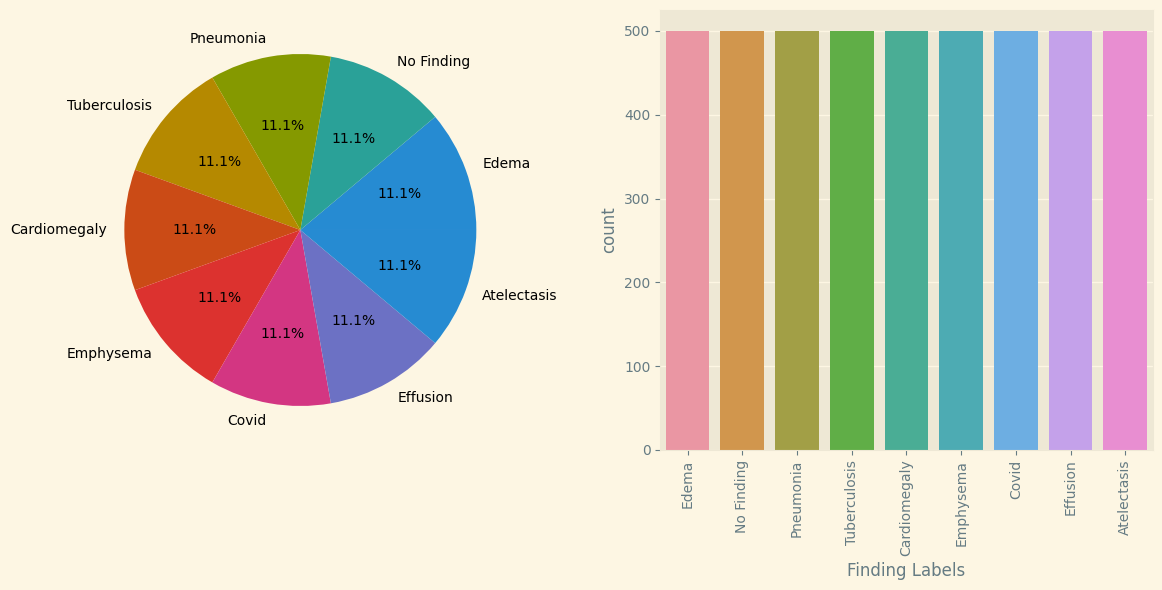

In [11]:
label_counts = df['Finding Labels'].value_counts()

plt.style.use('Solarize_Light2')

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.pie(df['Finding Labels'].value_counts(), labels=label_counts.index, autopct='%.1f%%')
# plt.legend()
plt.subplot(1,2,2)
sns.countplot(x=df['Finding Labels'], order= label_counts.index)
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

**Train & Test Split**

In [12]:
df_train, df_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=42)
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

**One Hot Encoding**

In [13]:
for col in df['Finding Labels'].unique():
    df_test[col] = np.where(df_test['Finding Labels'].str.contains(col), 1.0, 0.0).astype('float32')
    df_train[col] = np.where(df_train['Finding Labels'].str.contains(col), 1.0, 0.0).astype('float32')
TARGET = df_train.columns[-len(df_all):].tolist()

In [14]:
TARGET

['Edema',
 'No Finding',
 'Pneumonia',
 'Tuberculosis',
 'Cardiomegaly',
 'Emphysema',
 'Covid',
 'Effusion',
 'Atelectasis']

# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>3. Build DataGenerator</b></div>

In [15]:
import albumentations as albu
print(albu.__version__)

1.4.0


In [16]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data, batch_size=16, shuffle=False, augment1=False, augment2=False, preprocess=None, clip_limit=2.0, tile_grid_size=(4,4)):
        super().__init__()
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment1 = augment1
        self.augment2 = augment2
        self.on_epoch_end()
        self.preprocess = preprocess
        self.clip_limit = clip_limit
        self.tile_grid_size = tile_grid_size
        self.clahe = cv2.createCLAHE(clipLimit=self.clip_limit, tileGridSize=self.tile_grid_size)

    def __len__(self):

        # Drop_Last = False
        ct = int(np.ceil(len(self.data)/self.batch_size))
        return ct

    def __getitem__(self,index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X, y = self.__data_generation(indexes)
        if self.preprocess != None: X = self.preprocess(X)
        if self.augment1: X = self.__augment1(X)
        if self.augment2: X = self.__augment2(X)
        return X,y

    def on_epoch_end(self,):
        self.indexes = np.arange(len(self.data))
        if self.shuffle: np.random.shuffle(self.indexes)

    def __data_generation(self, indexes):

        X = np.zeros((len(indexes),256,256,3), dtype='float32') 
        y = np.zeros((len(indexes),len(TARGET)), dtype='float32')

        for j,i in enumerate(indexes):
            row = self.data.iloc[i]
            path = row['path']
            img = Image.open(path).convert('L')
            img = img.resize((256,256), Image.Resampling.LANCZOS) # DownSampling
            img = np.array(img) # PIL Object -> np.array(uint8)
            img = self.clahe.apply(img)
            img = np.expand_dims(img, axis=-1)
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) 

            # FillNaN
            m = np.nanmean(img)
            img = np.nan_to_num(img, nan=m)

            X[j,:,:] = img
            y[j,] = row[TARGET]

        return X,y

    def __augment1(self, img_batch):

        composition = albu.Compose([
            albu.HorizontalFlip(p=0.5),            

        ])

        for i in range(img_batch.shape[0]):
            img = composition(image=img_batch[i,])['image']
            img_batch[i,] = img

        return img_batch


    def __augment2(self, img_batch, mixup_prob=0.1):
        batch_size, height, width, channels = img_batch.shape

        idx = np.random.permutation(batch_size)
        lam = np.random.beta(2.0, 2.0) 

        for i in range(batch_size):
            if np.random.rand() <= mixup_prob:  
                j = idx[i]

                img_batch[i] = img_batch[i] * lam + img_batch[j] * (1-lam)

        return img_batch


# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>4. Build ResNet Model</b></div>

**Install ResNet**

In [17]:
!pip install -q git+https://github.com/qubvel/classification_models.git

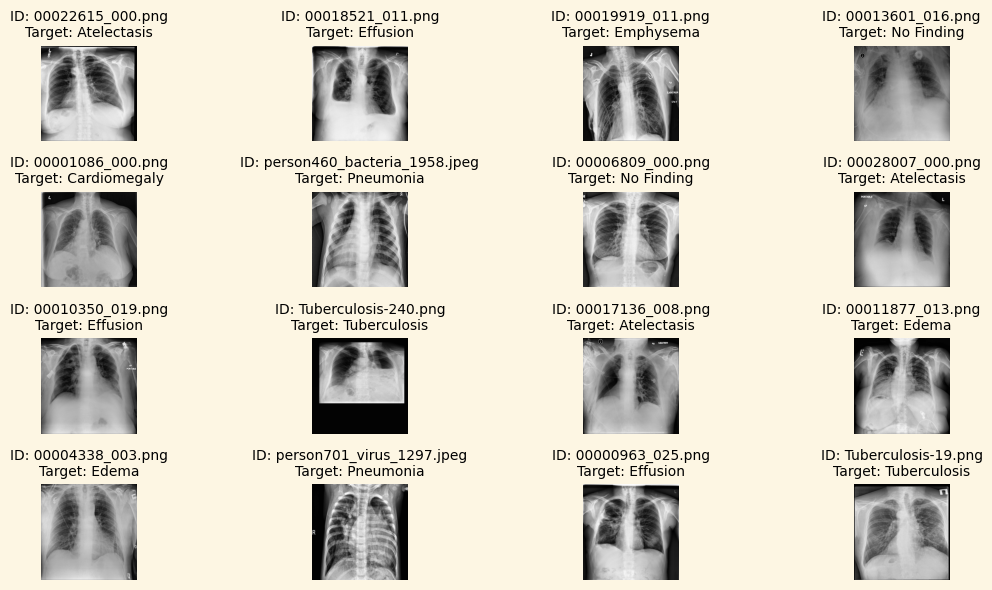

In [18]:
from classification_models.tfkeras import Classifiers

resnet18, preprocess_input = Classifiers.get('resnet18')

ROWS = 4; COLS = 4; BATCHES = 1

gen = DataGenerator(df_train, batch_size=16, shuffle=False, augment1=True, augment2=False, preprocess=None)

for i, (x,y) in enumerate(gen):
    plt.figure(figsize=(12,6))
    for j in range(ROWS):
        for k in range(COLS):
            plt.subplot(ROWS, COLS, j*COLS+k+1)
            img_id = df_train.iloc[i*16+j*COLS+k]['Image Index']
            plt.title(f'ID: {img_id}\nTarget: {df_train.iloc[i*16+j*COLS+k]["Finding Labels"]}', size=10)
            img = x[j*COLS+k,:,:,:3]
            img = img.astype('uint8')
            plt.imshow(img)
            plt.axis('off')
    plt.tight_layout()
    plt.show()
    if i==BATCHES-1: break

#### Macro F1_Score

In [19]:
def temp_f1_score(y_true, y_pred):
    # Calculate the F1 score for each class
    f1_scores = []
    num_classes = K.int_shape(y_pred)[-1]  # (batch_size, output_dims = num_classes)
    
    # Get the true and predicted class indices
    y_true = K.argmax(y_true, axis=-1)
    y_pred = K.argmax(y_pred, axis=-1) # For Label Smoothing(in CCE)

    for i in range(num_classes):
        true_positives = K.sum(K.cast(tf.logical_and(K.equal(y_true, i), K.equal(y_pred, i)), dtype=tf.float32))
        possible_positives = K.sum(K.cast(K.equal(y_true, i), dtype=tf.float32))
        predicted_positives = K.sum(K.cast(K.equal(y_pred, i), dtype=tf.float32))

        recall = true_positives / (possible_positives + K.epsilon())
        precision = true_positives / (predicted_positives + K.epsilon())
        
        f1_score = 2 * ((precision * recall) / (precision + recall + K.epsilon()))
        f1_scores.append(f1_score)
    
    
    # Calculate the macro-average F1 score
    macro_f1_score = K.mean(tf.stack(f1_scores))
    return macro_f1_score

**ReduceLROnPleateau in Callbacks**

In [20]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

EPOCHS = 10

lr = ReduceLROnPlateau(monitor = 'val_f1_score', factor = 0.1, patience = 1, min_delta = 0.01,
                              mode='max',verbose=1)

In [21]:
def build_model(): 
    inp = tf.keras.layers.Input(shape=(256,256,3)) 
    res_model = resnet18(include_top=False, weights='imagenet', input_shape=(256,256,3)) 
    res_model._name = 'resnet18' 

    ## Freezing Layer(10% Layer)
    for layer in res_model.layers[:len(res_model.layers)//10]:
        layer.trainable = False

    x = res_model(inp)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(len(TARGET), activation='softmax', dtype='float32')(x)

    # Compile
    model = tf.keras.Model(inputs=inp, outputs=x, name='hybrid')

    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2)
    opt = tf.keras.optimizers.Adam(learning_rate=1e-3)

    model.compile(loss=loss, optimizer=opt, metrics=['accuracy', temp_f1_score])

    return model

In [22]:
from tensorflow.keras.utils import plot_model

model = build_model()
model.summary()
#plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True)

44920640/44920640 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "hybrid"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional (Functional)         │ (None, 8, 8, 512)      │    11,186,889 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,191,506 (42.69 MB)

 Trainable params: 11,174,025 (42.63 MB)

 Non-trainable params: 17,481 (68.29 KB)

#### StratifiedKFold

In [23]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for i, (_, valid_index) in enumerate(skf.split(df_train, df_train['Finding Labels'])):
    df_train.loc[valid_index, 'Fold'] = i

In [24]:
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def create_confusion_matrix(true_labels, pred_labels, target_names, clip_limit, tile_grid_size):
    cm = confusion_matrix(true_labels, pred_labels, labels=range(len(target_names)))
    
    # Determine the appropriate figure size based on the number of targets
    n_targets = len(target_names)
    fig_size = n_targets * 0.7
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(fig_size + 4, fig_size), 
                                   gridspec_kw={'width_ratios': [fig_size, 4]})
    
    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(n_targets), 
                yticklabels=range(n_targets), ax=ax1)
    
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('True')
    ax1.set_title(f'Confusion Matrix\n(CLAHE: clip={clip_limit}, tile={tile_grid_size})')
    
    # Add label legend
    ax2.axis('off')
    for i, target in enumerate(target_names):
        ax2.text(0, 1 - i / n_targets, f'{i}: {target}', fontsize=10, va='center')
    ax2.set_title('Label Legend')
    
    plt.tight_layout()
    plt.show()

Training with CLAHE settings: clip_limit=2.0, tile_grid_size=(4, 4)
#########################
### Fold 1
### train size 2880, valid size 720
#########################
Epoch 1/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 155s 653ms/step - accuracy: 0.3552 - loss: 2.1280 - temp_f1_score: 0.2050 - val_accuracy: 0.3500 - val_loss: 2.5727 - val_temp_f1_score: 0.2187 - learning_rate: 0.0010
Epoch 2/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 87s 468ms/step - accuracy: 0.4631 - loss: 1.7617 - temp_f1_score: 0.2797 - val_accuracy: 0.4639 - val_loss: 1.9500 - val_temp_f1_score: 0.3405 - learning_rate: 0.0010
Epoch 3/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 87s 468ms/step - accuracy: 0.5165 - loss: 1.6722 - temp_f1_score: 0.3102 - val_accuracy: 0.3028 - val_loss: 2.4446 - val_temp_f1_score: 0.1937 - learning_rate: 0.0010
Epoch 4/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 87s 465ms/step - accuracy: 0.5694 - loss: 1.6397 - temp_f1_score: 0.3432 - val_accuracy: 0.4889 - val_loss: 1.8122 - val_temp_f1_score: 0.3439 - learning_rate: 0.0010
Epoc

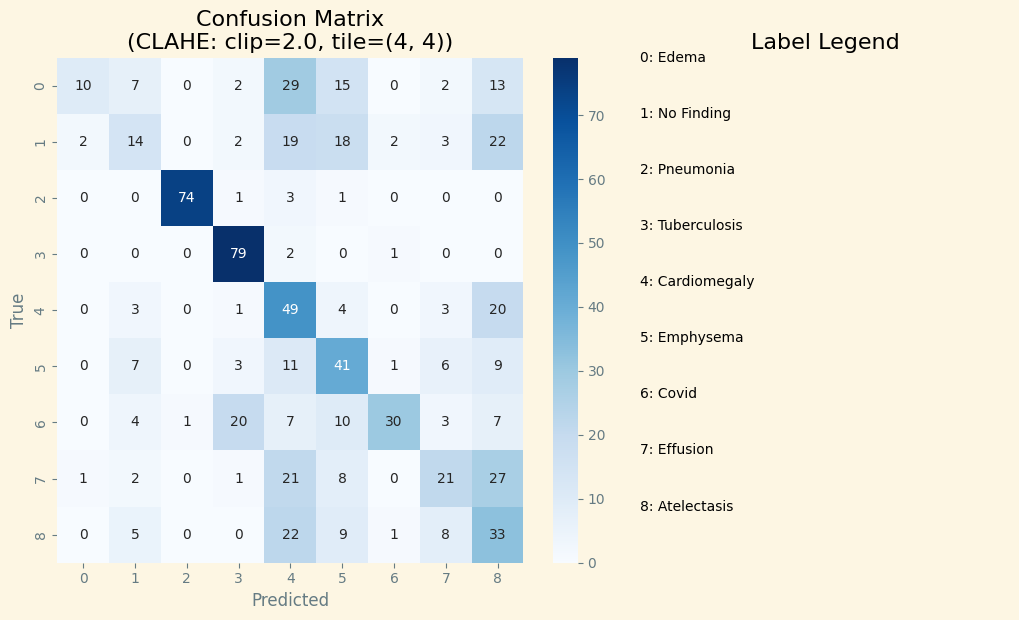

Accuracy for Validation Set = 0.4875
F1 Score for Validation Set = 0.47134597402524275
Training with CLAHE settings: clip_limit=2.0, tile_grid_size=(8, 8)
#########################
### Fold 1
### train size 2880, valid size 720
#########################
Epoch 1/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 121s 488ms/step - accuracy: 0.3707 - loss: 2.1537 - temp_f1_score: 0.2172 - val_accuracy: 0.3111 - val_loss: 2.8322 - val_temp_f1_score: 0.1844 - learning_rate: 0.0010
Epoch 2/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 86s 466ms/step - accuracy: 0.4631 - loss: 1.7651 - temp_f1_score: 0.2752 - val_accuracy: 0.3333 - val_loss: 2.1553 - val_temp_f1_score: 0.2217 - learning_rate: 0.0010
Epoch 3/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 86s 465ms/step - accuracy: 0.5194 - loss: 1.6862 - temp_f1_score: 0.3159 - val_accuracy: 0.3111 - val_loss: 2.7777 - val_temp_f1_score: 0.1979 - learning_rate: 0.0010
Epoch 4/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 86s 464ms/step - accuracy: 0.5485 - loss: 1.6497 - temp_f1_score: 0.3354 - val_accur

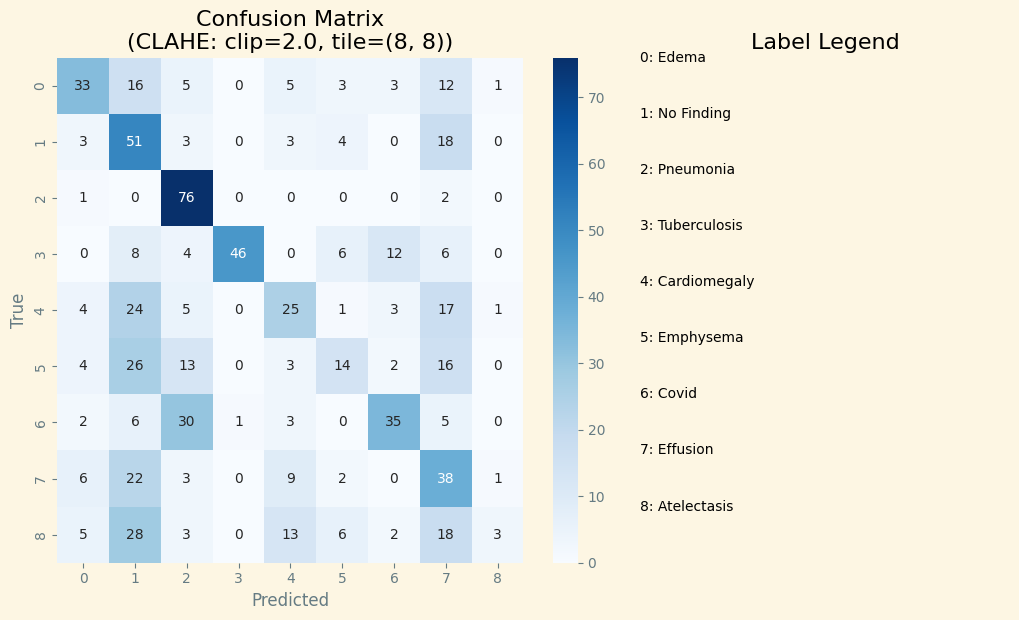

Accuracy for Validation Set = 0.44583333333333336
F1 Score for Validation Set = 0.4229050096559879
Training with CLAHE settings: clip_limit=2.0, tile_grid_size=(16, 16)
#########################
### Fold 1
### train size 2880, valid size 720
#########################
Epoch 1/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 121s 488ms/step - accuracy: 0.3159 - loss: 2.2290 - temp_f1_score: 0.1811 - val_accuracy: 0.4222 - val_loss: 2.3327 - val_temp_f1_score: 0.2591 - learning_rate: 0.0010
Epoch 2/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 87s 469ms/step - accuracy: 0.4616 - loss: 1.7667 - temp_f1_score: 0.2777 - val_accuracy: 0.4306 - val_loss: 1.8850 - val_temp_f1_score: 0.2748 - learning_rate: 0.0010
Epoch 3/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 86s 465ms/step - accuracy: 0.5369 - loss: 1.6821 - temp_f1_score: 0.3262 - val_accuracy: 0.5250 - val_loss: 1.8608 - val_temp_f1_score: 0.3910 - learning_rate: 0.0010
Epoch 4/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 87s 467ms/step - accuracy: 0.5545 - loss: 1.6424 - temp_f1_score: 0.34

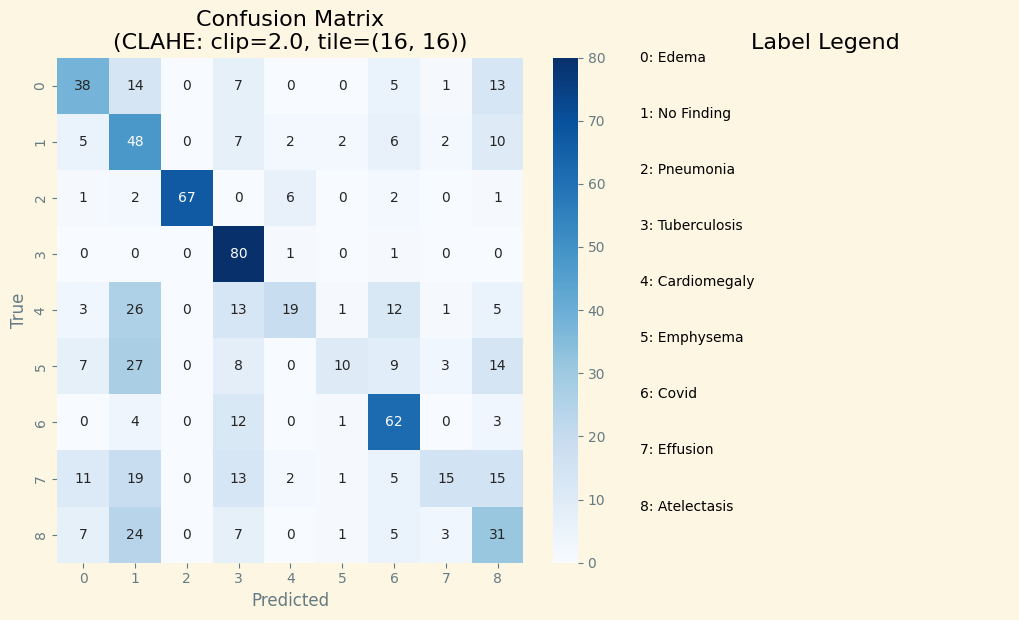

Accuracy for Validation Set = 0.5138888888888888
F1 Score for Validation Set = 0.48615985043101456
Training with CLAHE settings: clip_limit=2.0, tile_grid_size=(32, 32)
#########################
### Fold 1
### train size 2880, valid size 720
#########################
Epoch 1/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 122s 493ms/step - accuracy: 0.3566 - loss: 2.2170 - temp_f1_score: 0.2144 - val_accuracy: 0.3333 - val_loss: 3.4778 - val_temp_f1_score: 0.1949 - learning_rate: 0.0010
Epoch 2/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 87s 469ms/step - accuracy: 0.4753 - loss: 1.7845 - temp_f1_score: 0.2749 - val_accuracy: 0.1389 - val_loss: 2.6860 - val_temp_f1_score: 0.0360 - learning_rate: 0.0010
Epoch 3/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 87s 464ms/step - accuracy: 0.5213 - loss: 1.6908 - temp_f1_score: 0.3127 - val_accuracy: 0.4222 - val_loss: 1.9103 - val_temp_f1_score: 0.3055 - learning_rate: 0.0010
Epoch 4/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 88s 473ms/step - accuracy: 0.5503 - loss: 1.6262 - temp_f1_score: 0.32

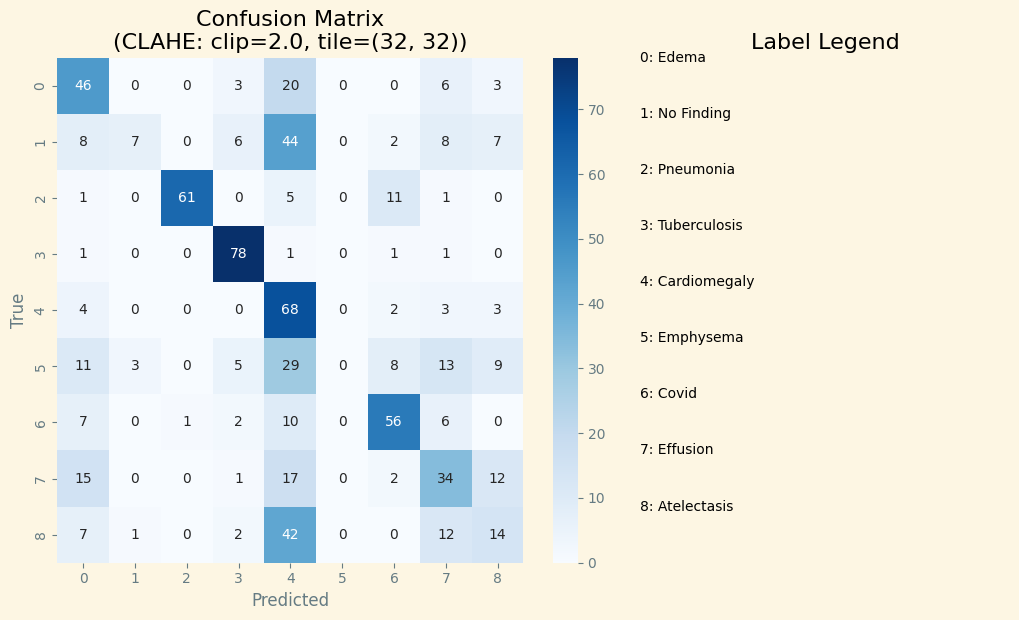

Accuracy for Validation Set = 0.5055555555555555
F1 Score for Validation Set = 0.4613109093642961
Training with CLAHE settings: clip_limit=3.0, tile_grid_size=(4, 4)
#########################
### Fold 1
### train size 2880, valid size 720
#########################
Epoch 1/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 120s 489ms/step - accuracy: 0.3381 - loss: 2.1923 - temp_f1_score: 0.2019 - val_accuracy: 0.2556 - val_loss: 3.8551 - val_temp_f1_score: 0.1471 - learning_rate: 0.0010
Epoch 2/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 87s 471ms/step - accuracy: 0.4721 - loss: 1.7518 - temp_f1_score: 0.2797 - val_accuracy: 0.4583 - val_loss: 1.9582 - val_temp_f1_score: 0.3140 - learning_rate: 0.0010
Epoch 3/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 86s 465ms/step - accuracy: 0.5204 - loss: 1.6931 - temp_f1_score: 0.3117 - val_accuracy: 0.2750 - val_loss: 2.4678 - val_temp_f1_score: 0.1593 - learning_rate: 0.0010
Epoch 4/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 86s 465ms/step - accuracy: 0.5743 - loss: 1.6132 - temp_f1_score: 0.3460 

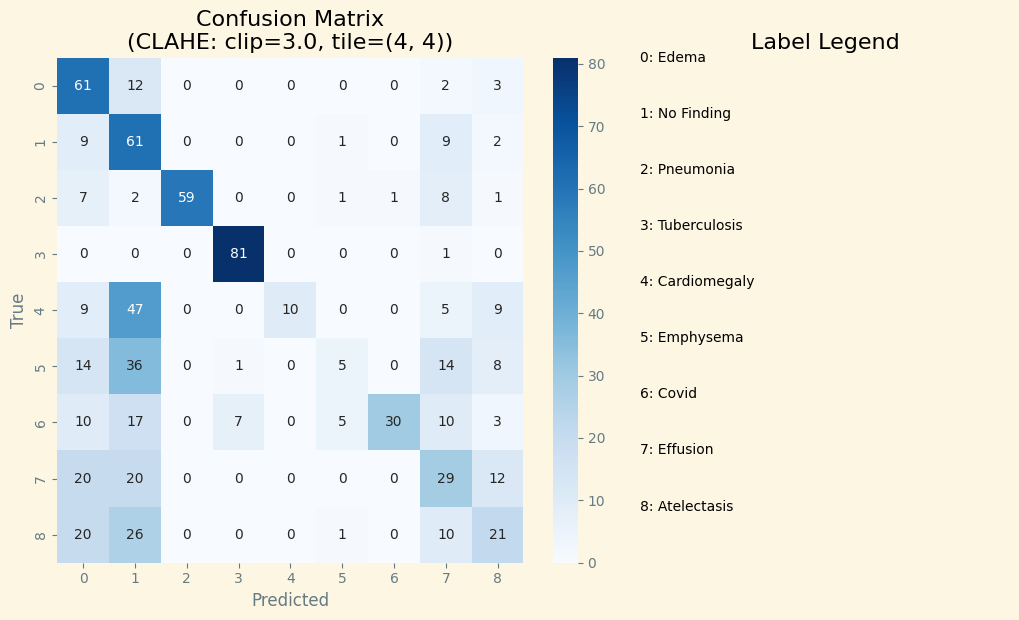

Accuracy for Validation Set = 0.49583333333333335
F1 Score for Validation Set = 0.472557695658116
Training with CLAHE settings: clip_limit=3.0, tile_grid_size=(8, 8)
#########################
### Fold 1
### train size 2880, valid size 720
#########################
Epoch 1/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 119s 484ms/step - accuracy: 0.3203 - loss: 2.2127 - temp_f1_score: 0.1823 - val_accuracy: 0.1444 - val_loss: 9.1702 - val_temp_f1_score: 0.0491 - learning_rate: 0.0010
Epoch 2/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 87s 468ms/step - accuracy: 0.4732 - loss: 1.7707 - temp_f1_score: 0.2706 - val_accuracy: 0.3389 - val_loss: 2.0243 - val_temp_f1_score: 0.2066 - learning_rate: 0.0010
Epoch 3/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 87s 469ms/step - accuracy: 0.5244 - loss: 1.6880 - temp_f1_score: 0.3130 - val_accuracy: 0.4472 - val_loss: 2.2119 - val_temp_f1_score: 0.2994 - learning_rate: 0.0010
Epoch 4/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 87s 469ms/step - accuracy: 0.5541 - loss: 1.6287 - temp_f1_score: 0.3354 

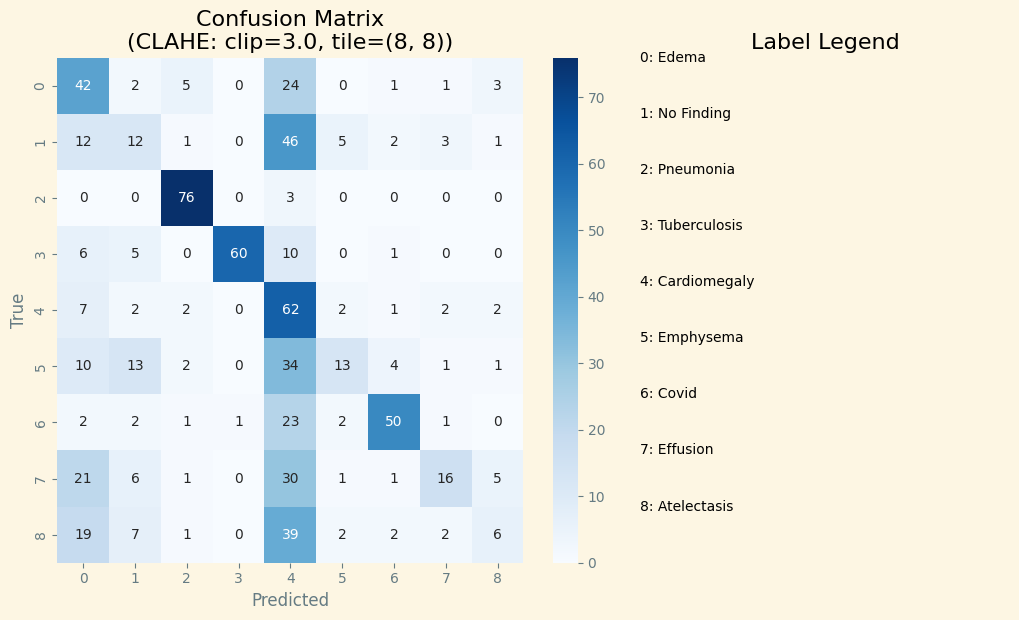

Accuracy for Validation Set = 0.46805555555555556
F1 Score for Validation Set = 0.4530820214029813
Training with CLAHE settings: clip_limit=3.0, tile_grid_size=(16, 16)
#########################
### Fold 1
### train size 2880, valid size 720
#########################
Epoch 1/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 120s 486ms/step - accuracy: 0.3466 - loss: 2.2159 - temp_f1_score: 0.1953 - val_accuracy: 0.3389 - val_loss: 3.0408 - val_temp_f1_score: 0.2265 - learning_rate: 0.0010
Epoch 2/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 87s 470ms/step - accuracy: 0.4729 - loss: 1.7644 - temp_f1_score: 0.2859 - val_accuracy: 0.3083 - val_loss: 2.2954 - val_temp_f1_score: 0.1973 - learning_rate: 0.0010
Epoch 3/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 88s 472ms/step - accuracy: 0.5146 - loss: 1.6932 - temp_f1_score: 0.3083 - val_accuracy: 0.3639 - val_loss: 2.1328 - val_temp_f1_score: 0.2510 - learning_rate: 0.0010
Epoch 4/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 87s 469ms/step - accuracy: 0.5236 - loss: 1.6898 - temp_f1_score: 0.30

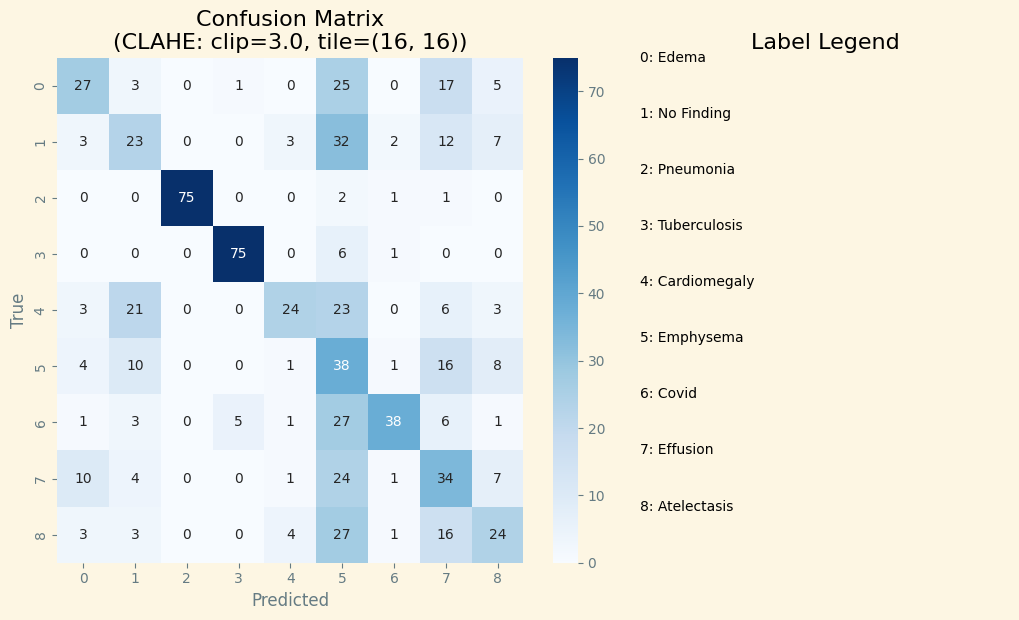

Accuracy for Validation Set = 0.49722222222222223
F1 Score for Validation Set = 0.5145858717925139
Training with CLAHE settings: clip_limit=3.0, tile_grid_size=(32, 32)
#########################
### Fold 1
### train size 2880, valid size 720
#########################
Epoch 1/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 120s 492ms/step - accuracy: 0.3307 - loss: 2.2449 - temp_f1_score: 0.1929 - val_accuracy: 0.3500 - val_loss: 2.4837 - val_temp_f1_score: 0.2324 - learning_rate: 0.0010
Epoch 2/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 88s 473ms/step - accuracy: 0.4725 - loss: 1.7509 - temp_f1_score: 0.2831 - val_accuracy: 0.4139 - val_loss: 2.0037 - val_temp_f1_score: 0.3003 - learning_rate: 0.0010
Epoch 3/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 88s 475ms/step - accuracy: 0.5112 - loss: 1.7090 - temp_f1_score: 0.3168 - val_accuracy: 0.5389 - val_loss: 1.7259 - val_temp_f1_score: 0.3948 - learning_rate: 0.0010
Epoch 4/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 88s 471ms/step - accuracy: 0.5576 - loss: 1.6454 - temp_f1_score: 0.33

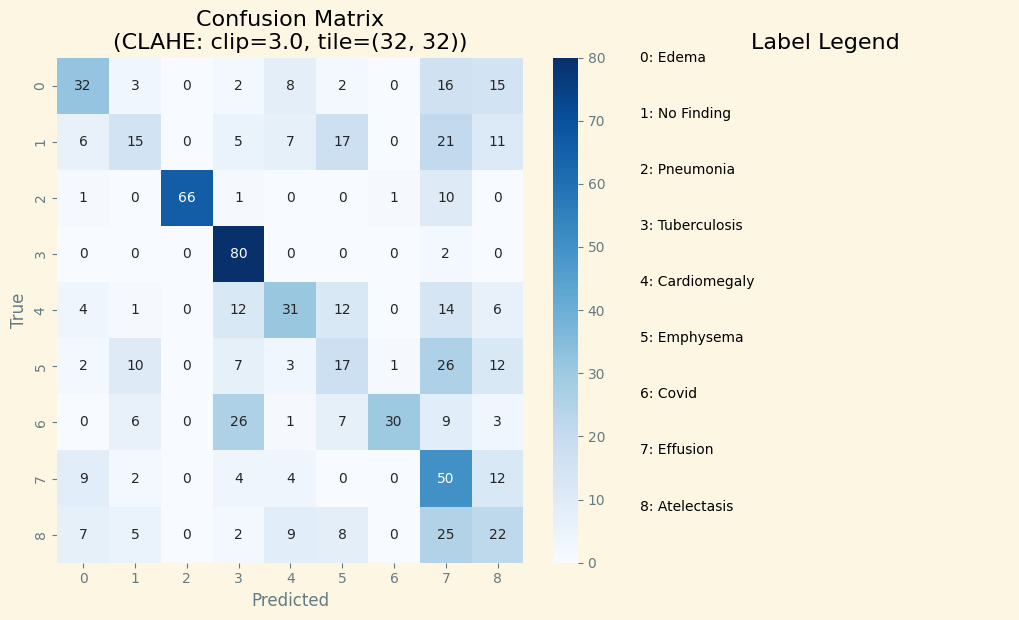

Accuracy for Validation Set = 0.47638888888888886
F1 Score for Validation Set = 0.46757124317212134
Training with CLAHE settings: clip_limit=4.0, tile_grid_size=(4, 4)
#########################
### Fold 1
### train size 2880, valid size 720
#########################
Epoch 1/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 120s 489ms/step - accuracy: 0.3435 - loss: 2.1875 - temp_f1_score: 0.2036 - val_accuracy: 0.4250 - val_loss: 2.0898 - val_temp_f1_score: 0.3002 - learning_rate: 0.0010
Epoch 2/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 86s 464ms/step - accuracy: 0.4690 - loss: 1.7612 - temp_f1_score: 0.2774 - val_accuracy: 0.3167 - val_loss: 2.4136 - val_temp_f1_score: 0.2051 - learning_rate: 0.0010
Epoch 3/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 142s 467ms/step - accuracy: 0.5157 - loss: 1.6878 - temp_f1_score: 0.3148 - val_accuracy: 0.4778 - val_loss: 2.0544 - val_temp_f1_score: 0.3225 - learning_rate: 0.0010
Epoch 4/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 86s 463ms/step - accuracy: 0.5706 - loss: 1.6324 - temp_f1_score: 0.35

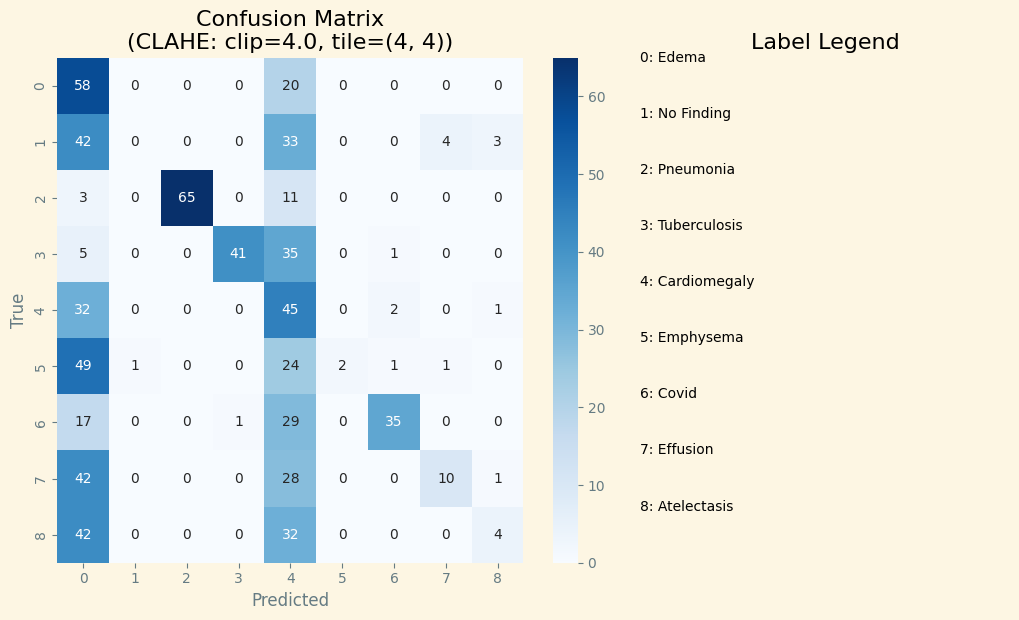

Accuracy for Validation Set = 0.3611111111111111
F1 Score for Validation Set = 0.34168306213543154
Training with CLAHE settings: clip_limit=4.0, tile_grid_size=(8, 8)
#########################
### Fold 1
### train size 2880, valid size 720
#########################
Epoch 1/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 120s 488ms/step - accuracy: 0.3354 - loss: 2.2459 - temp_f1_score: 0.1940 - val_accuracy: 0.3361 - val_loss: 4.0301 - val_temp_f1_score: 0.1606 - learning_rate: 0.0010
Epoch 2/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 86s 463ms/step - accuracy: 0.4745 - loss: 1.7529 - temp_f1_score: 0.2785 - val_accuracy: 0.4917 - val_loss: 1.8148 - val_temp_f1_score: 0.3744 - learning_rate: 0.0010
Epoch 3/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 87s 471ms/step - accuracy: 0.5256 - loss: 1.6847 - temp_f1_score: 0.3170 - val_accuracy: 0.3361 - val_loss: 2.3481 - val_temp_f1_score: 0.1933 - learning_rate: 0.0010
Epoch 4/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 87s 468ms/step - accuracy: 0.5577 - loss: 1.6175 - temp_f1_score: 0.3381

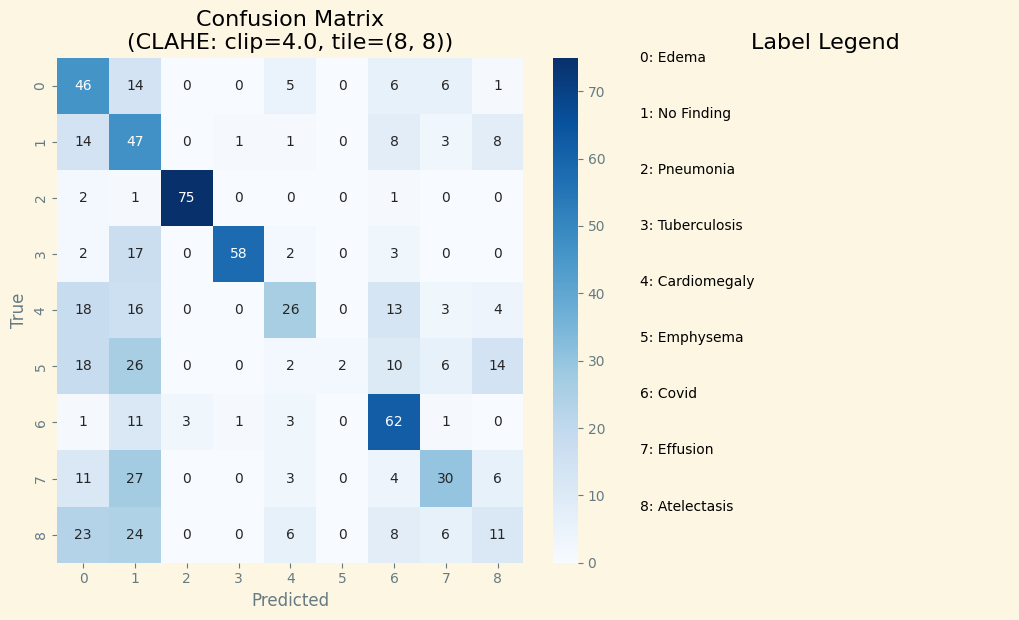

Accuracy for Validation Set = 0.49583333333333335
F1 Score for Validation Set = 0.4740170276396575
Training with CLAHE settings: clip_limit=4.0, tile_grid_size=(16, 16)
#########################
### Fold 1
### train size 2880, valid size 720
#########################
Epoch 1/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 121s 493ms/step - accuracy: 0.3334 - loss: 2.1778 - temp_f1_score: 0.1925 - val_accuracy: 0.4083 - val_loss: 2.1023 - val_temp_f1_score: 0.2778 - learning_rate: 0.0010
Epoch 2/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 88s 475ms/step - accuracy: 0.4896 - loss: 1.7412 - temp_f1_score: 0.2945 - val_accuracy: 0.3250 - val_loss: 2.5167 - val_temp_f1_score: 0.2031 - learning_rate: 0.0010
Epoch 3/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 88s 473ms/step - accuracy: 0.5197 - loss: 1.6803 - temp_f1_score: 0.3157 - val_accuracy: 0.5028 - val_loss: 1.8751 - val_temp_f1_score: 0.3539 - learning_rate: 0.0010
Epoch 4/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 88s 472ms/step - accuracy: 0.5526 - loss: 1.6549 - temp_f1_score: 0.33

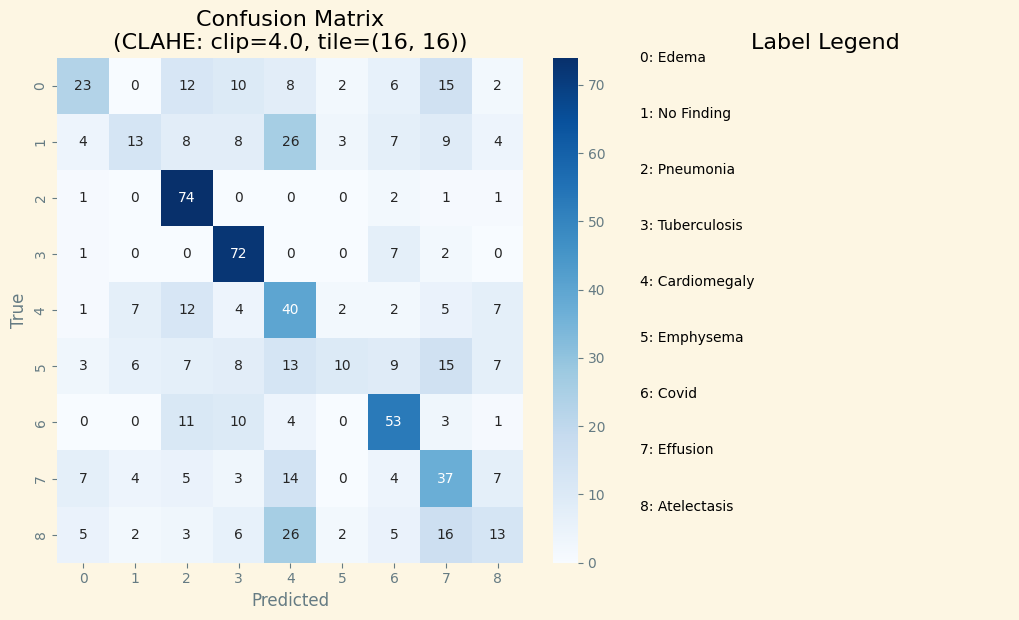

Accuracy for Validation Set = 0.4652777777777778
F1 Score for Validation Set = 0.42398649386490006
Training with CLAHE settings: clip_limit=4.0, tile_grid_size=(32, 32)
#########################
### Fold 1
### train size 2880, valid size 720
#########################
Epoch 1/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 122s 499ms/step - accuracy: 0.3396 - loss: 2.1734 - temp_f1_score: 0.2026 - val_accuracy: 0.2833 - val_loss: 3.7480 - val_temp_f1_score: 0.1264 - learning_rate: 0.0010
Epoch 2/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 87s 472ms/step - accuracy: 0.4730 - loss: 1.7403 - temp_f1_score: 0.2762 - val_accuracy: 0.4306 - val_loss: 1.9781 - val_temp_f1_score: 0.3178 - learning_rate: 0.0010
Epoch 3/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 88s 471ms/step - accuracy: 0.5532 - loss: 1.6658 - temp_f1_score: 0.3301 - val_accuracy: 0.2417 - val_loss: 3.0633 - val_temp_f1_score: 0.1444 - learning_rate: 0.0010
Epoch 4/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 89s 479ms/step - accuracy: 0.5678 - loss: 1.6122 - temp_f1_score: 0.34

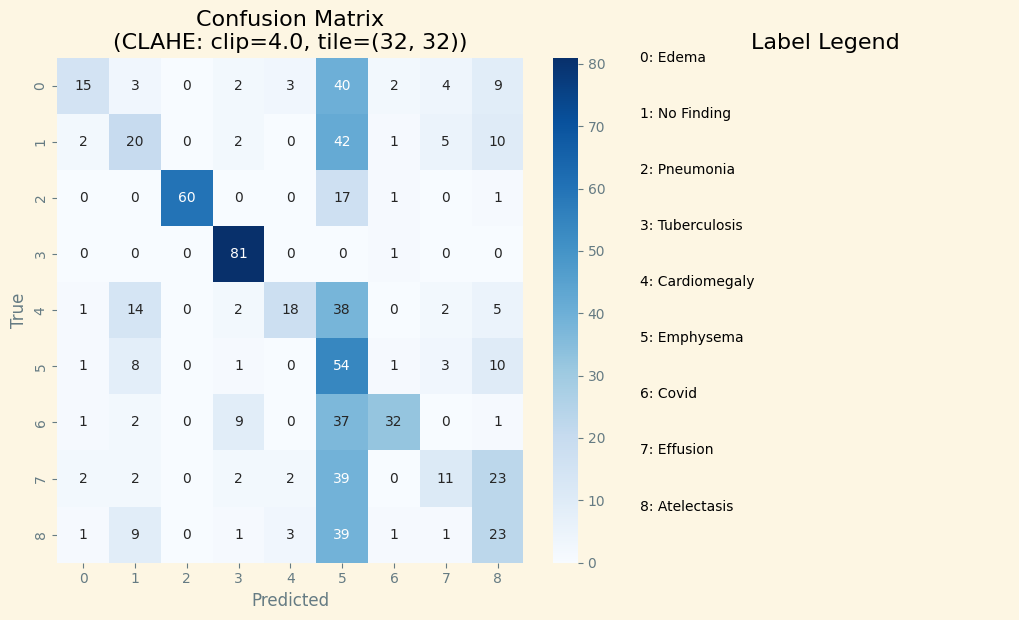

Accuracy for Validation Set = 0.4361111111111111
F1 Score for Validation Set = 0.4421187743657908


In [26]:
import tensorflow.keras.backend as K
from collections import defaultdict

clip_limits = [2.0,3.0,4.0]
tile_grid_sizes = [(4,4),(8,8),(16,16),(32,32)]
results = []


for clip_limit in clip_limits:
    for tile_grid_size in tile_grid_sizes:
        print(f"Training with CLAHE settings: clip_limit={clip_limit}, tile_grid_size={tile_grid_size}")
        
        all_oof = []
        all_true = []
        all_index = []
        all_history = defaultdict(list)

        for i in range(1):  # 나중에 fold 수를 변경할 수 있도록 유지
            print('#'*25)
            print(f'### Fold {i+1}')
            
            train_gen = DataGenerator(df_train[df_train['Fold'] != i], shuffle=True, augment1=True, augment2=False, 
                                      batch_size=16, preprocess=preprocess_input, 
                                      clip_limit=clip_limit, tile_grid_size=tile_grid_size)
            valid_gen = DataGenerator(df_train[df_train['Fold'] == i], shuffle=False,
                                      batch_size=32, preprocess=preprocess_input,
                                      clip_limit=clip_limit, tile_grid_size=tile_grid_size)
            
            print(f'### train size {len(df_train[df_train["Fold"] != i])}, valid size {len(df_train[df_train["Fold"] == i])}')
            print('#'*25)
            
            K.clear_session()
            with strategy.scope():
                model = build_model()
            
            if LOAD_MODELS_FROM is None:
                history = model.fit(train_gen, verbose=1,
                          validation_data=valid_gen,
                          epochs=EPOCHS, callbacks=[lr])
                model.save_weights(f'ResNet_f{i}_clip{clip_limit}_tile{tile_grid_size[0]}.weights.h5')
                all_history['Train Loss'].append(history.history['loss'])
                all_history['Valid Loss'].append(history.history['val_loss'])
                all_history['Valid F1'].append(history.history['val_temp_f1_score'])
                all_history['Train F1'].append(history.history['temp_f1_score'])
                all_history['Valid Accuracy'].append(history.history['val_accuracy'])
                all_history['Train Accuracy'].append(history.history['accuracy'])
            else:
                model.load_weights(f'{LOAD_MODELS_FROM}ResNet_f{i}_clip{clip_limit}_tile{tile_grid_size[0]}.weights.h5')
            
            oof = model.predict(valid_gen, verbose=1)
            all_oof.append(oof)
            all_true.append(df_train[df_train['Fold'] == i][TARGET].values)
            all_index.append(df_train[df_train['Fold'] == i]['Image Index'].values)
            
            true_labels = np.argmax(df_train[df_train['Fold'] == i][TARGET].values, axis=1)
            pred_labels = np.argmax(oof, axis=1)
            create_confusion_matrix(true_labels, pred_labels, TARGET, clip_limit, tile_grid_size)
            
            del model, oof
            gc.collect()
        
        all_oof = np.concatenate(all_oof)
        all_true = np.concatenate(all_true)
        all_index = np.concatenate(all_index)
        
        # 성능 평가 및 결과 저장
        accuracy = accuracy_score(np.argmax(all_true, axis=1), np.argmax(all_oof, axis=1))
        f1 = f1_score(np.argmax(all_true, axis=1), np.argmax(all_oof, axis=1), average='macro')
        
        print(f'Accuracy for Validation Set = {accuracy}')
        print(f'F1 Score for Validation Set = {f1}')
        
        results.append({
            'clip_limit': clip_limit,
            'tile_grid_size': tile_grid_size,
            'accuracy': accuracy,
            'f1_score': f1,
            'all_history': all_history,
            'all_oof': all_oof,
            'all_true': all_true,
            'all_index': all_index
        })
        
        del train_gen, valid_gen
        gc.collect()

<Figure size 1500x1800 with 0 Axes>

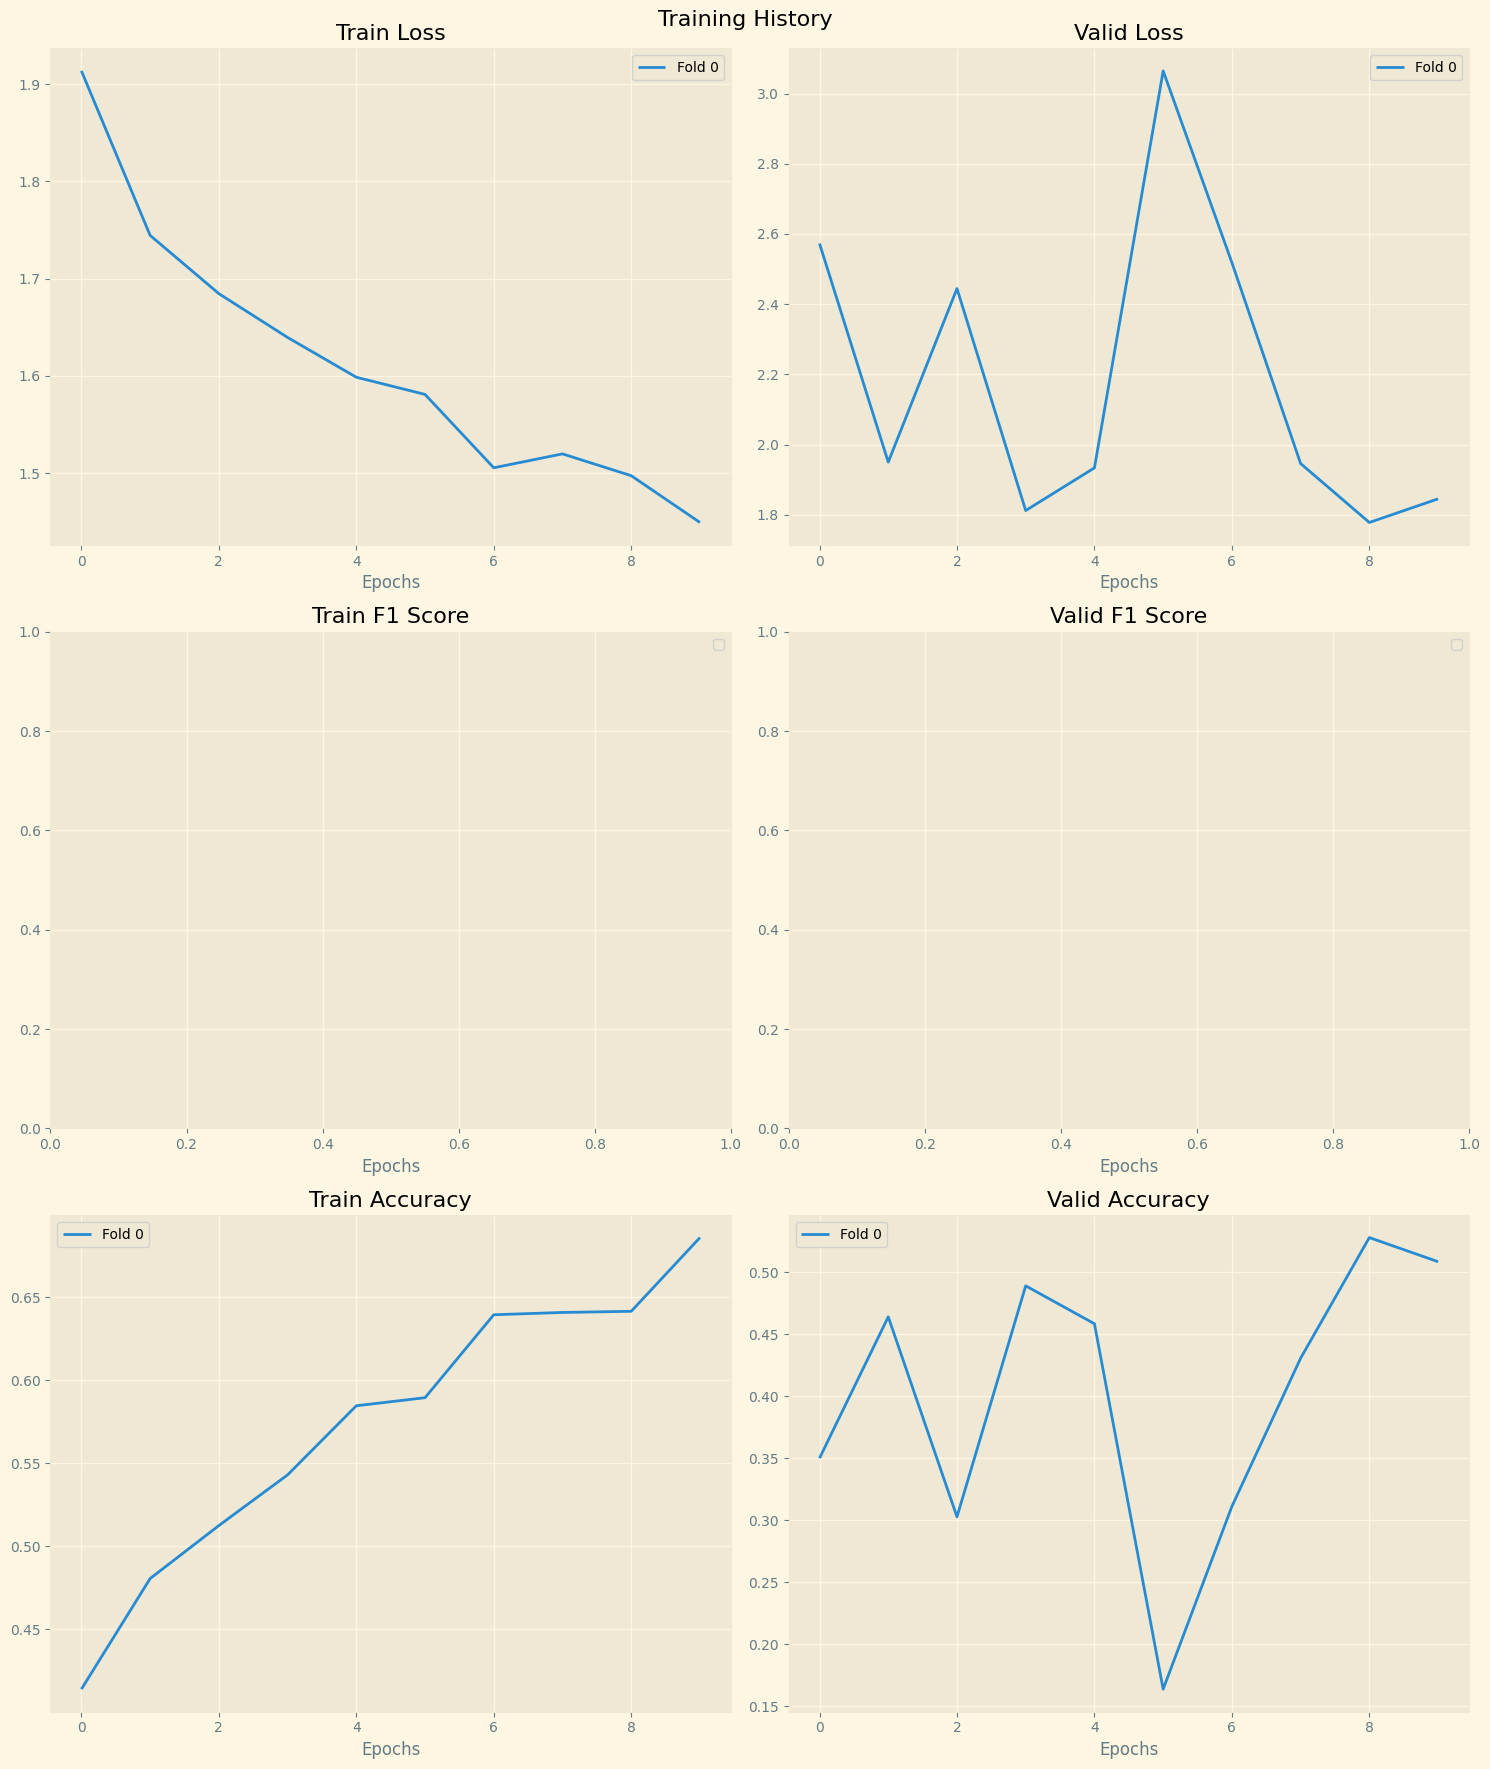

<Figure size 1500x1800 with 0 Axes>

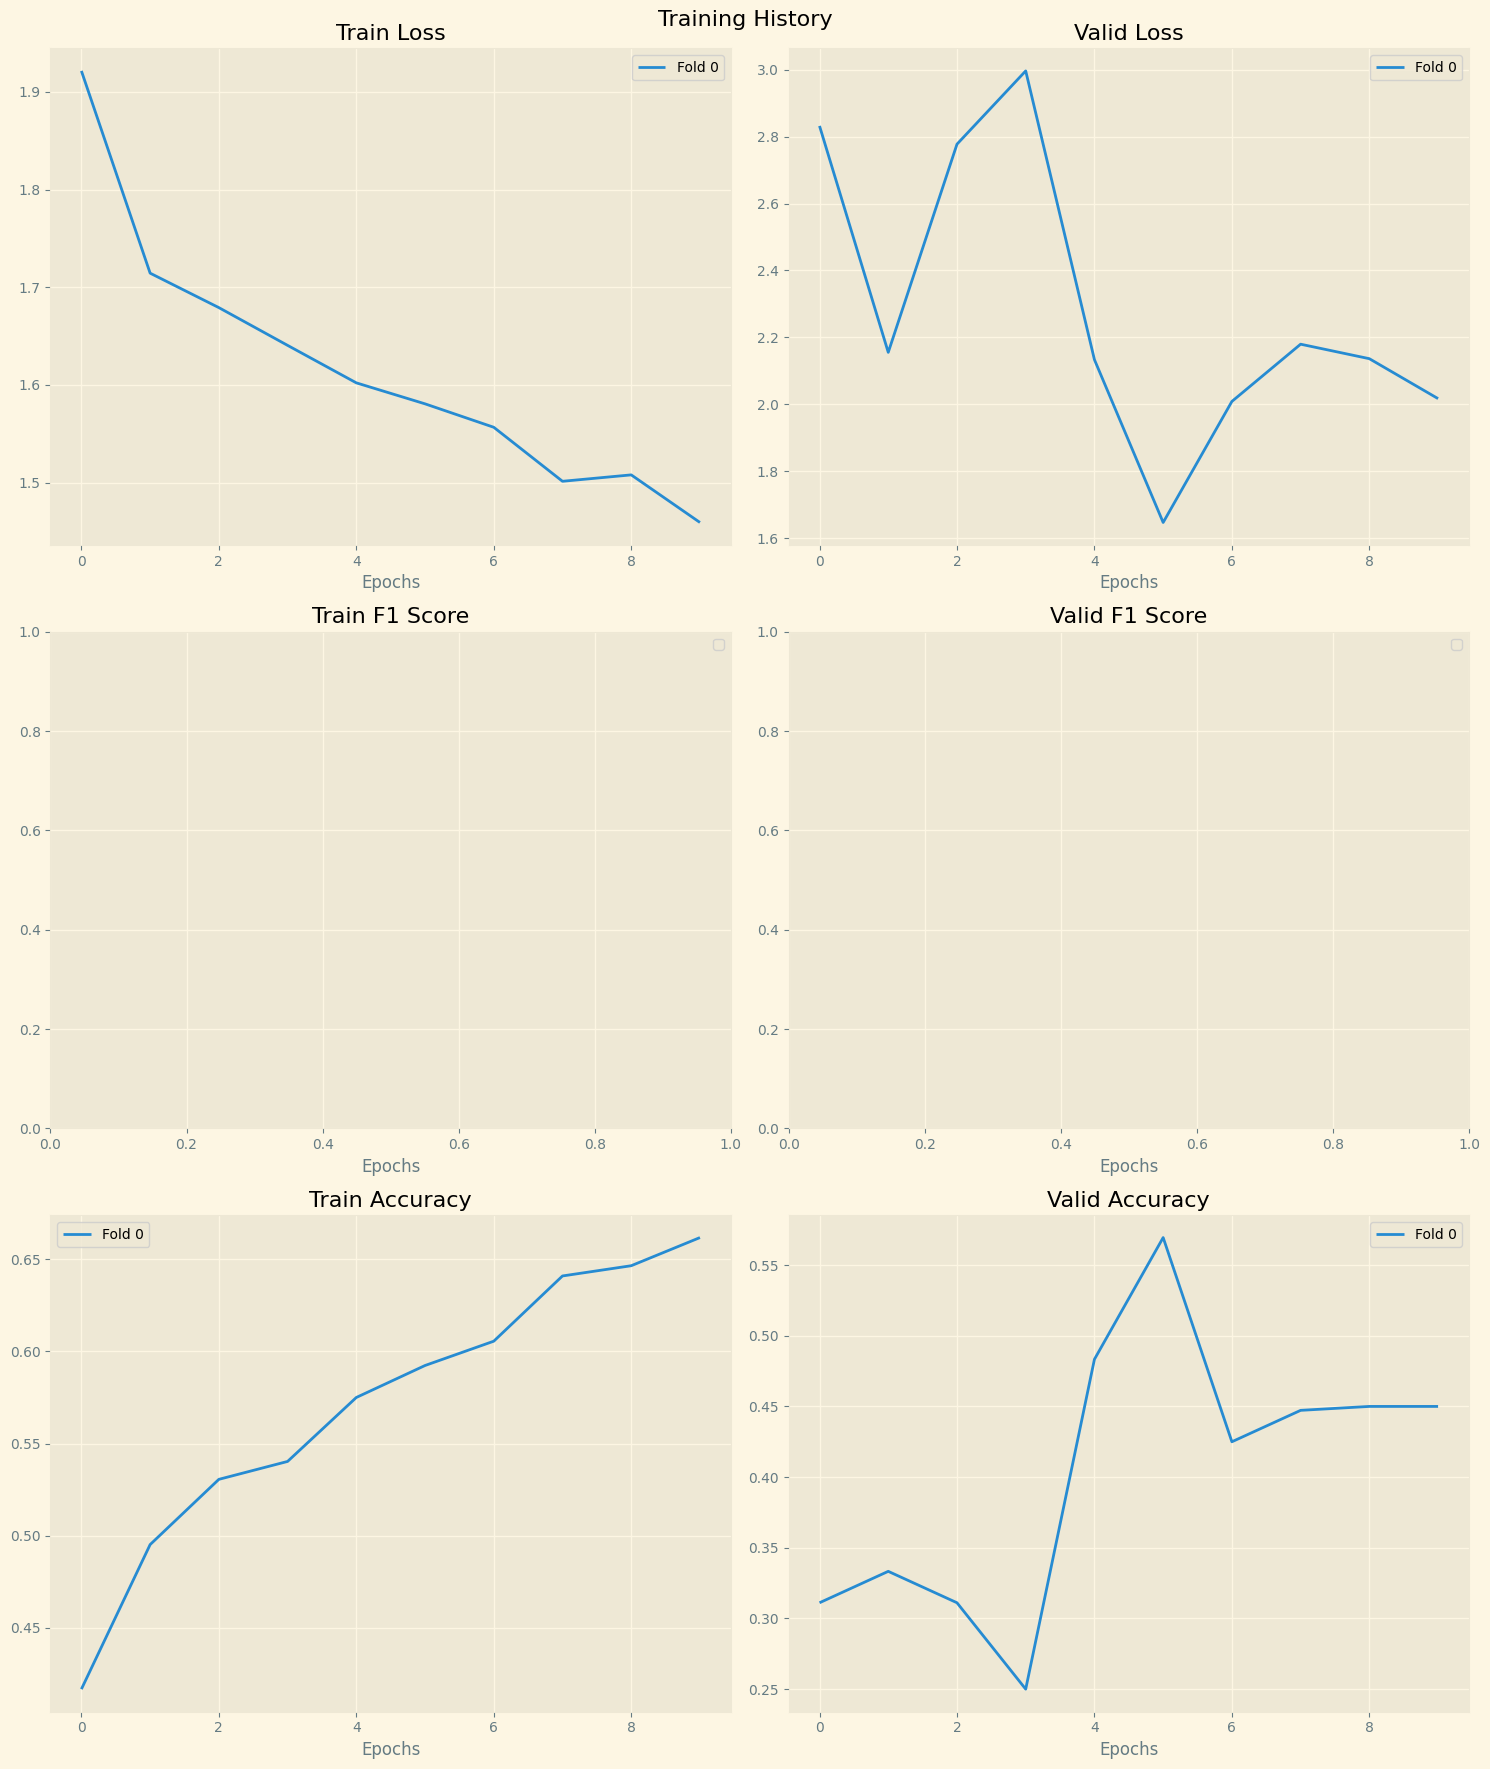

<Figure size 1500x1800 with 0 Axes>

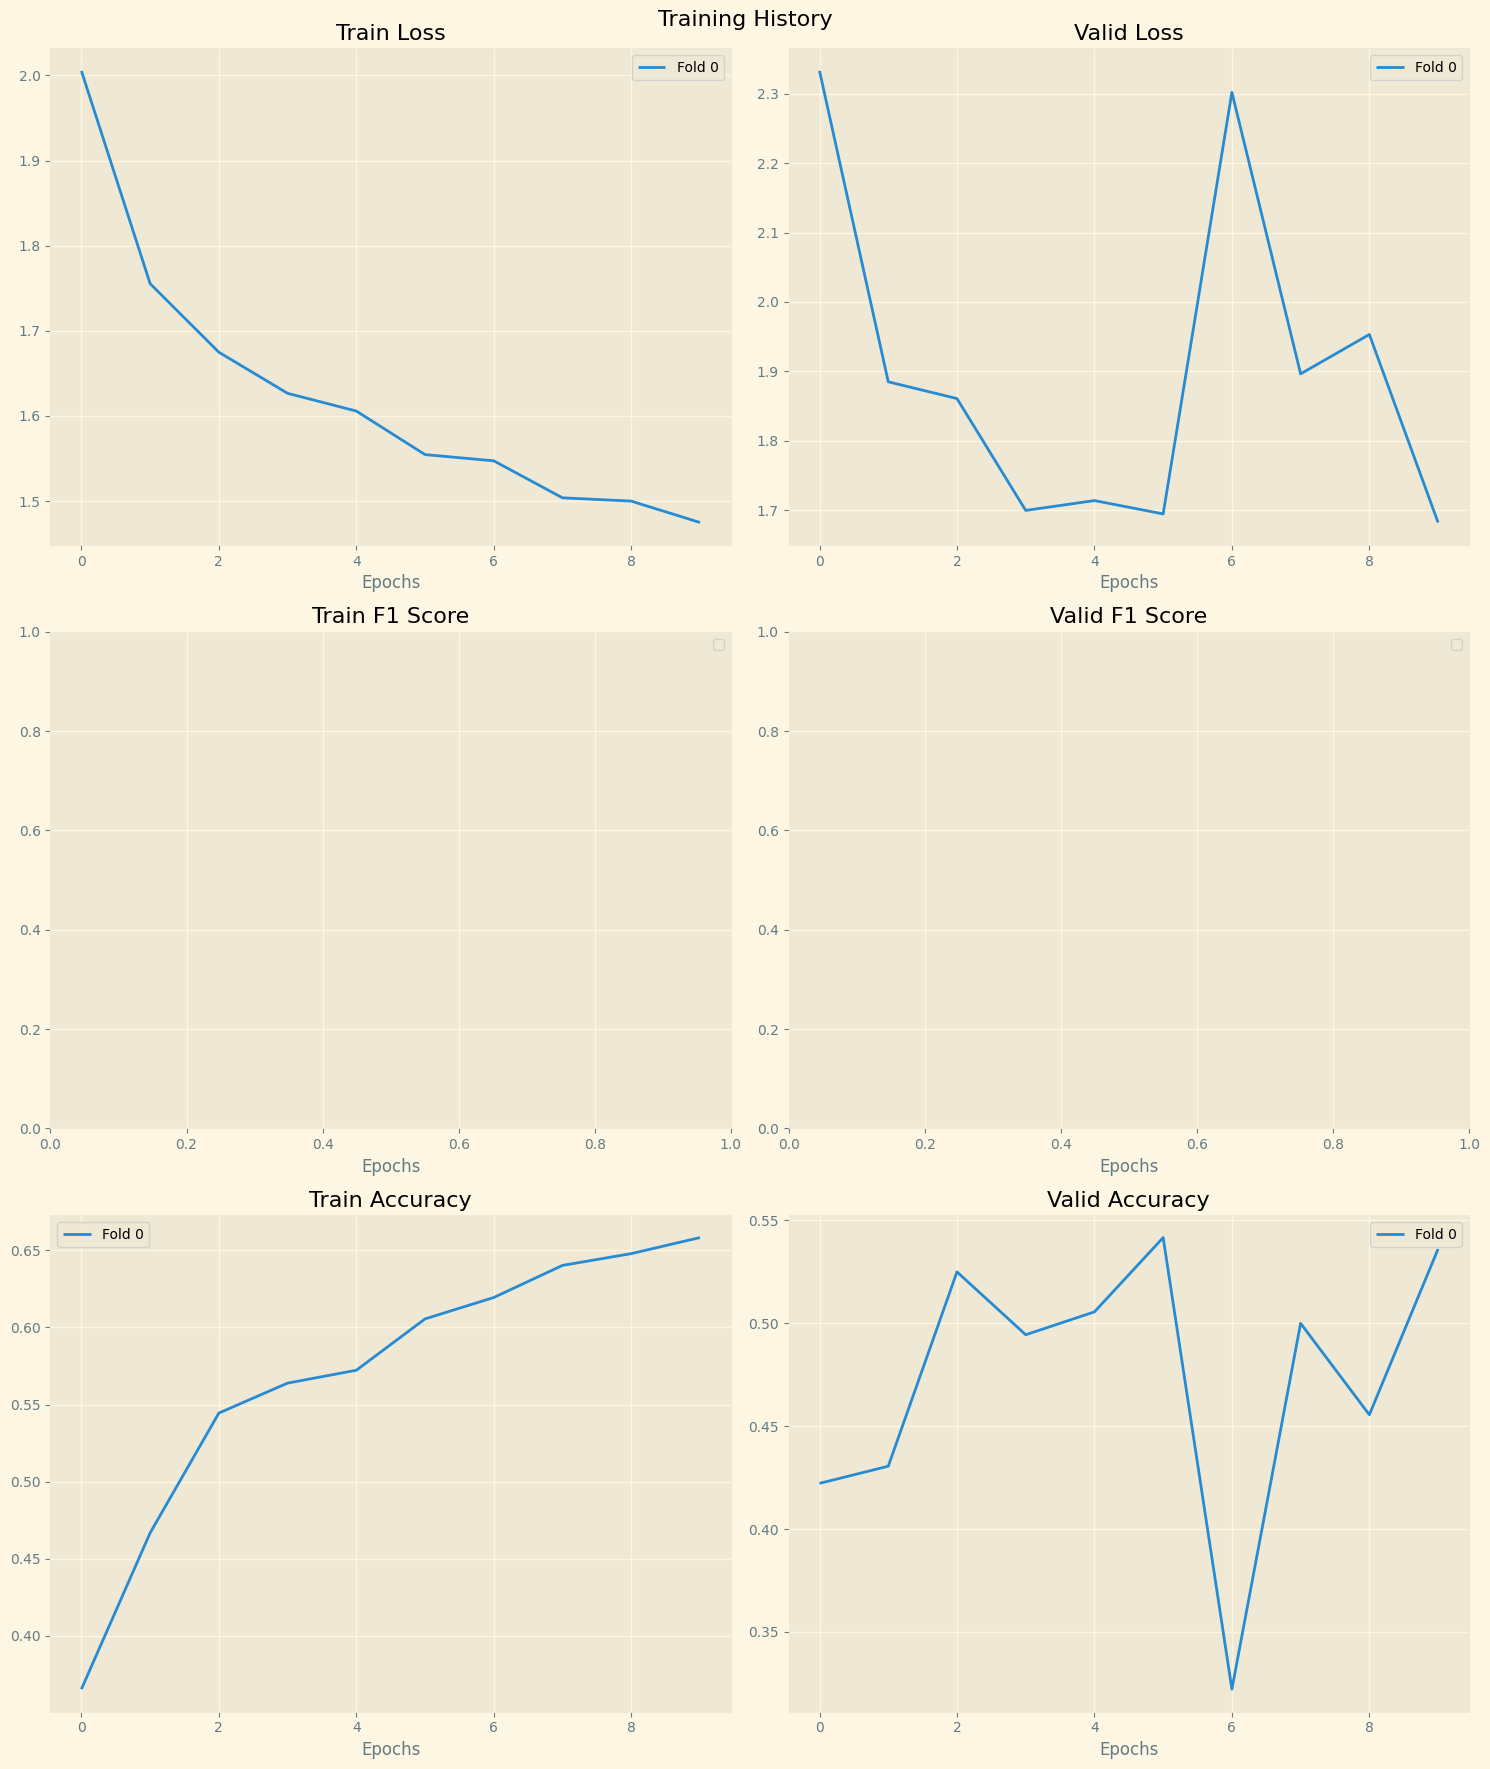

<Figure size 1500x1800 with 0 Axes>

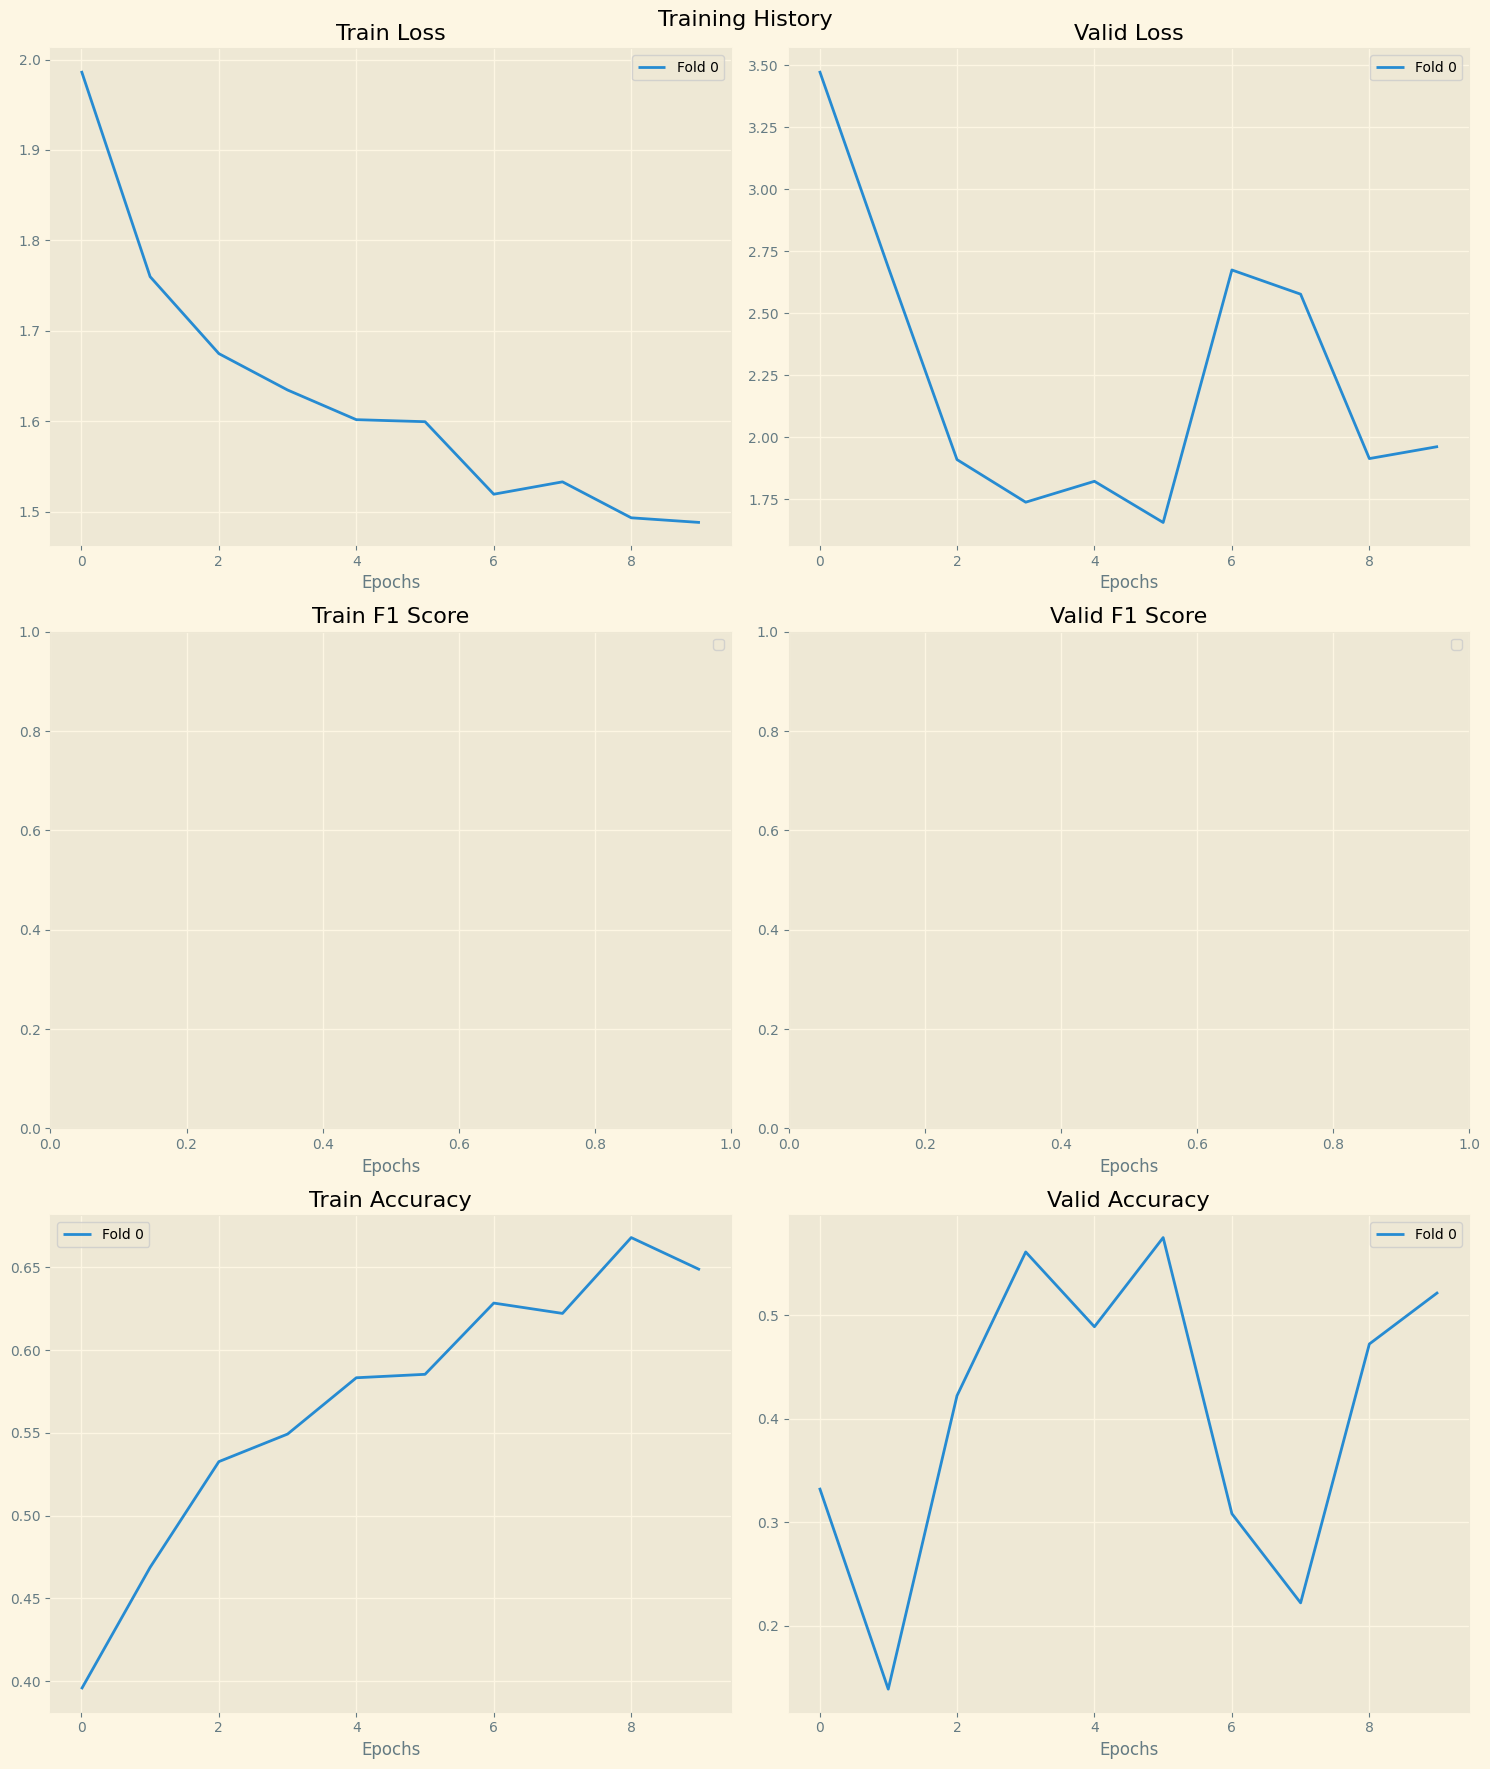

<Figure size 1500x1800 with 0 Axes>

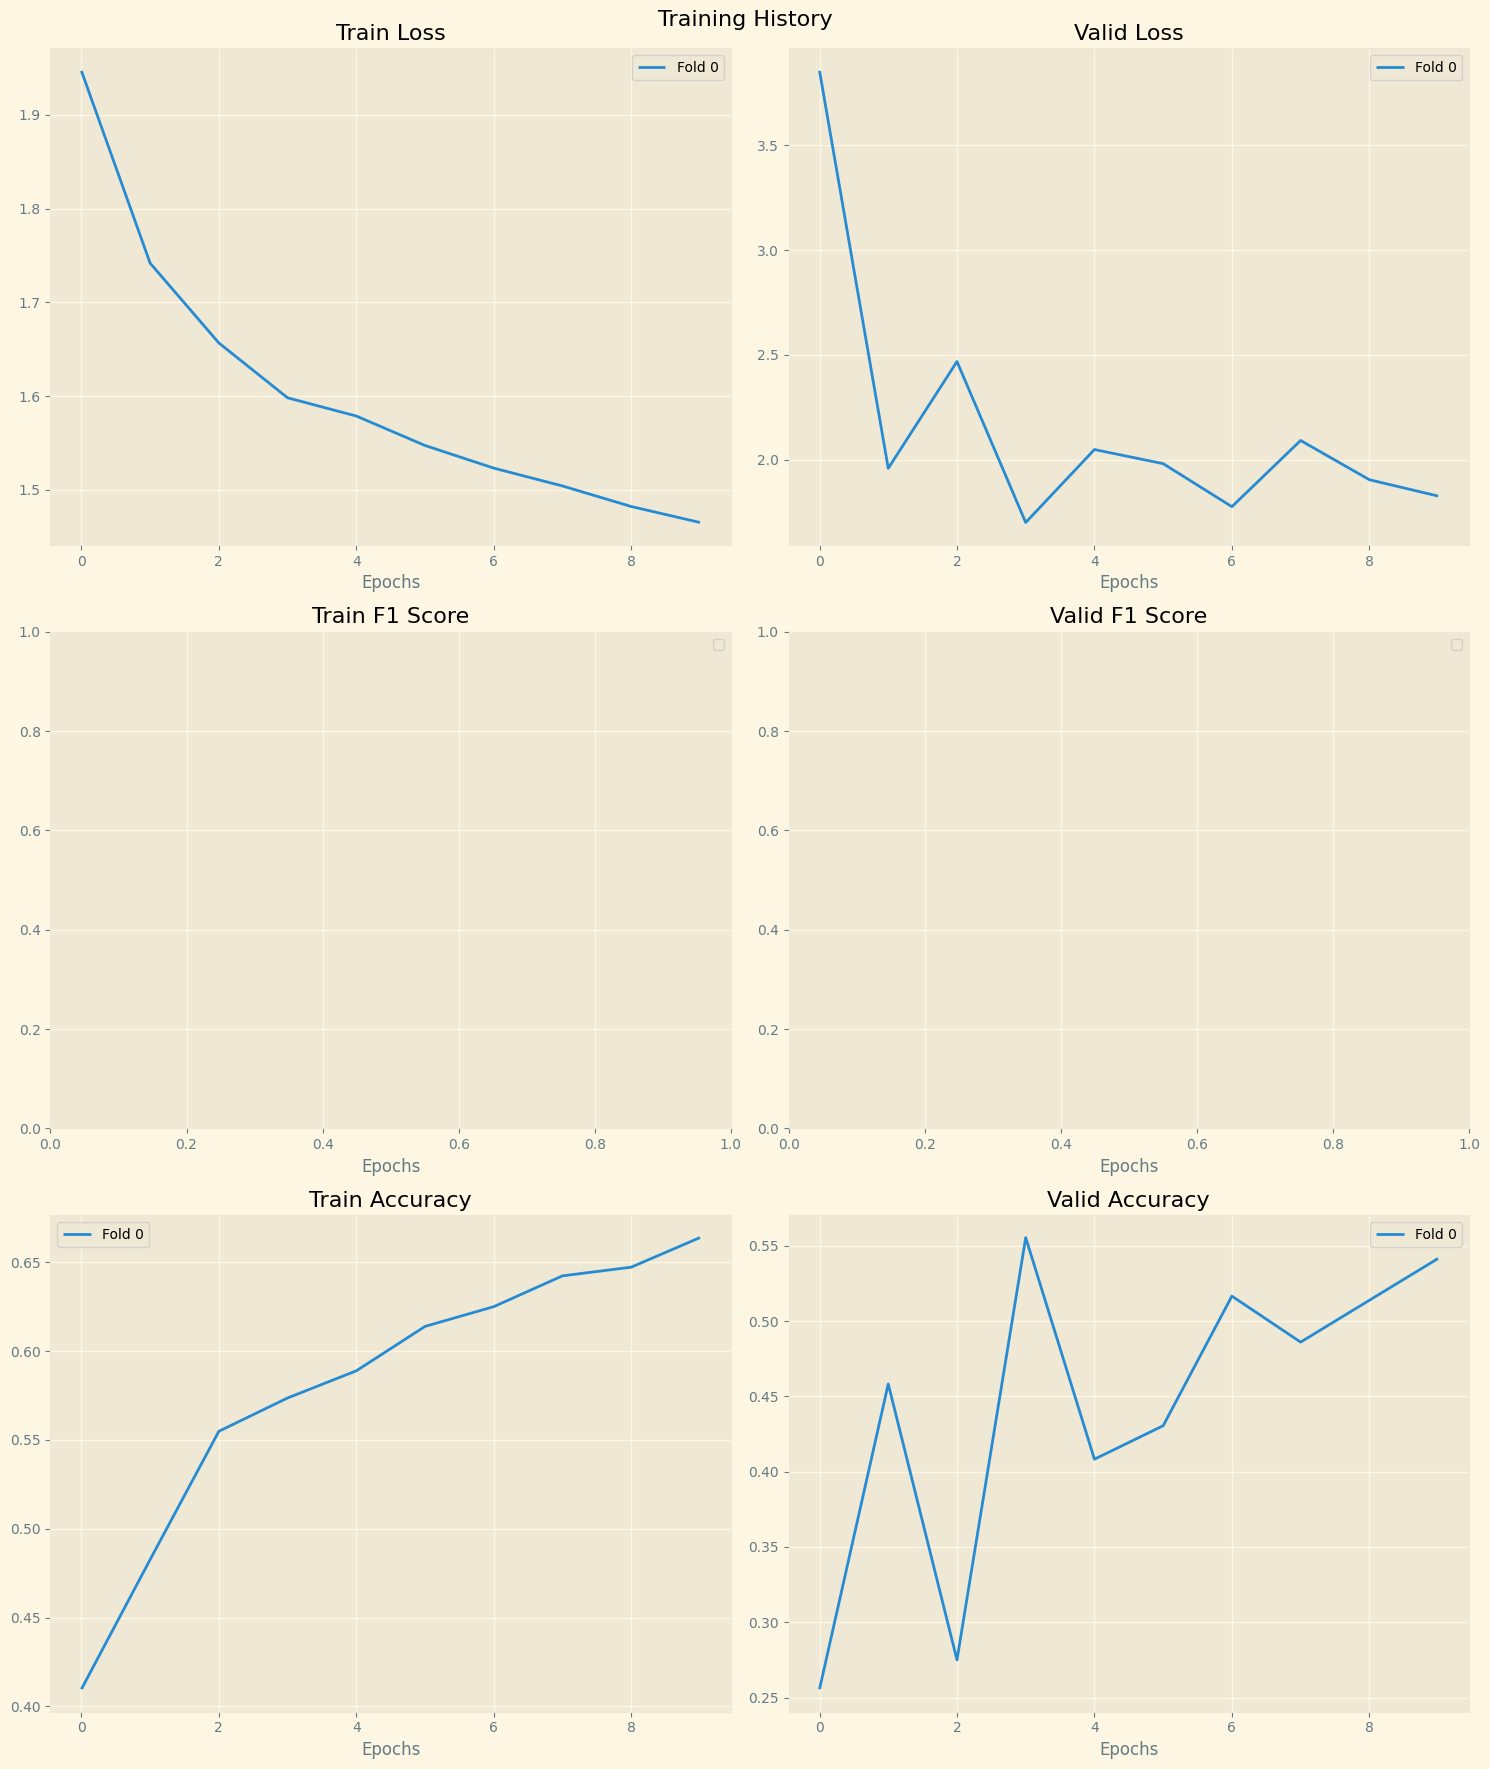

<Figure size 1500x1800 with 0 Axes>

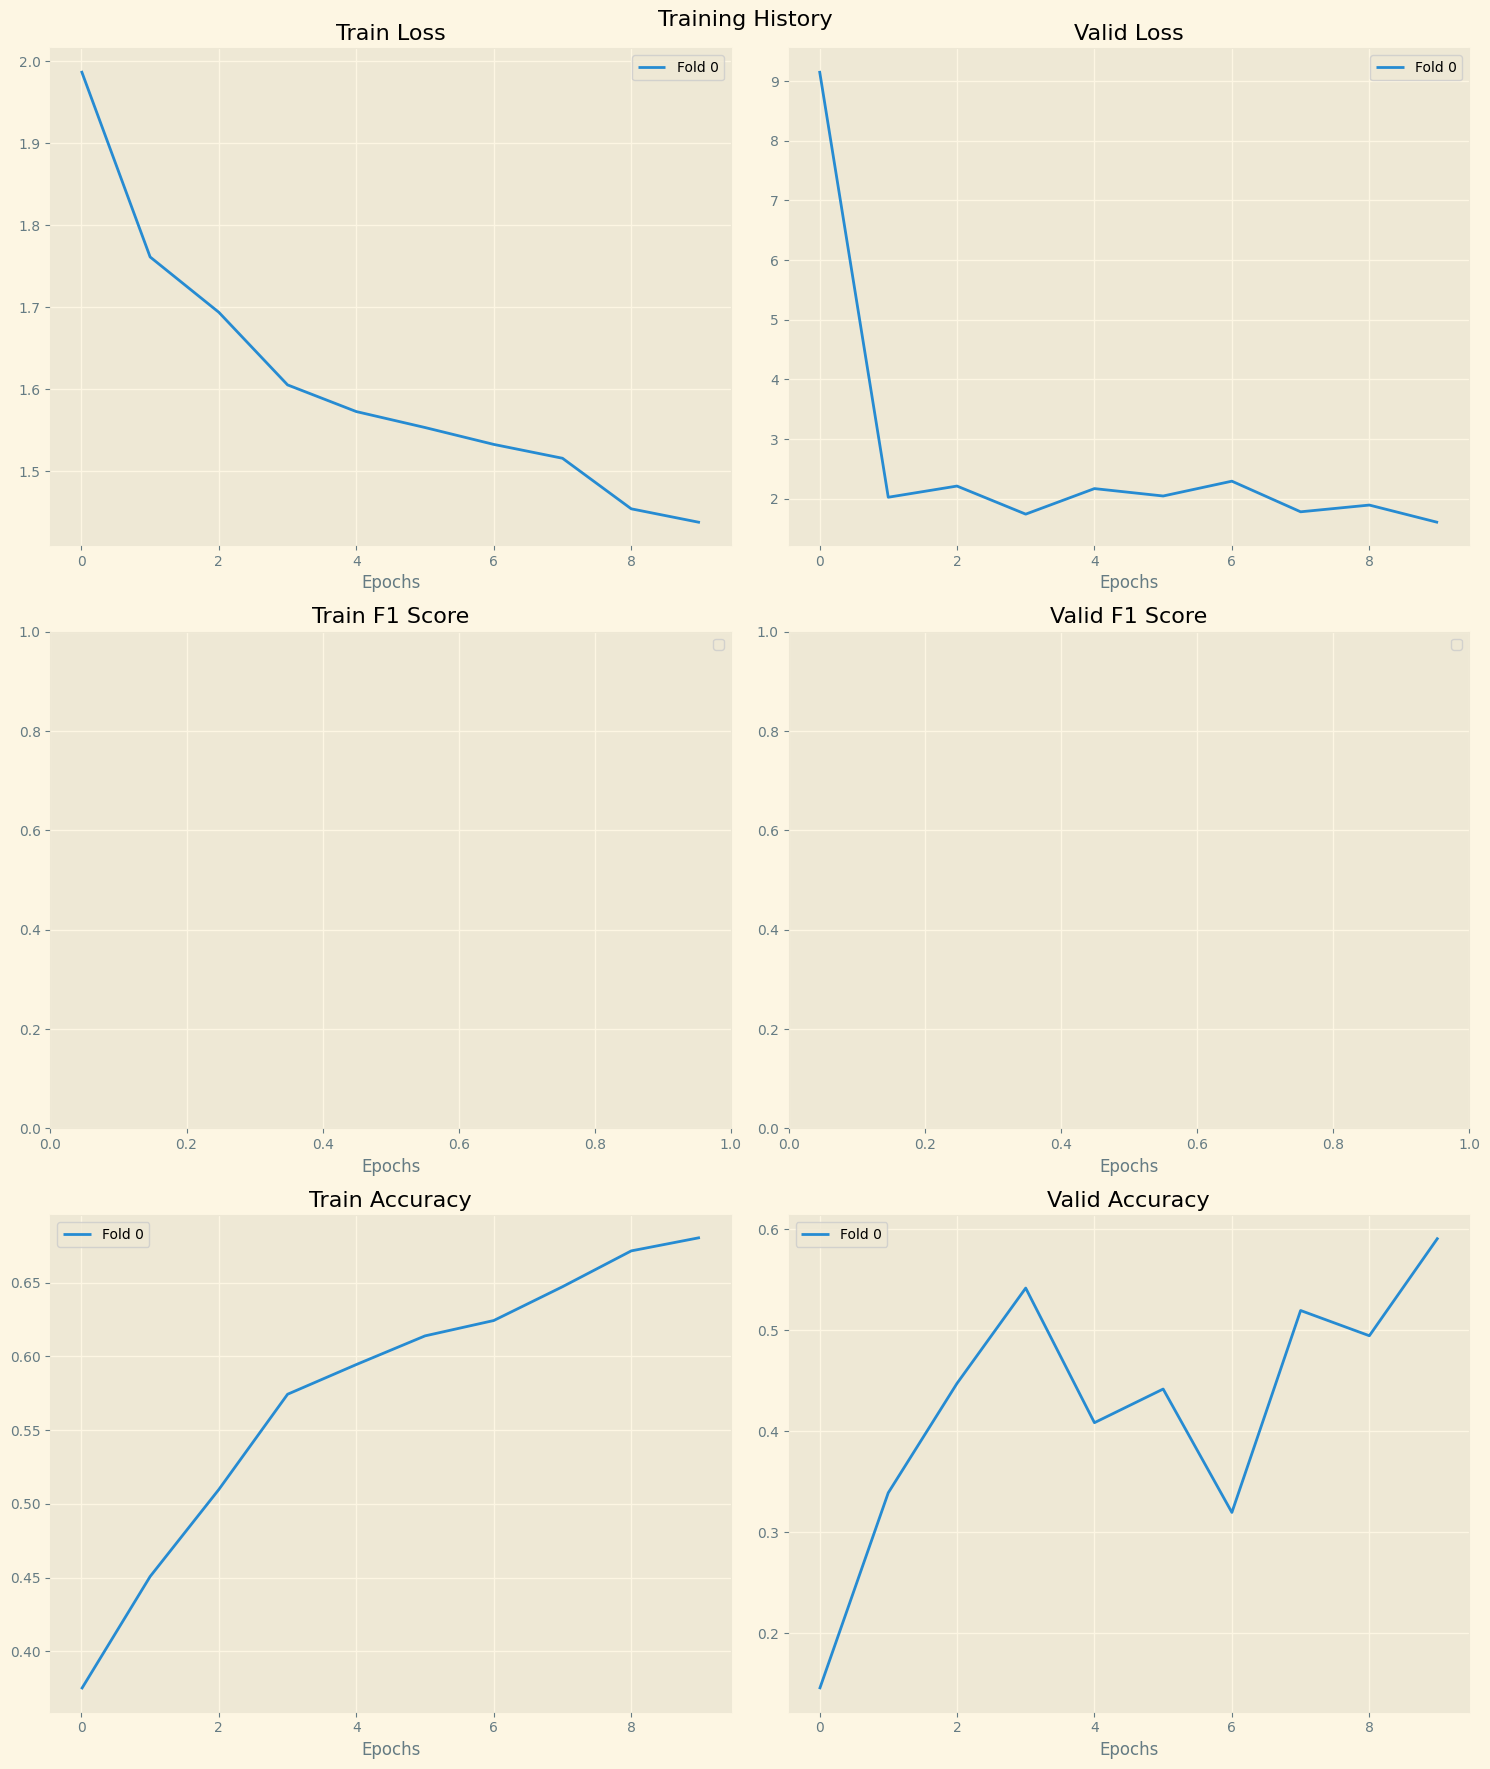

<Figure size 1500x1800 with 0 Axes>

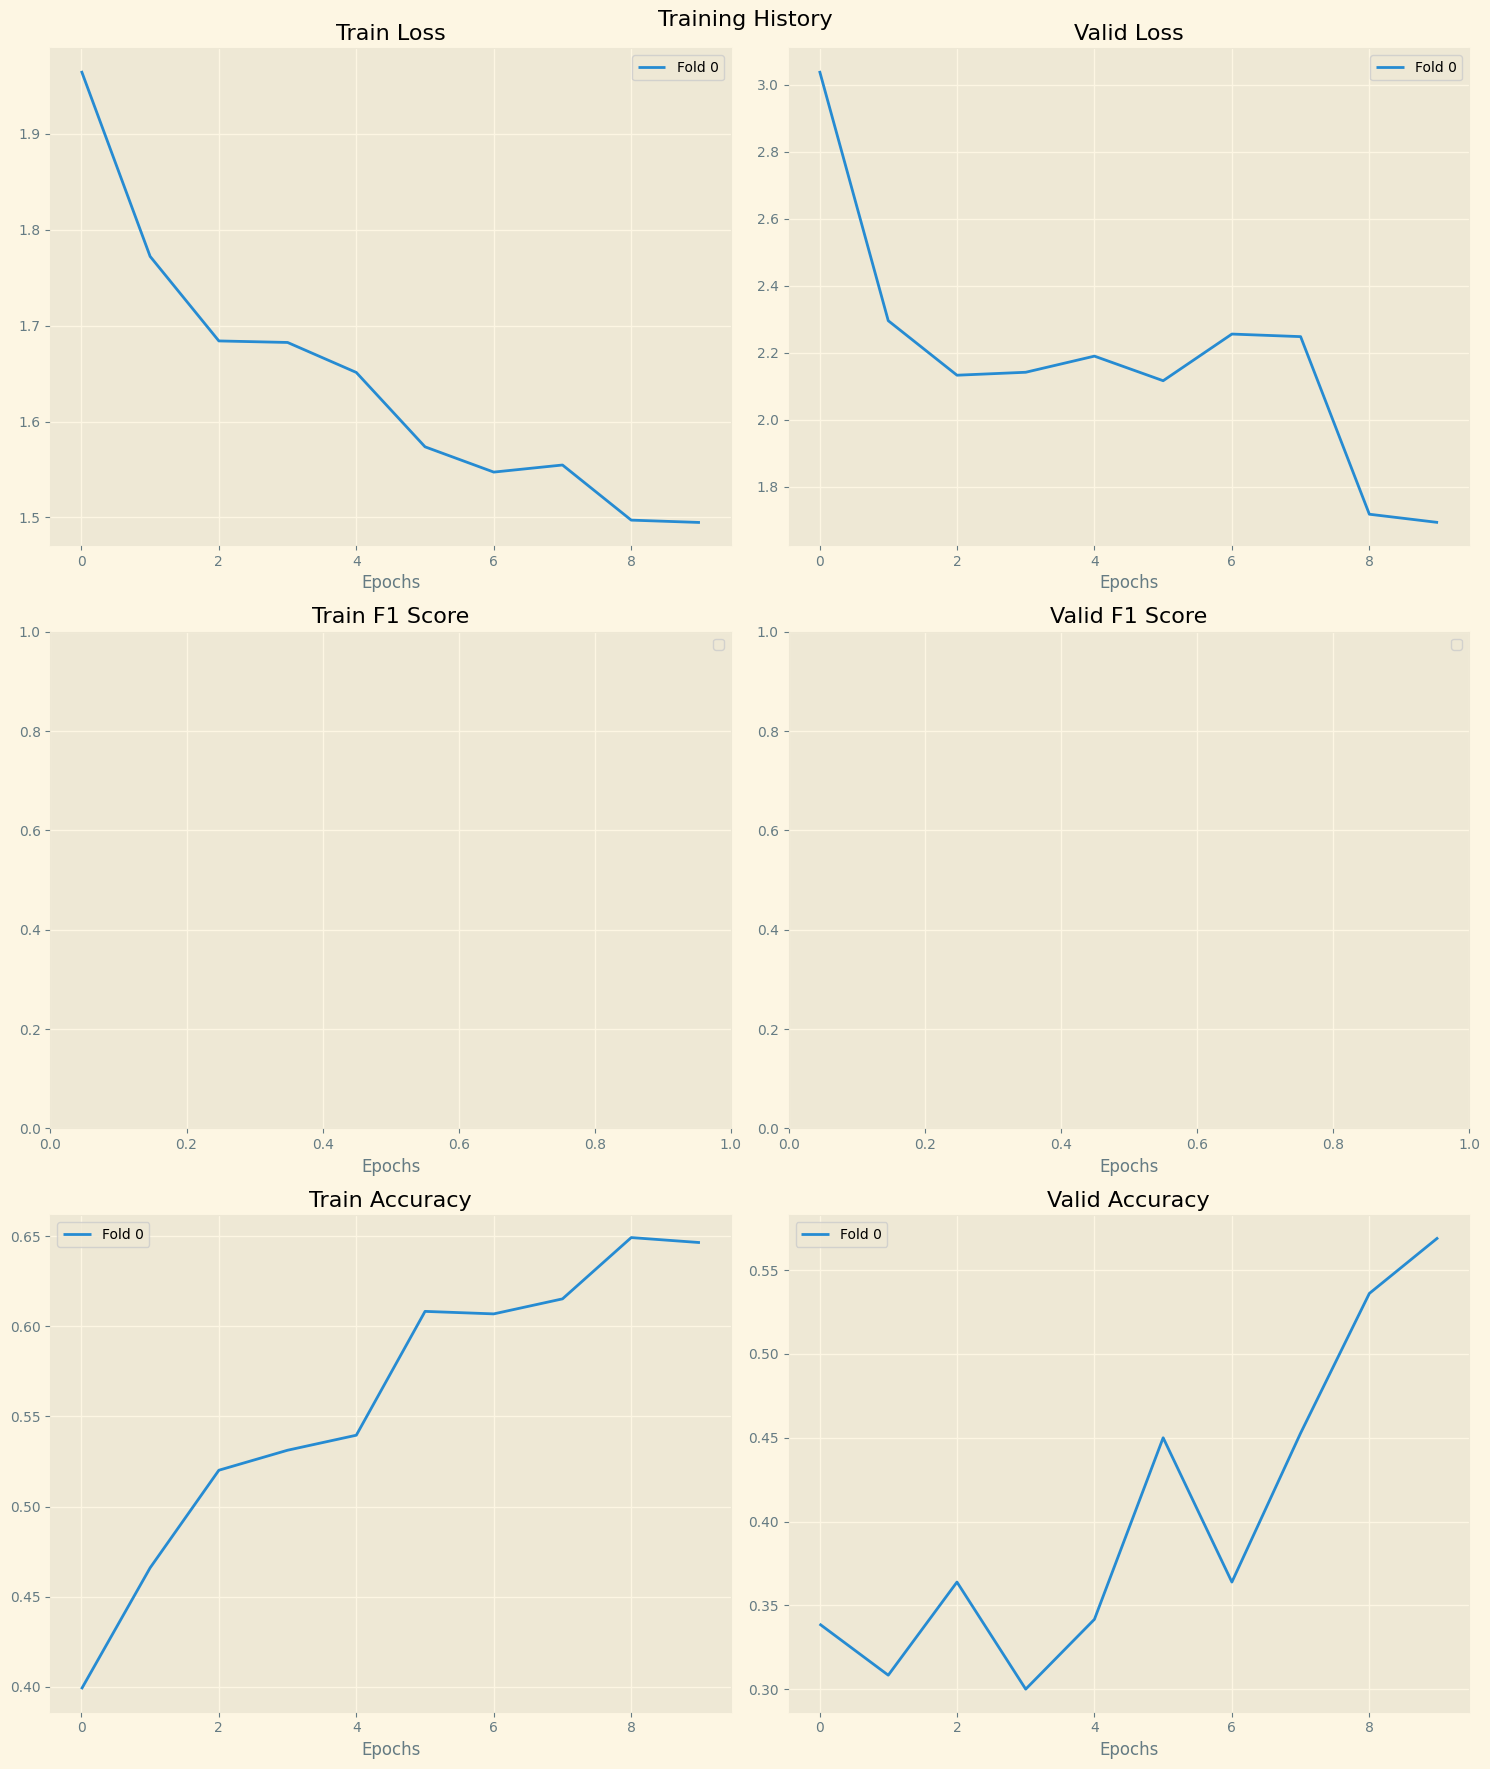

<Figure size 1500x1800 with 0 Axes>

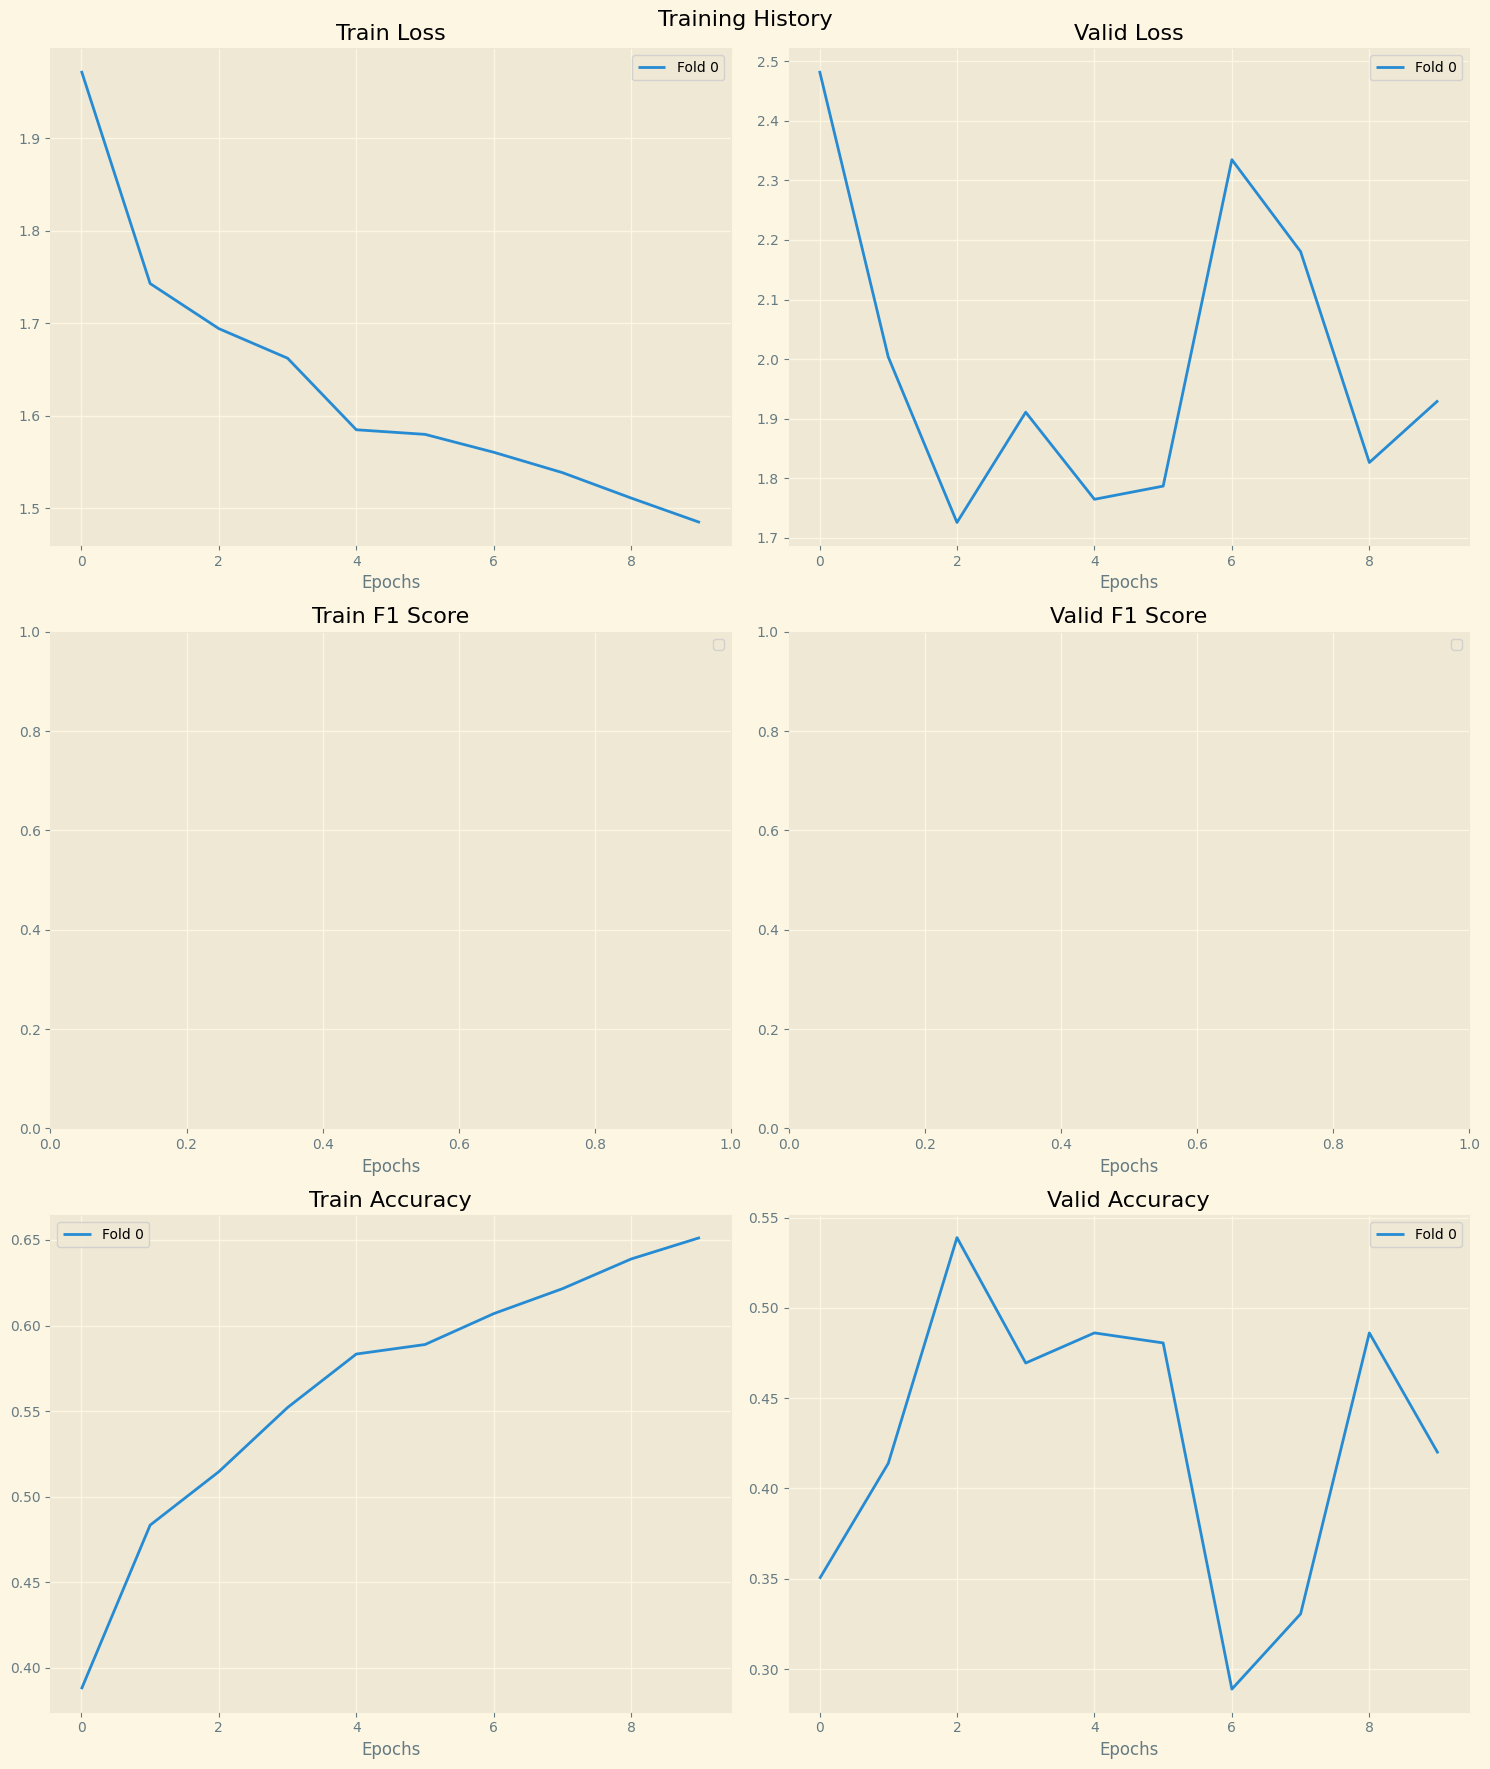

<Figure size 1500x1800 with 0 Axes>

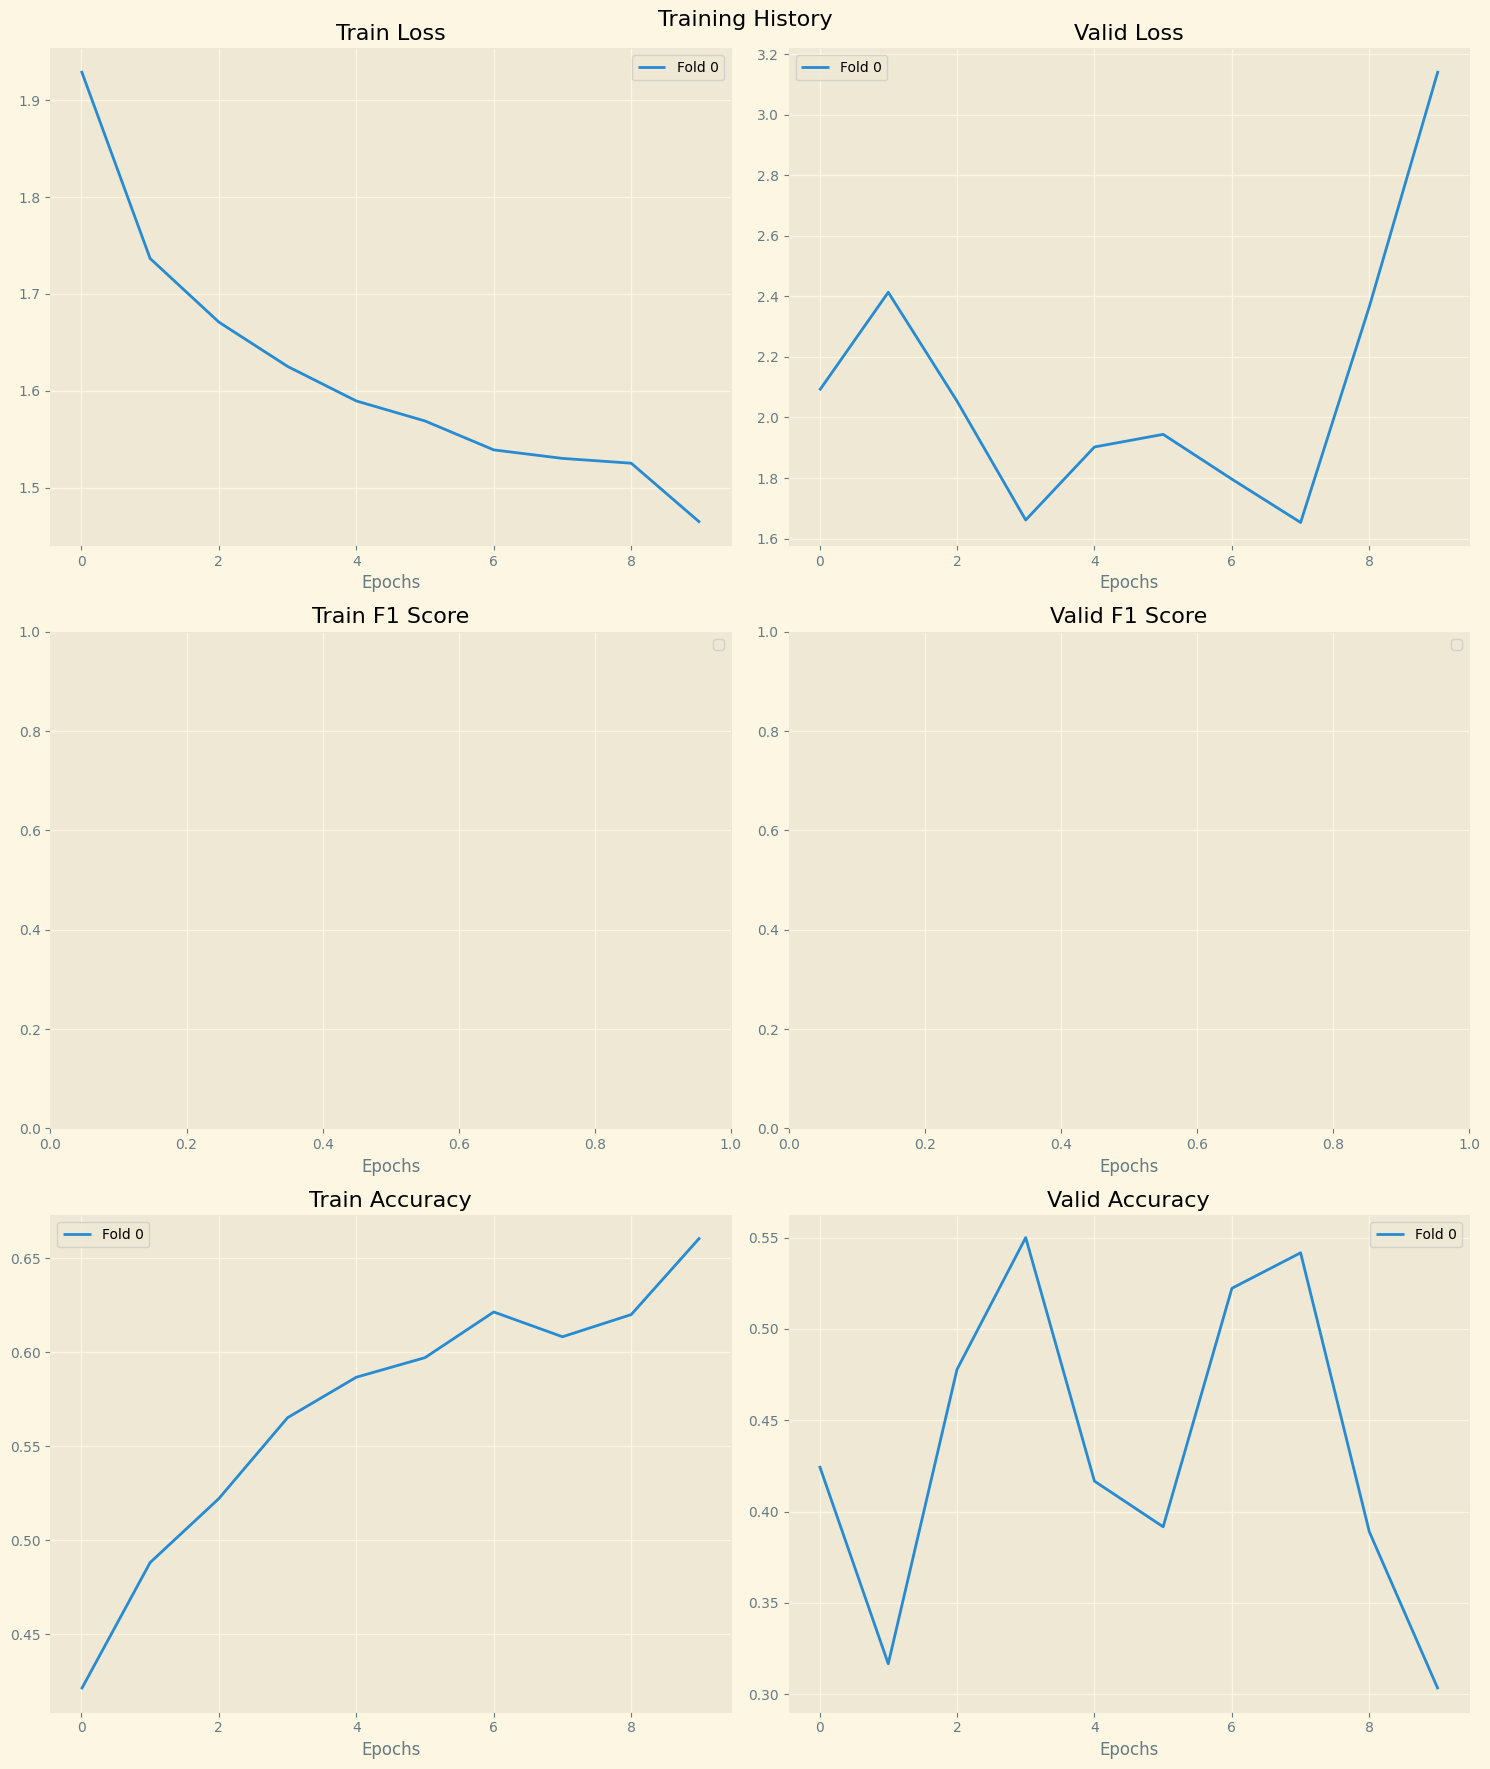

<Figure size 1500x1800 with 0 Axes>

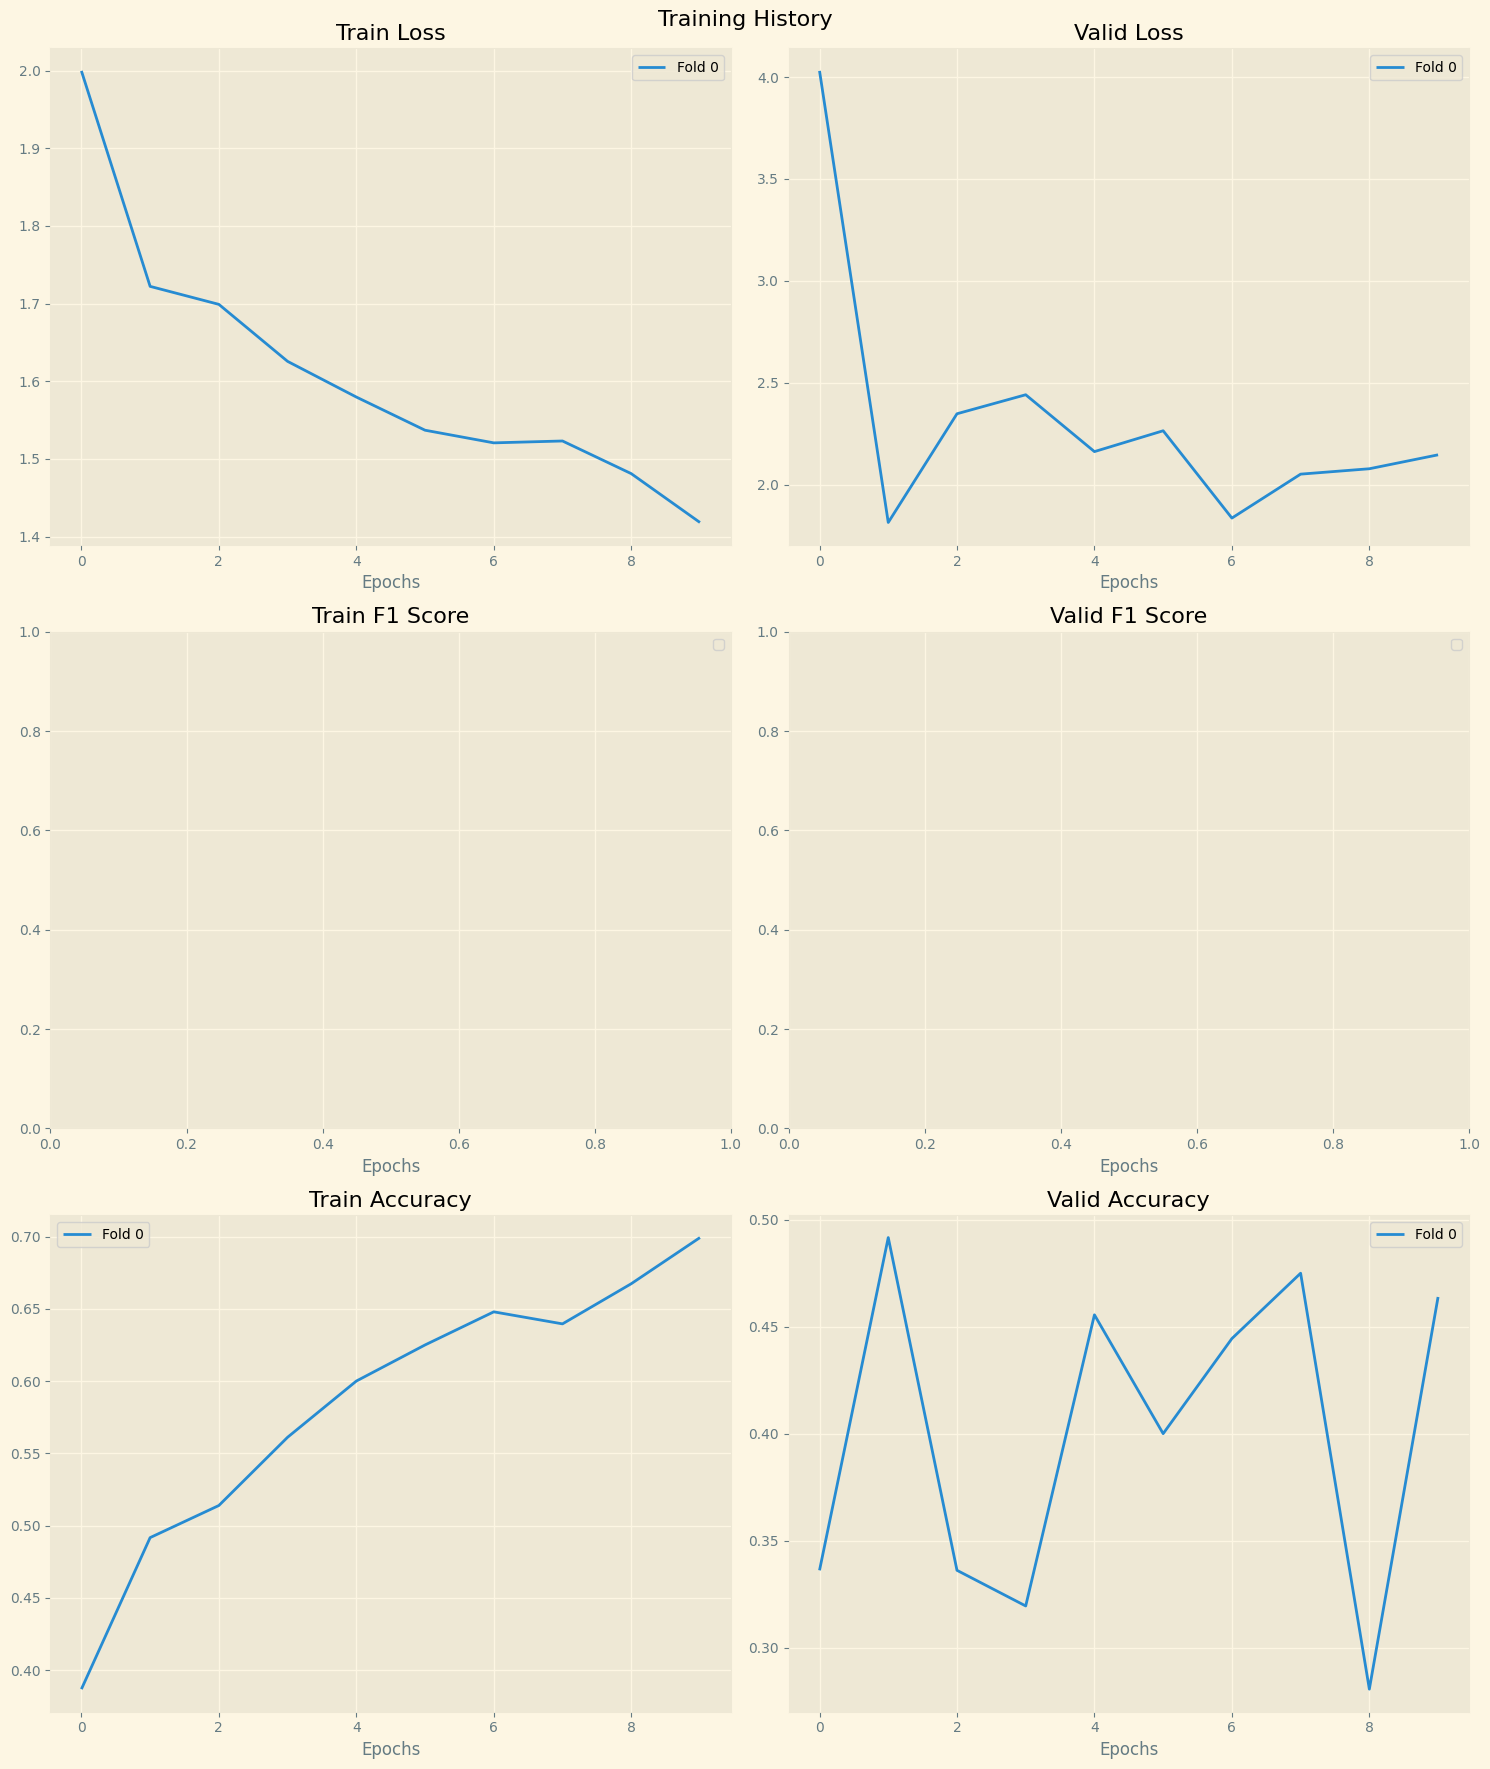

<Figure size 1500x1800 with 0 Axes>

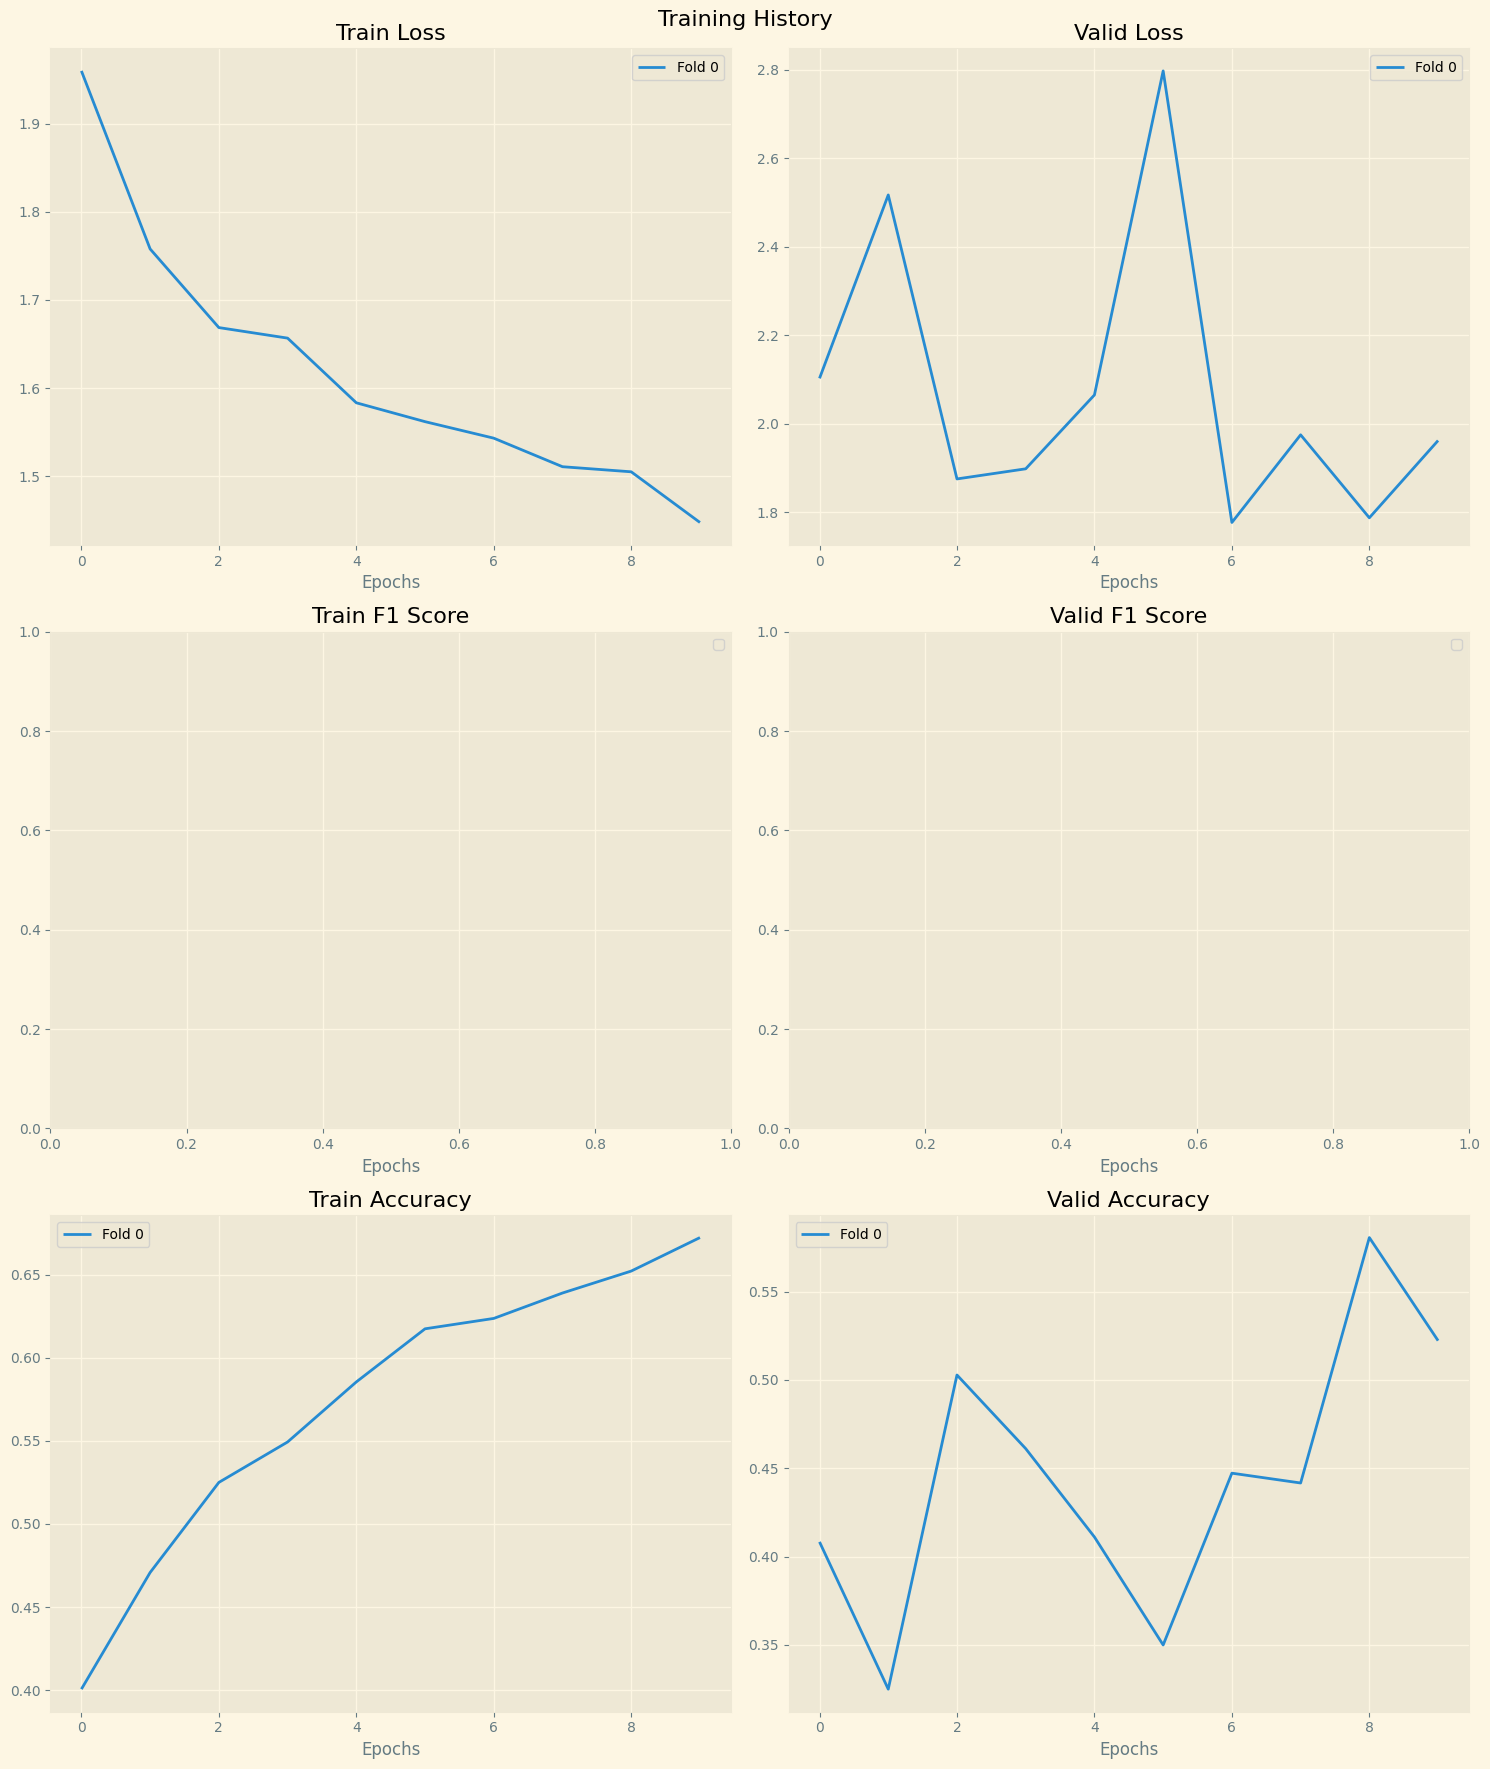

<Figure size 1500x1800 with 0 Axes>

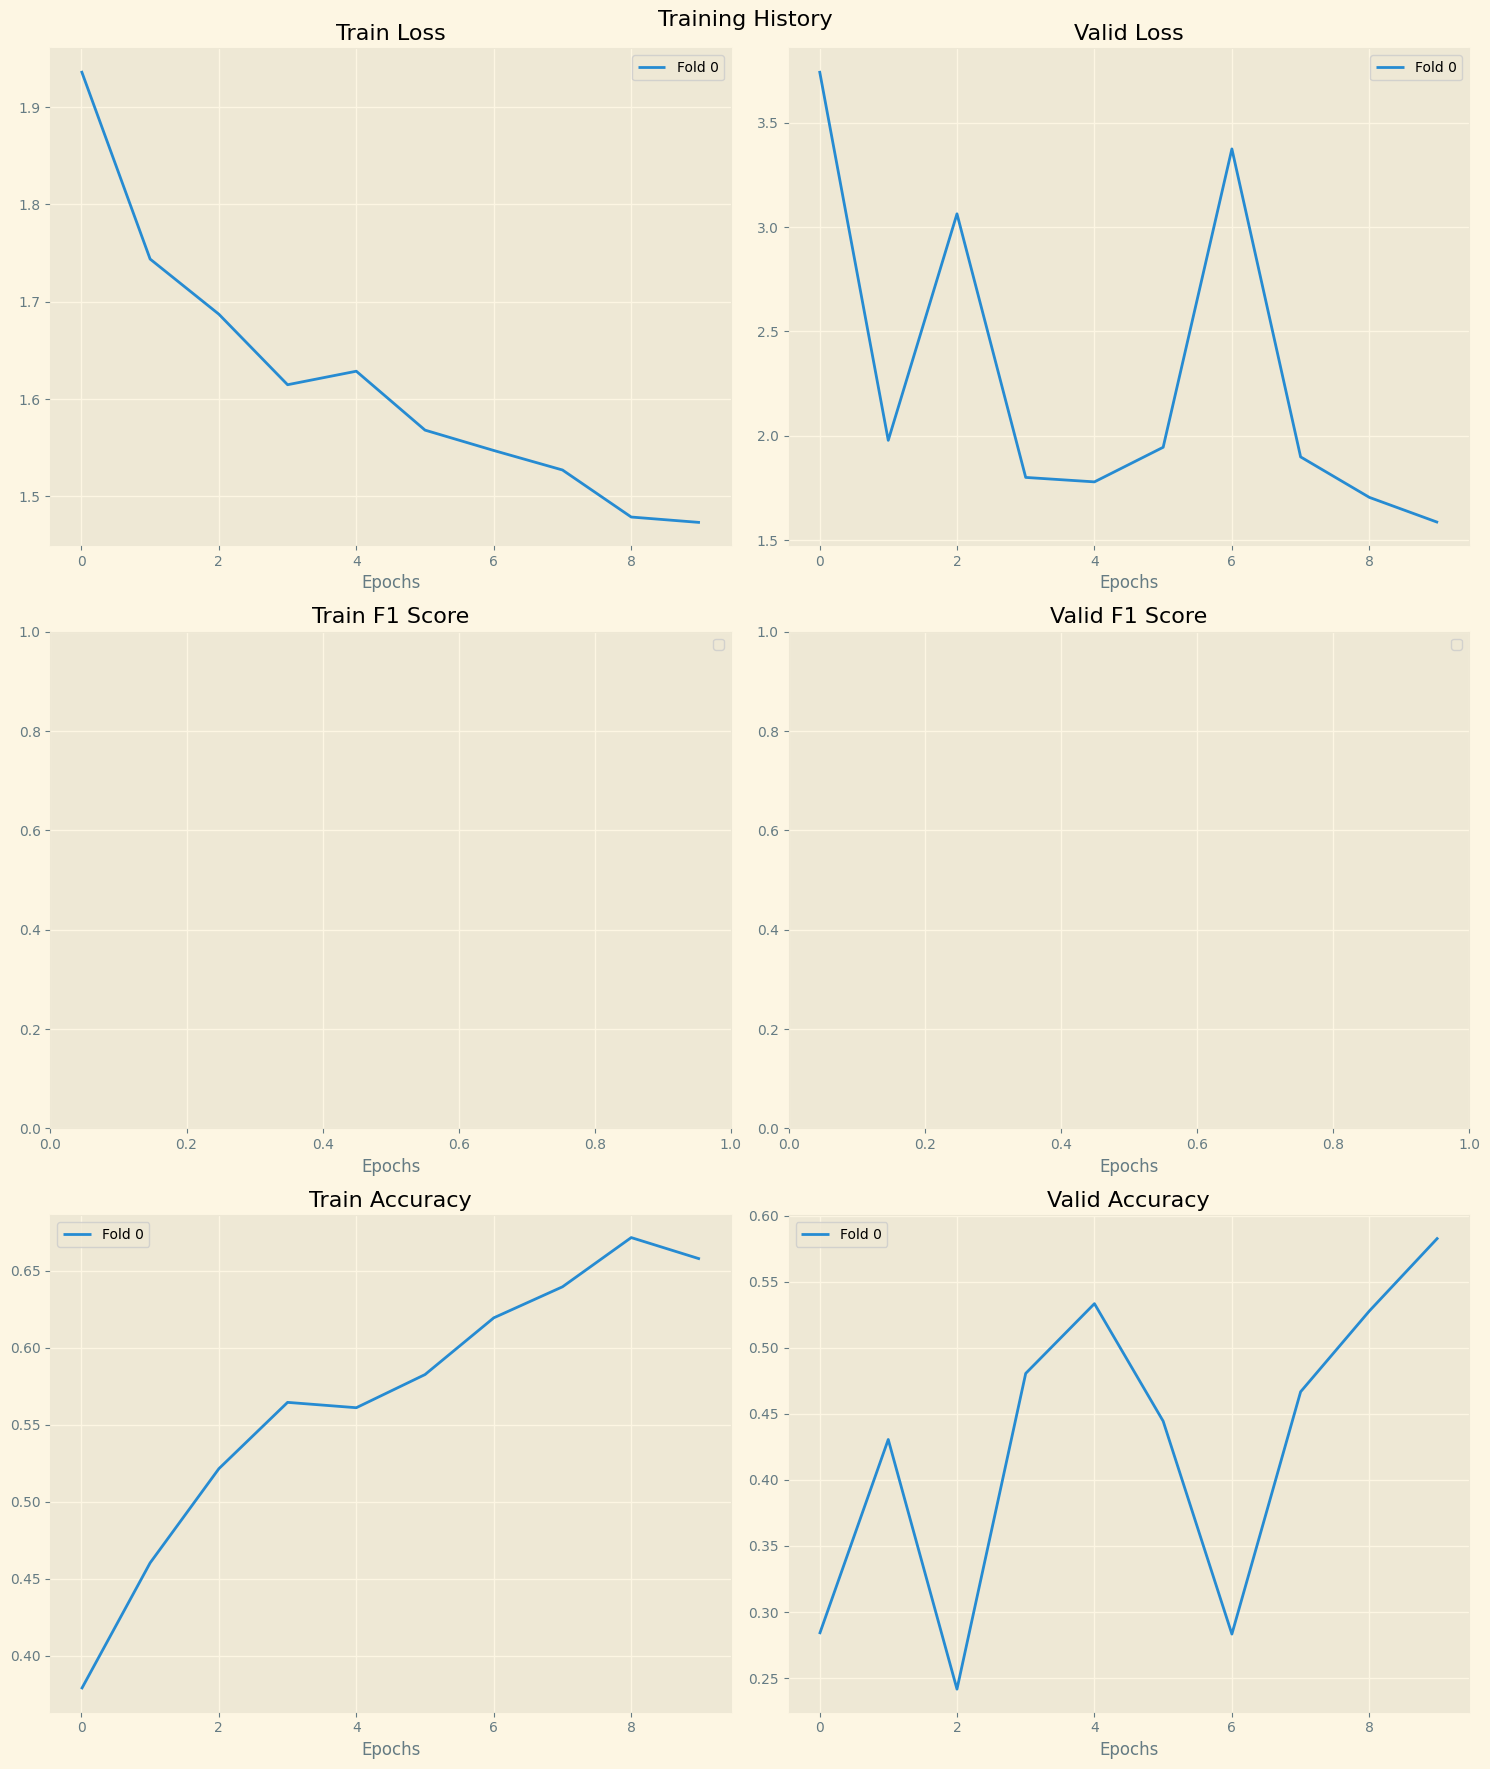

In [27]:
import matplotlib.pyplot as plt

def plot_training_history(all_history):
    if LOAD_MODELS_FROM is None:
        metrics = ['Loss', 'F1 Score', 'Accuracy']
        datasets = ['Train', 'Valid']
        
        fig, axes = plt.subplots(3, 2, figsize=(15, 18))
        fig.suptitle('Training History', fontsize=16)
        
        for i, metric in enumerate(metrics):
            for j, dataset in enumerate(datasets):
                ax = axes[i, j]
                key = f'{dataset} {metric}'
                ax.set_title(f'{dataset} {metric}')
                for fold, history in enumerate(all_history[key]):
                    ax.plot(history, label=f'Fold {fold}')
                ax.set_xlabel('Epochs')
                ax.legend()
        
        plt.tight_layout()
        plt.show()

# 각 실험 결과에 대해 학습 히스토리 플롯
for result in results:
    clip_limit = result['clip_limit']
    tile_grid_size = result['tile_grid_size']
    plt.figure(figsize=(15, 18))
    plt.suptitle(f'Training History (CLAHE: clip={clip_limit}, tile={tile_grid_size})', fontsize=16)
    plot_training_history(result['all_history'])
    plt.show()

In [28]:
# 결과 분석
results_df = pd.DataFrame([(r['clip_limit'], r['tile_grid_size'], r['accuracy'], r['f1_score']) for r in results],
                          columns=['clip_limit', 'tile_grid_size', 'accuracy', 'f1_score'])
results_df

clip_limit tile_grid_size  accuracy  f1_score
0          2.0         (4, 4)  0.487500  0.471346
1          2.0         (8, 8)  0.445833  0.422905
2          2.0       (16, 16)  0.513889  0.486160
3          2.0       (32, 32)  0.505556  0.461311
4          3.0         (4, 4)  0.495833  0.472558
5          3.0         (8, 8)  0.468056  0.453082
6          3.0       (16, 16)  0.497222  0.514586
7          3.0       (32, 32)  0.476389  0.467571
8          4.0         (4, 4)  0.361111  0.341683
9          4.0         (8, 8)  0.495833  0.474017
10         4.0       (16, 16)  0.465278  0.423986
11         4.0       (32, 32)  0.436111  0.442119

In [29]:
# 최고의 성능을 보인 설정 찾기
best_result = results_df.loc[results_df['f1_score'].idxmax()]
print("Best CLAHE settings:")
print(f"Clip Limit: {best_result['clip_limit']}")
print(f"Tile Grid Size: {best_result['tile_grid_size']}")
print(f"F1 Score: {best_result['f1_score']}")
print(f"Accuracy: {best_result['accuracy']}")

Best CLAHE settings:
Clip Limit: 3.0
Tile Grid Size: (16, 16)
F1 Score: 0.5145858717925139
Accuracy: 0.49722222222222223


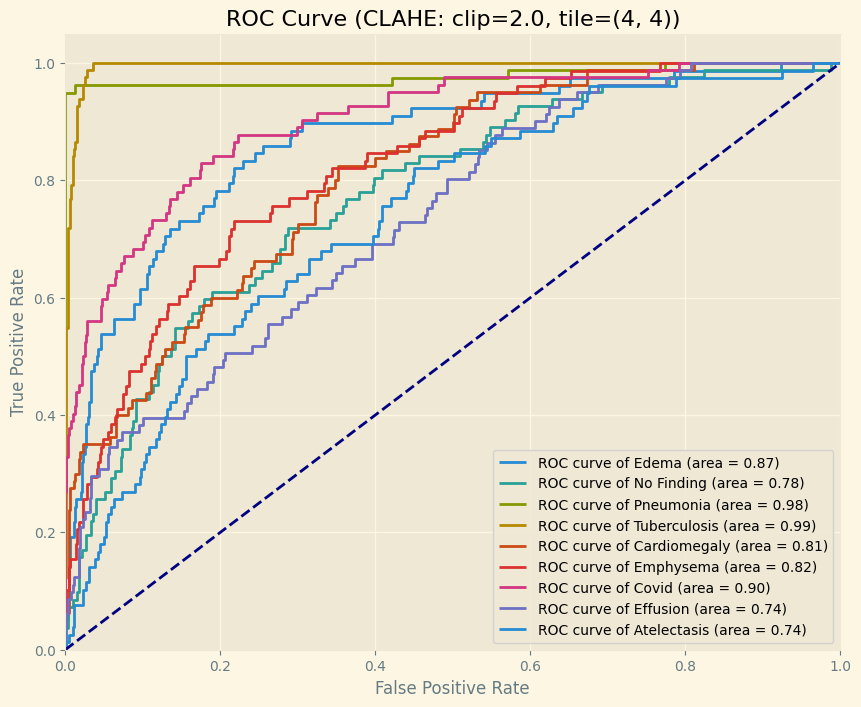

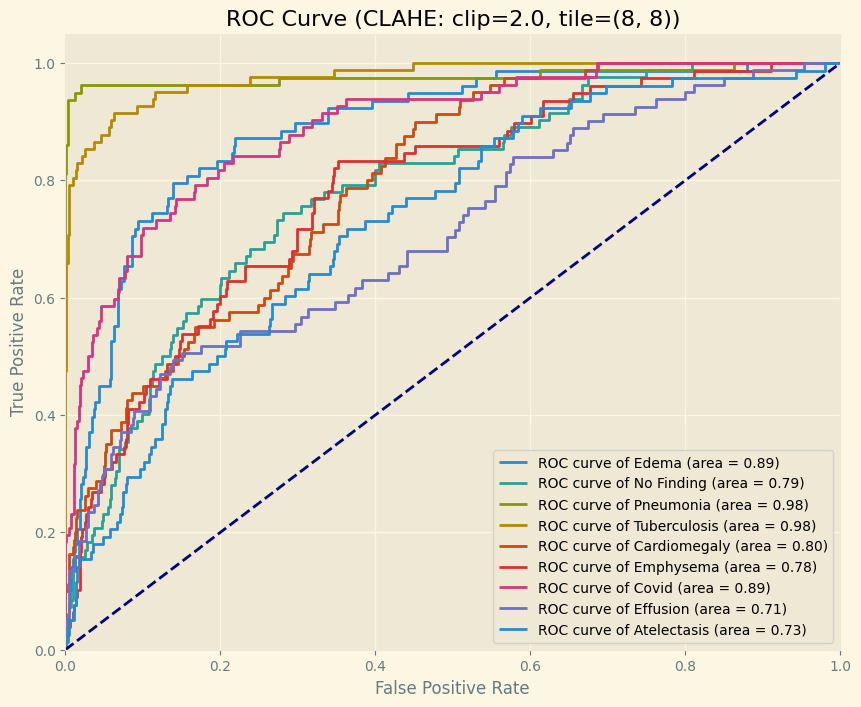

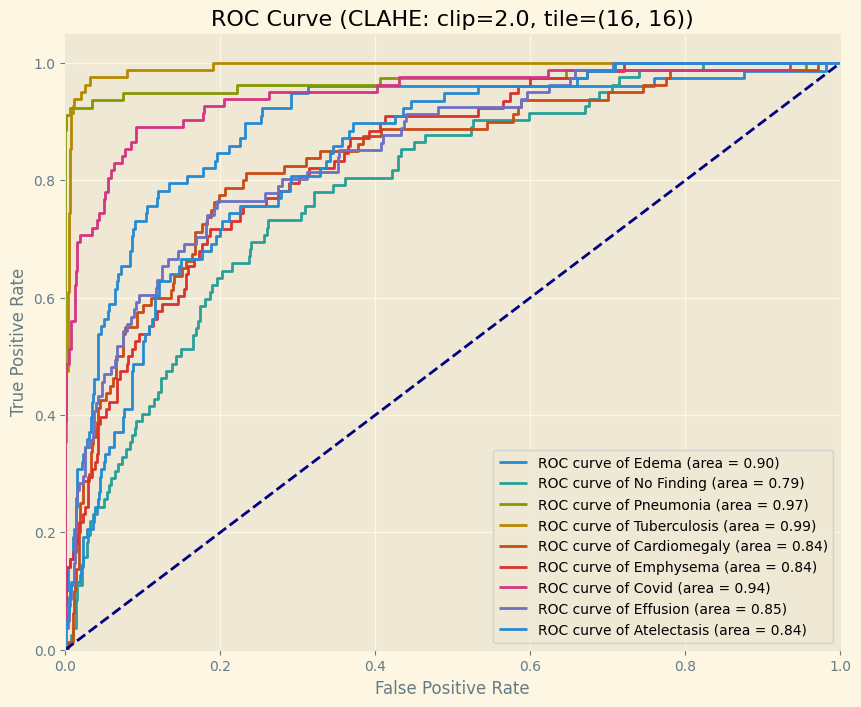

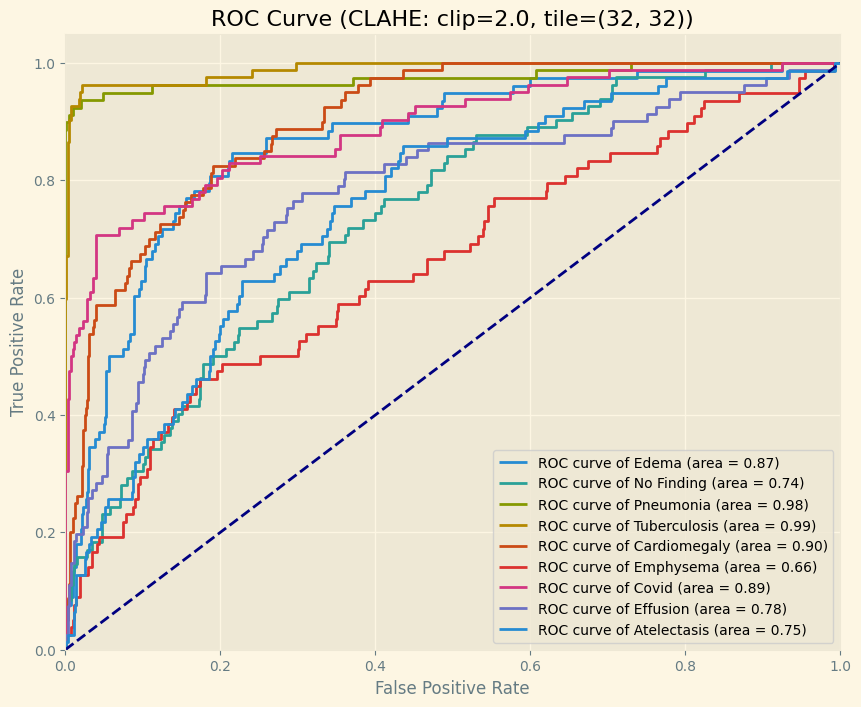

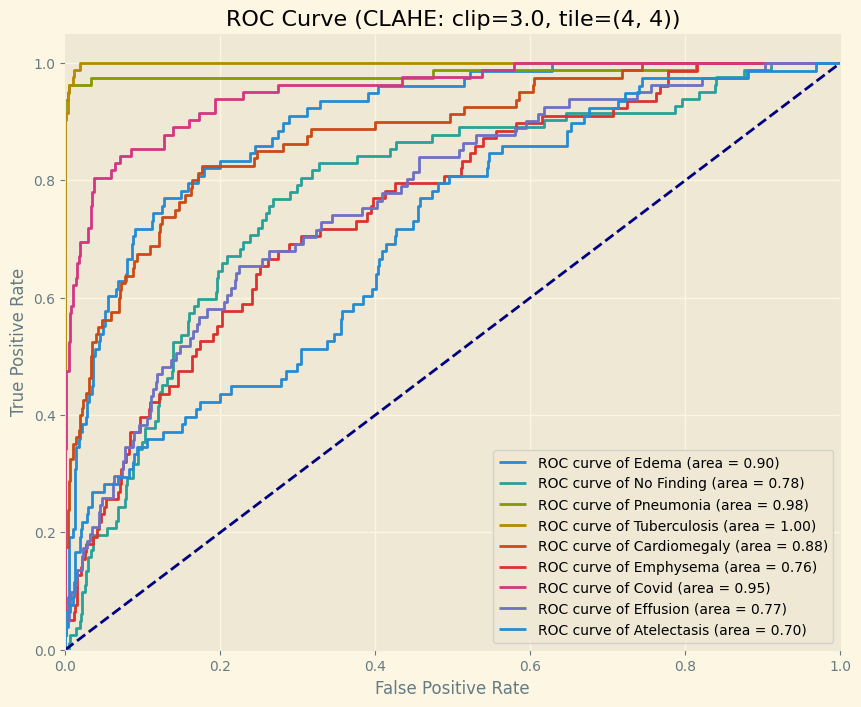

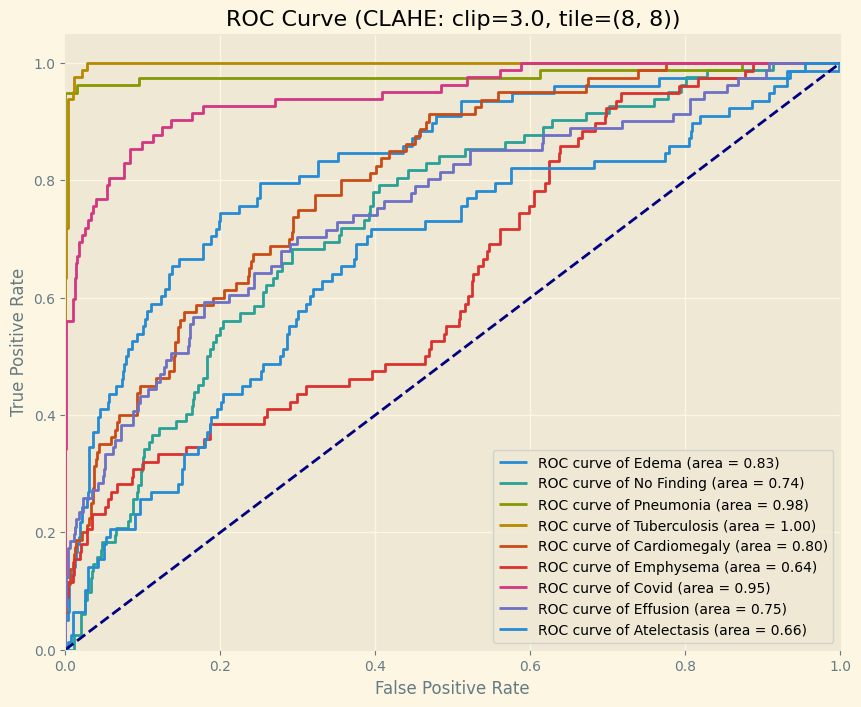

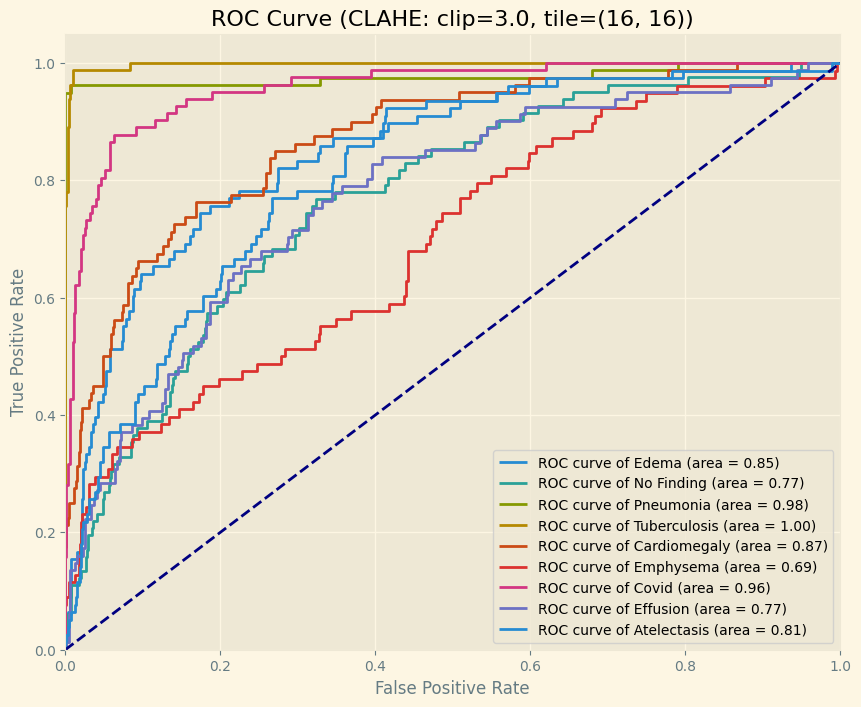

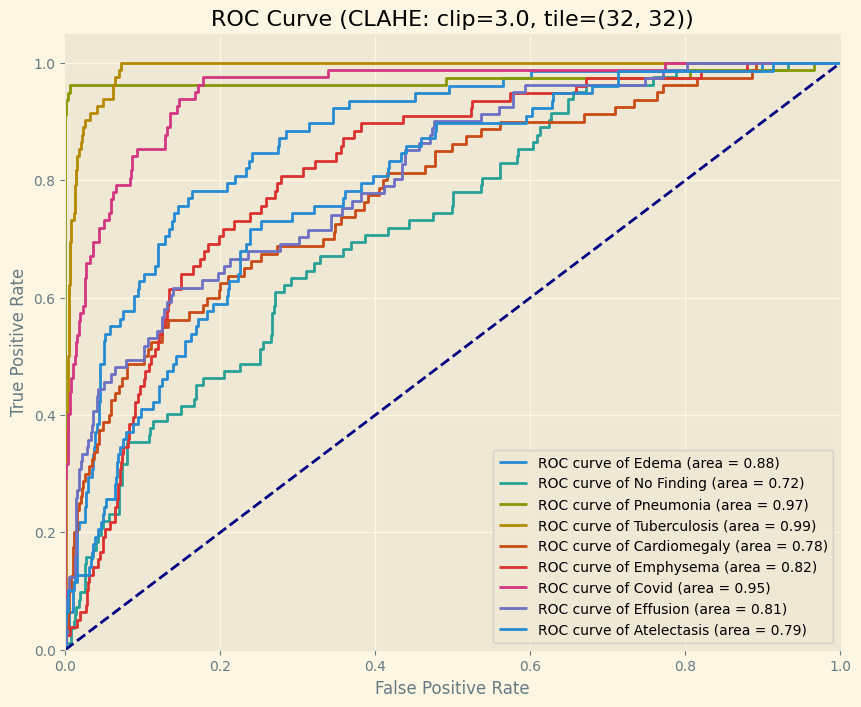

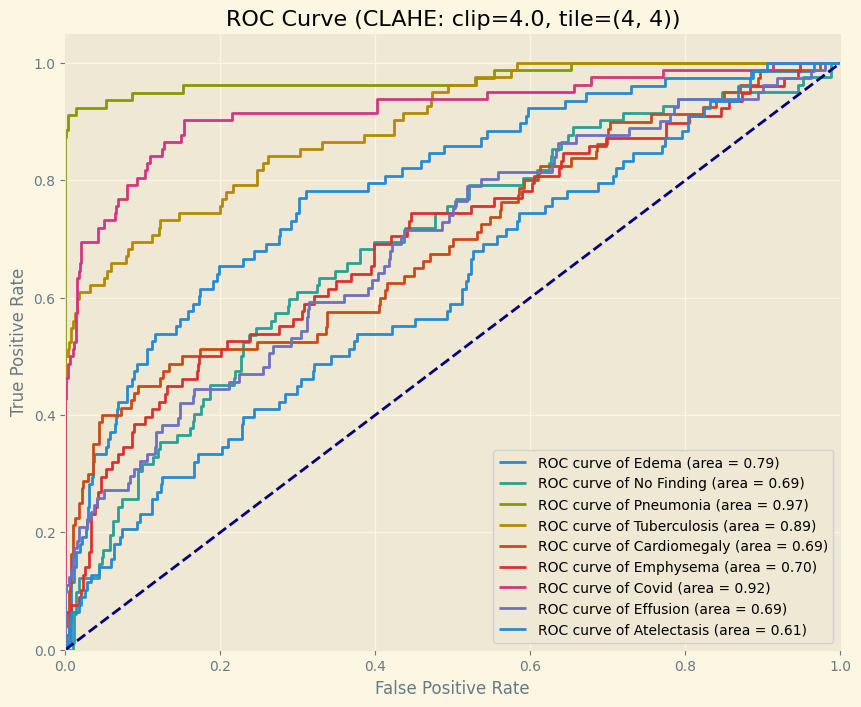

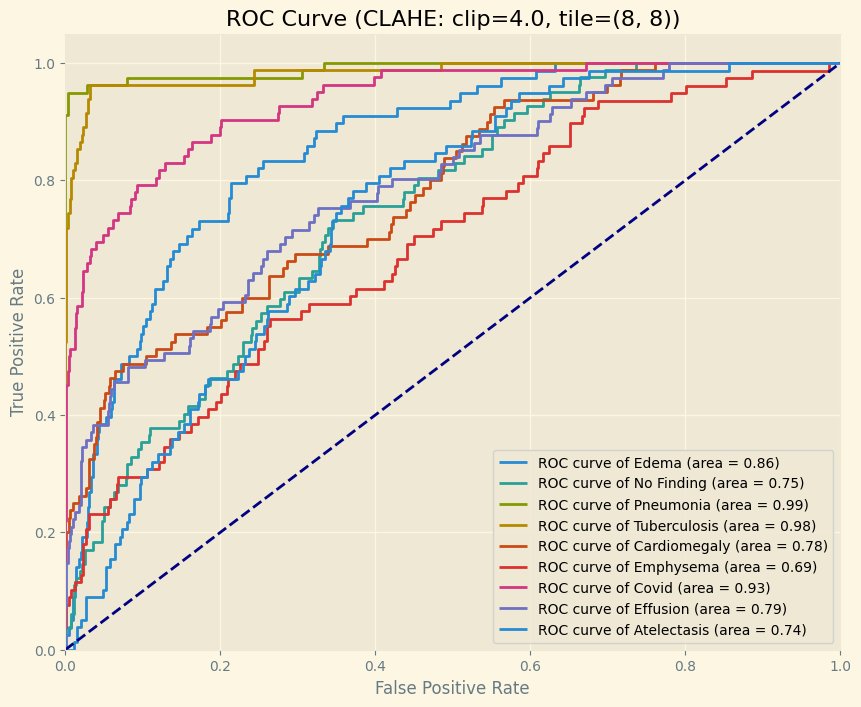

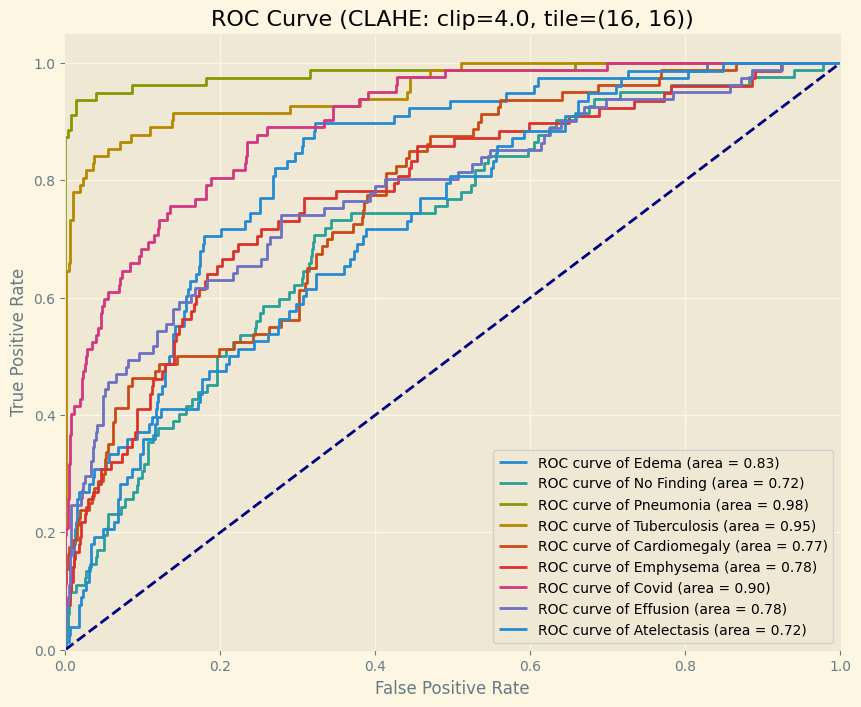

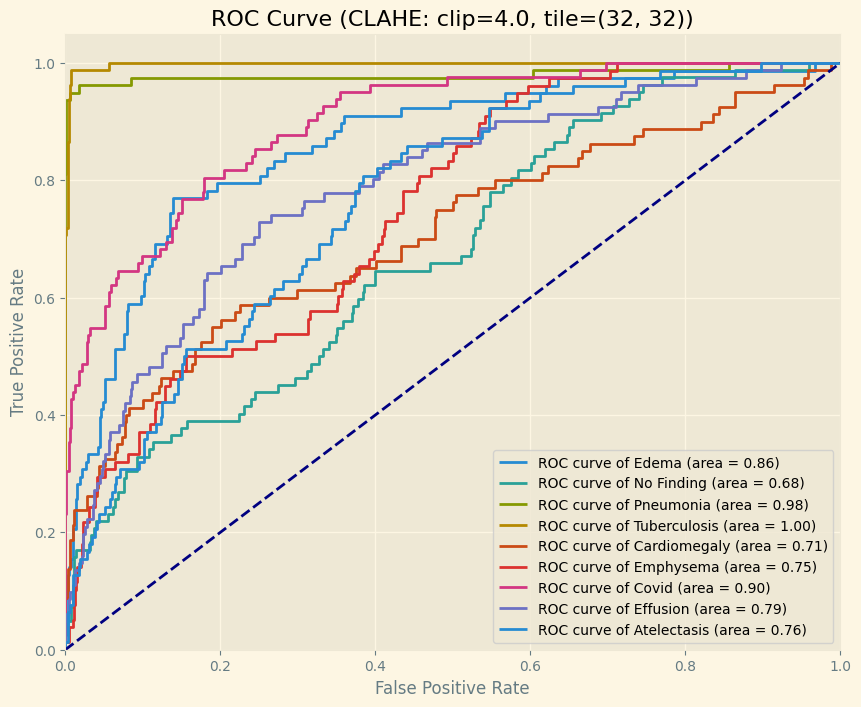

In [30]:
def plot_roc_curves(results, TARGET):
    for result in results:
        fpr, tpr, roc_auc = {}, {}, {}
        
        plt.figure(figsize=(10, 8))
        for i, target in enumerate(TARGET):
            fpr[i], tpr[i], _ = roc_curve(result['all_true'][:, i], result['all_oof'][:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
            
            plt.plot(fpr[i], tpr[i], lw=2,
                     label=f'ROC curve of {target} (area = {roc_auc[i]:0.2f})')
        
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve (CLAHE: clip={result["clip_limit"]}, tile={result["tile_grid_size"]})')
        plt.legend(loc="lower right")
        plt.show()

# 함수 사용
plot_roc_curves(results, TARGET)

# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>5. Inference</b></div>


Processing result with CLAHE: clip=2.0, tile=(4, 4)
Fold 1
 1/15 ━━━━━━━━━━━━━━━━━━━━ 51s 4s/step

I0000 00:00:1724083136.538312      70 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


15/15 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step
Accuracy for Test Set = 0.4477777777777778
F1 Score for Test Set = 0.42652129397854804


<Figure size 1000x800 with 0 Axes>

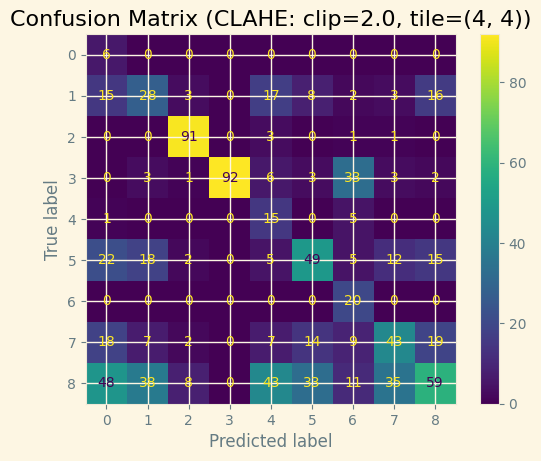

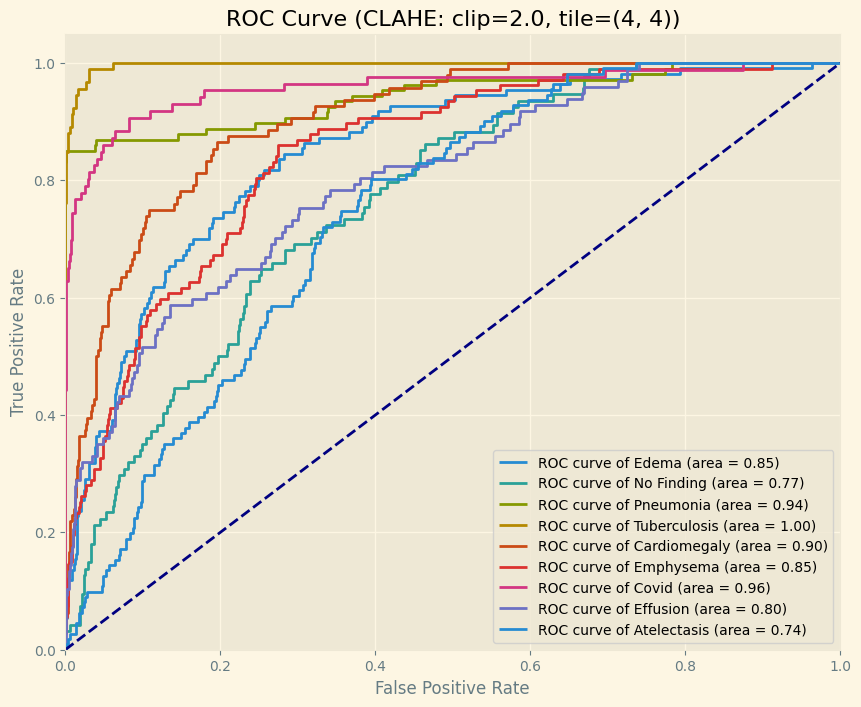


Processing result with CLAHE: clip=2.0, tile=(8, 8)
Fold 1
15/15 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step
Accuracy for Test Set = 0.4266666666666667
F1 Score for Test Set = 0.3720663634312589


<Figure size 1000x800 with 0 Axes>

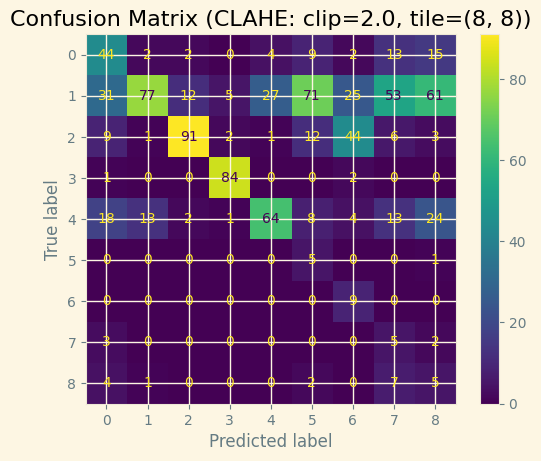

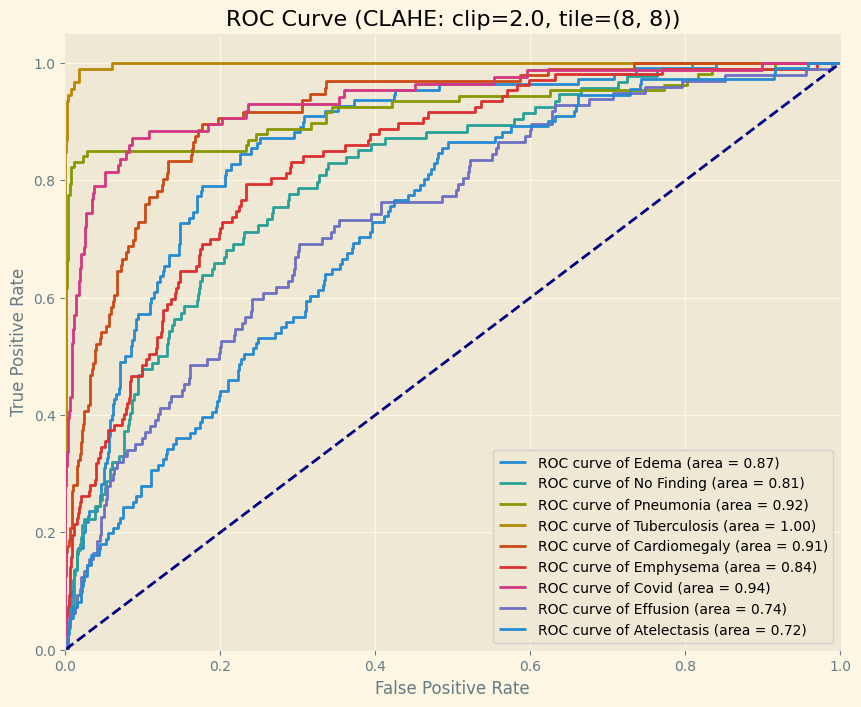


Processing result with CLAHE: clip=2.0, tile=(16, 16)
Fold 1
15/15 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step
Accuracy for Test Set = 0.30777777777777776
F1 Score for Test Set = 0.287882215137014


<Figure size 1000x800 with 0 Axes>

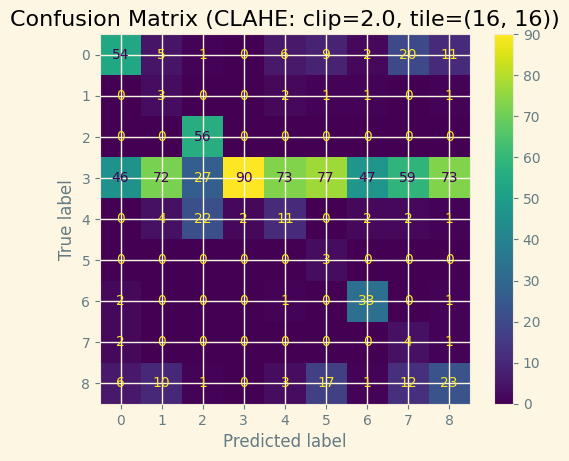

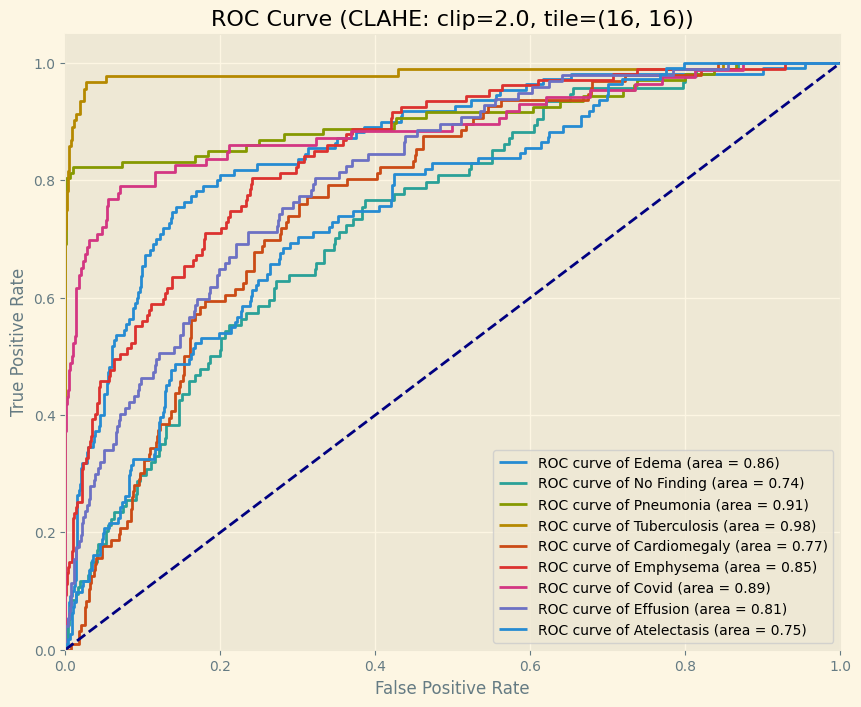


Processing result with CLAHE: clip=2.0, tile=(32, 32)
Fold 1
15/15 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step
Accuracy for Test Set = 0.35888888888888887
F1 Score for Test Set = 0.31818817393983195


<Figure size 1000x800 with 0 Axes>

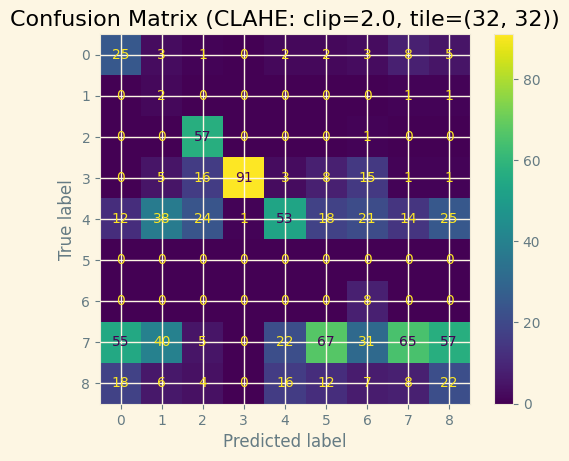

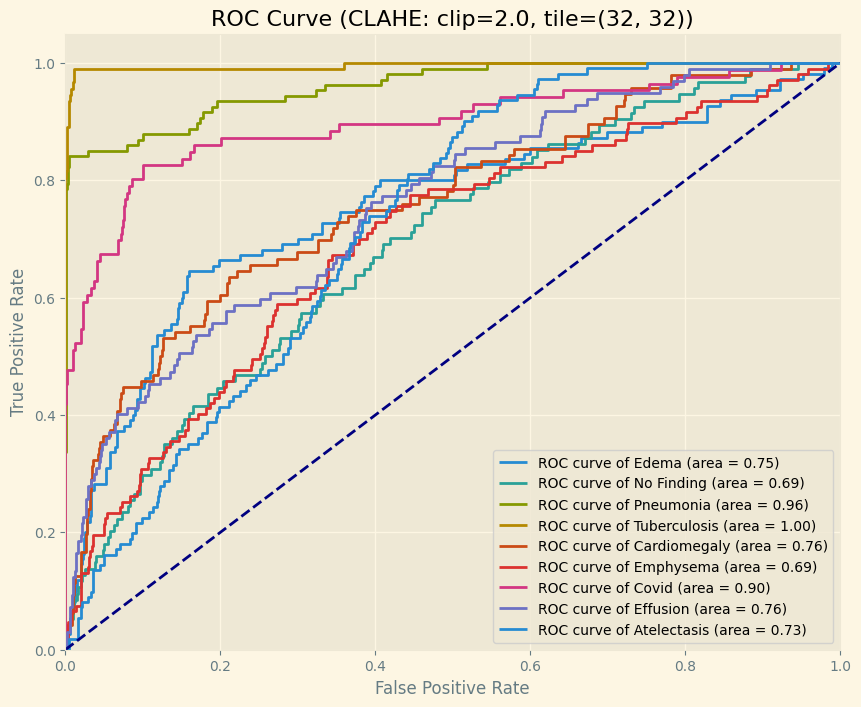


Processing result with CLAHE: clip=3.0, tile=(4, 4)
Fold 1
15/15 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step
Accuracy for Test Set = 0.44555555555555554
F1 Score for Test Set = 0.43314831338266885


<Figure size 1000x800 with 0 Axes>

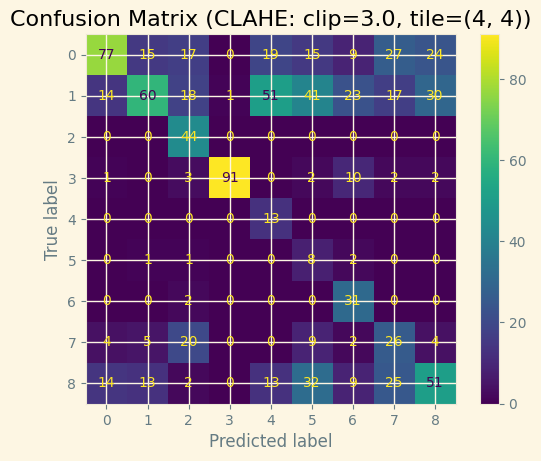

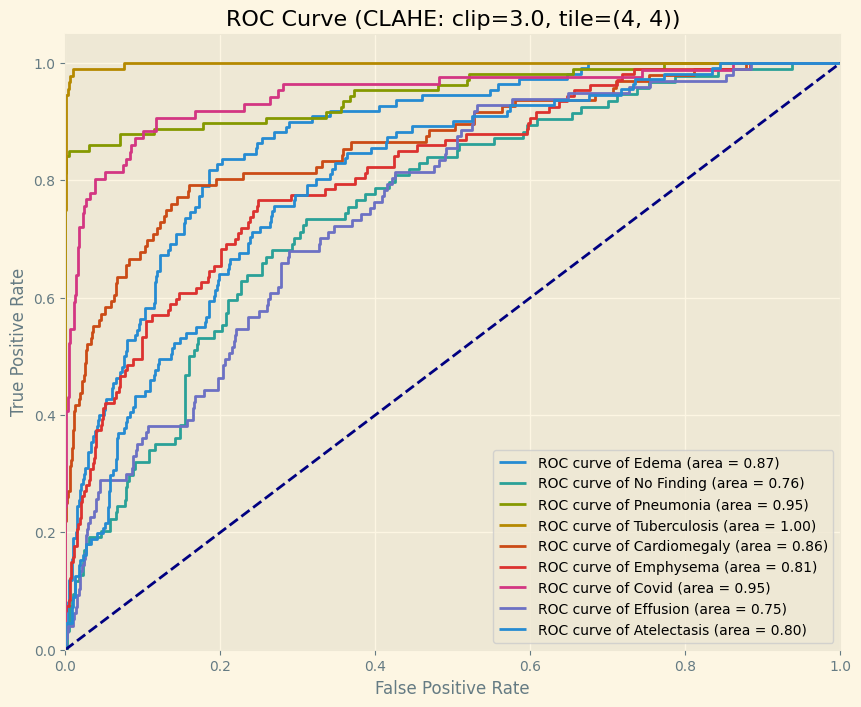


Processing result with CLAHE: clip=3.0, tile=(8, 8)
Fold 1
15/15 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step
Accuracy for Test Set = 0.5522222222222222
F1 Score for Test Set = 0.5462128570330456


<Figure size 1000x800 with 0 Axes>

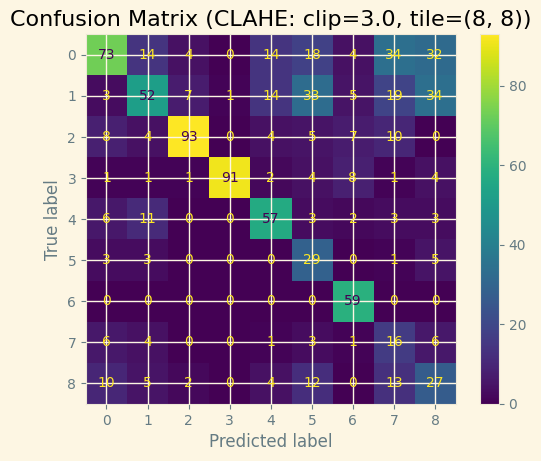

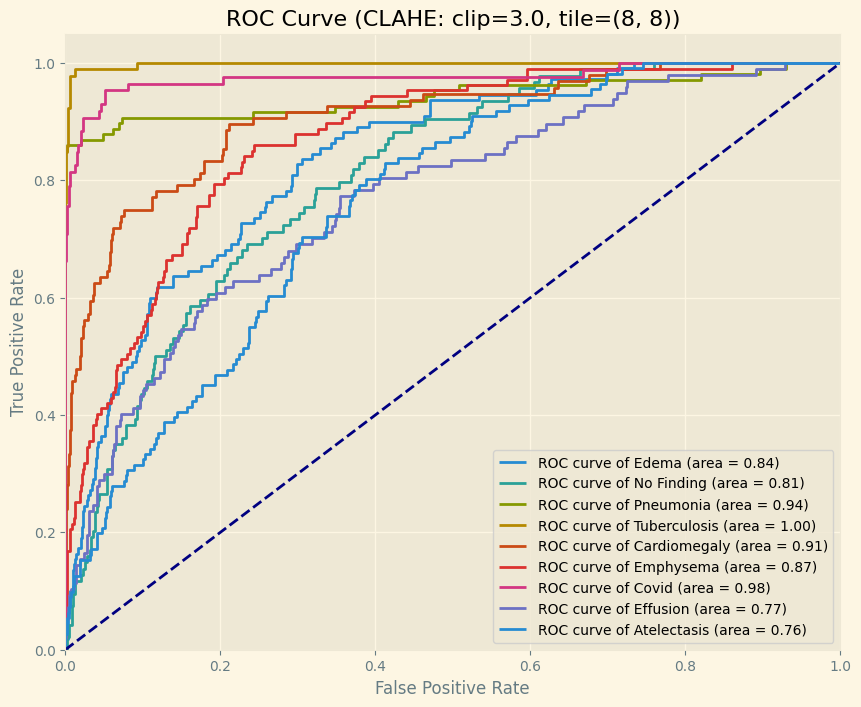


Processing result with CLAHE: clip=3.0, tile=(16, 16)
Fold 1
15/15 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step
Accuracy for Test Set = 0.45666666666666667
F1 Score for Test Set = 0.44058322867325106


<Figure size 1000x800 with 0 Axes>

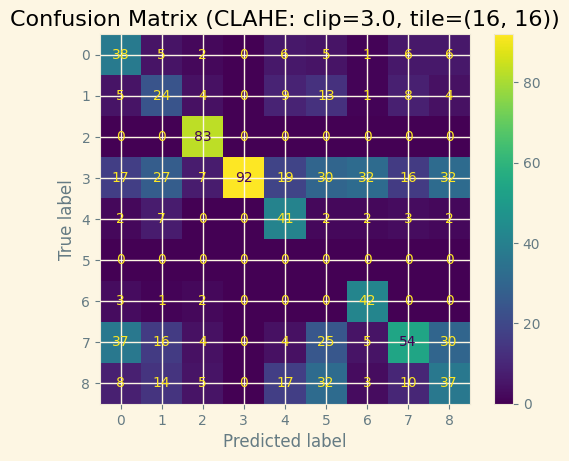

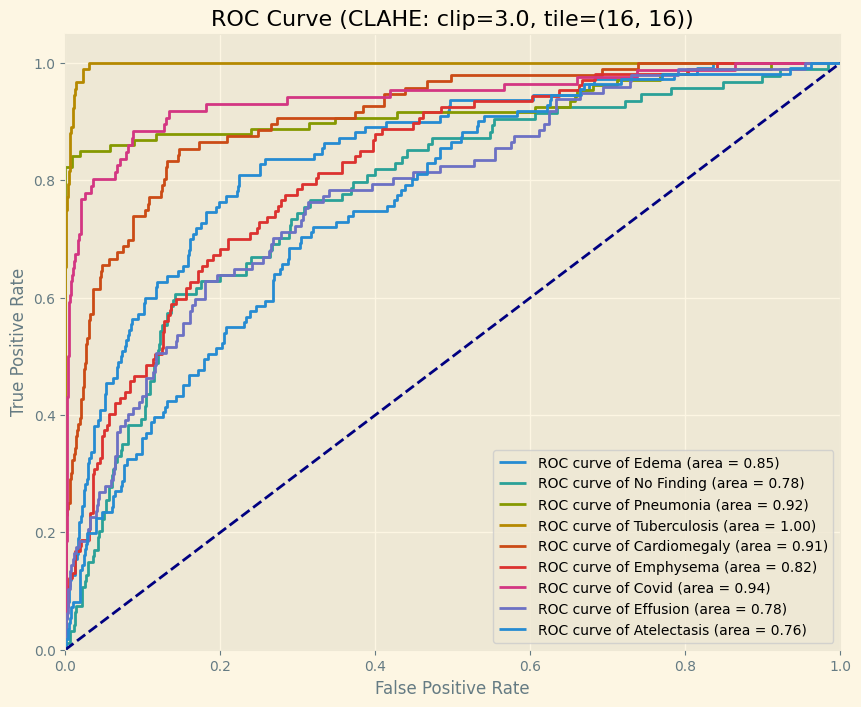


Processing result with CLAHE: clip=3.0, tile=(32, 32)
Fold 1
15/15 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step
Accuracy for Test Set = 0.21666666666666667
F1 Score for Test Set = 0.15627683896809458


<Figure size 1000x800 with 0 Axes>

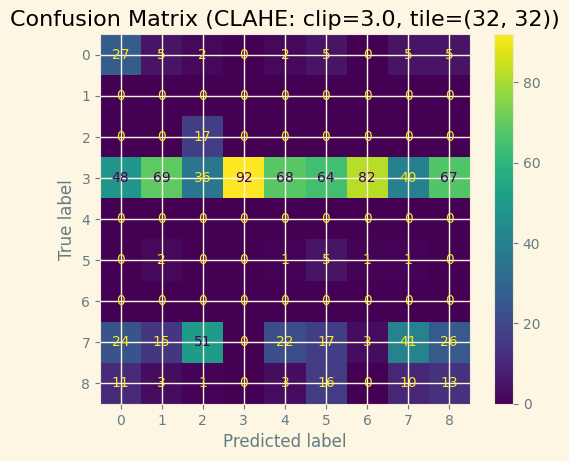

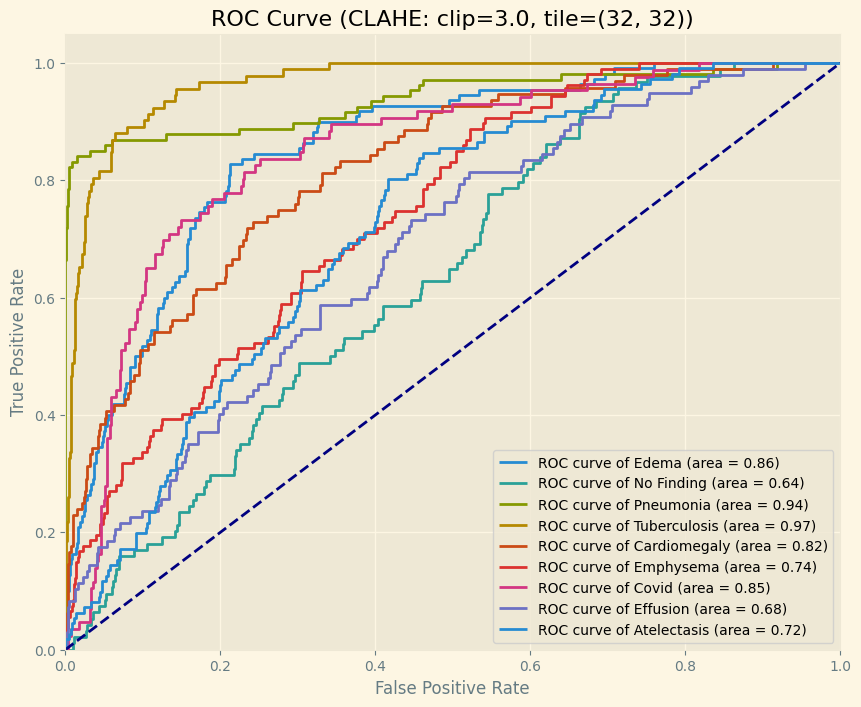


Processing result with CLAHE: clip=4.0, tile=(4, 4)
Fold 1
15/15 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step
Accuracy for Test Set = 0.24666666666666667
F1 Score for Test Set = 0.20033178793112139


<Figure size 1000x800 with 0 Axes>

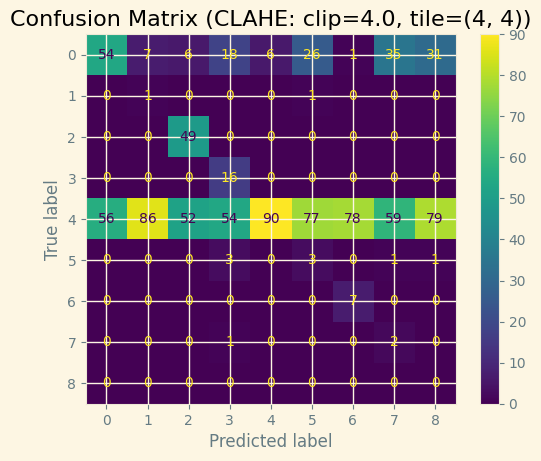

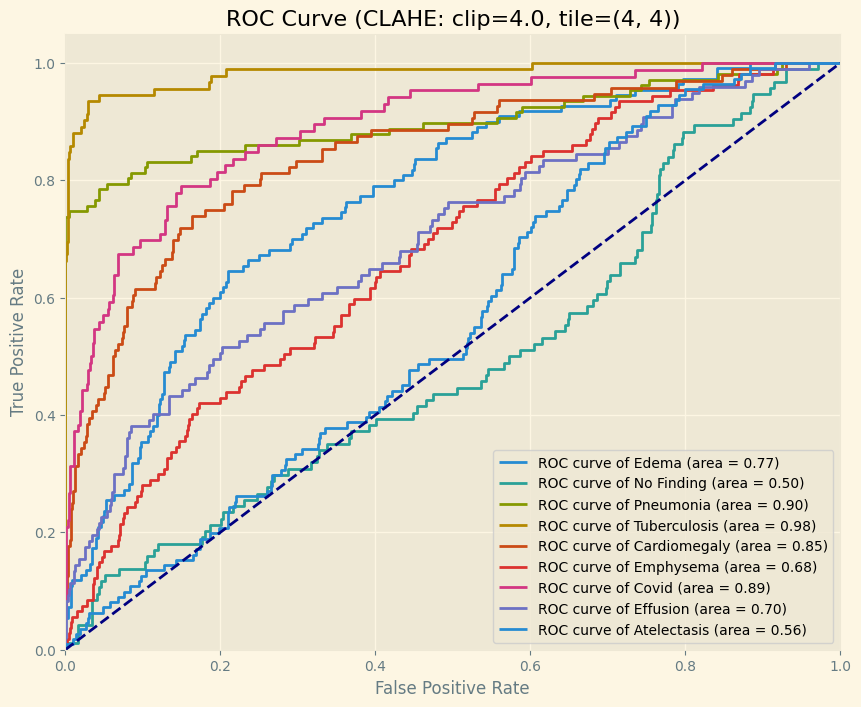


Processing result with CLAHE: clip=4.0, tile=(8, 8)
Fold 1
15/15 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step
Accuracy for Test Set = 0.4822222222222222
F1 Score for Test Set = 0.46786922764209316


<Figure size 1000x800 with 0 Axes>

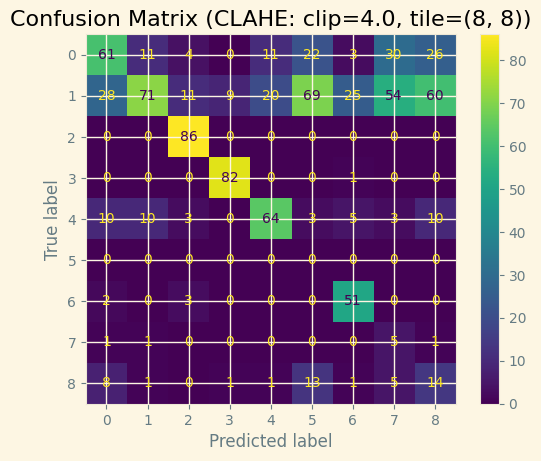

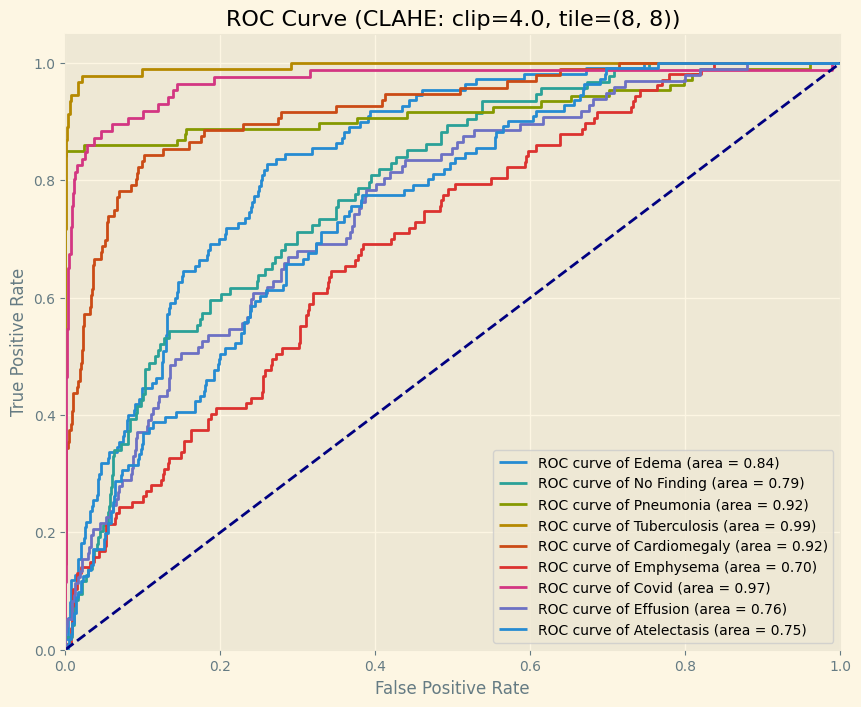


Processing result with CLAHE: clip=4.0, tile=(16, 16)
Fold 1
15/15 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step
Accuracy for Test Set = 0.5133333333333333
F1 Score for Test Set = 0.4759867342629734


<Figure size 1000x800 with 0 Axes>

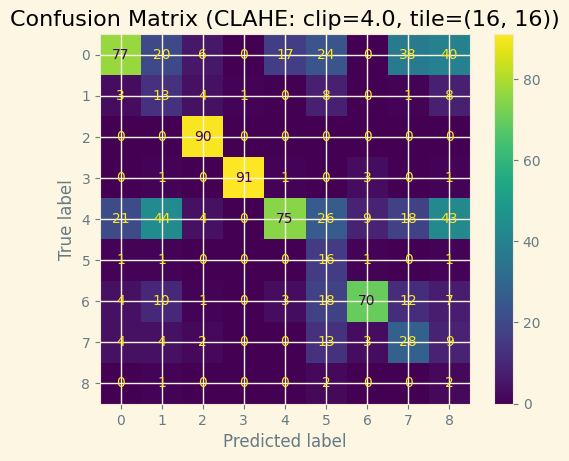

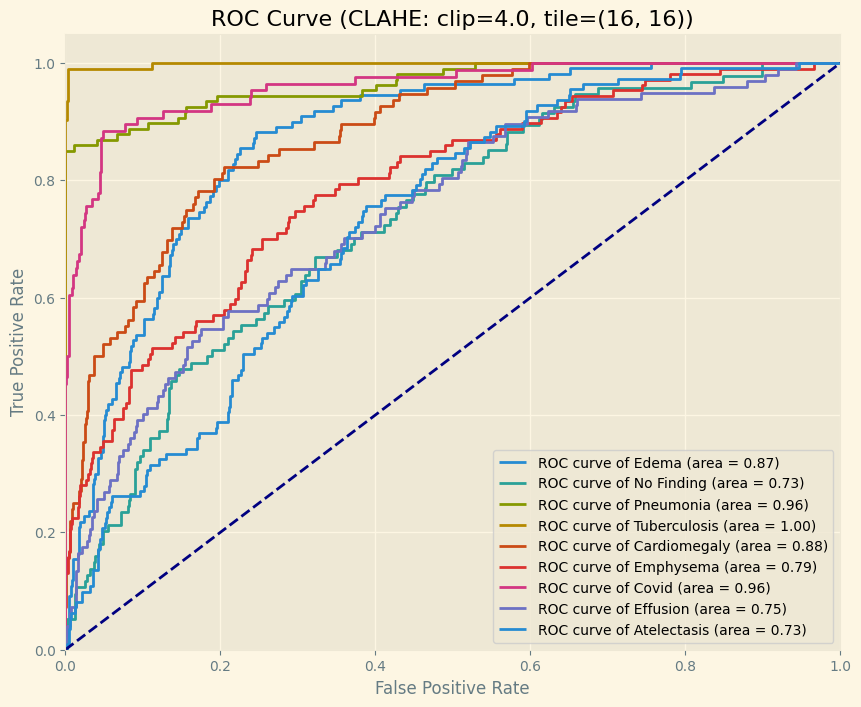


Processing result with CLAHE: clip=4.0, tile=(32, 32)
Fold 1
15/15 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step
Accuracy for Test Set = 0.3788888888888889
F1 Score for Test Set = 0.35615903961702067


<Figure size 1000x800 with 0 Axes>

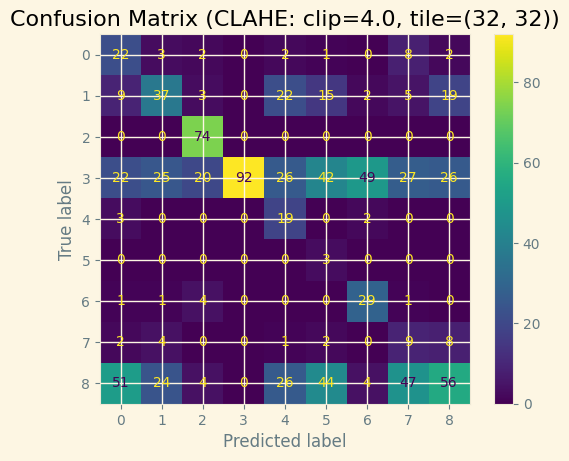

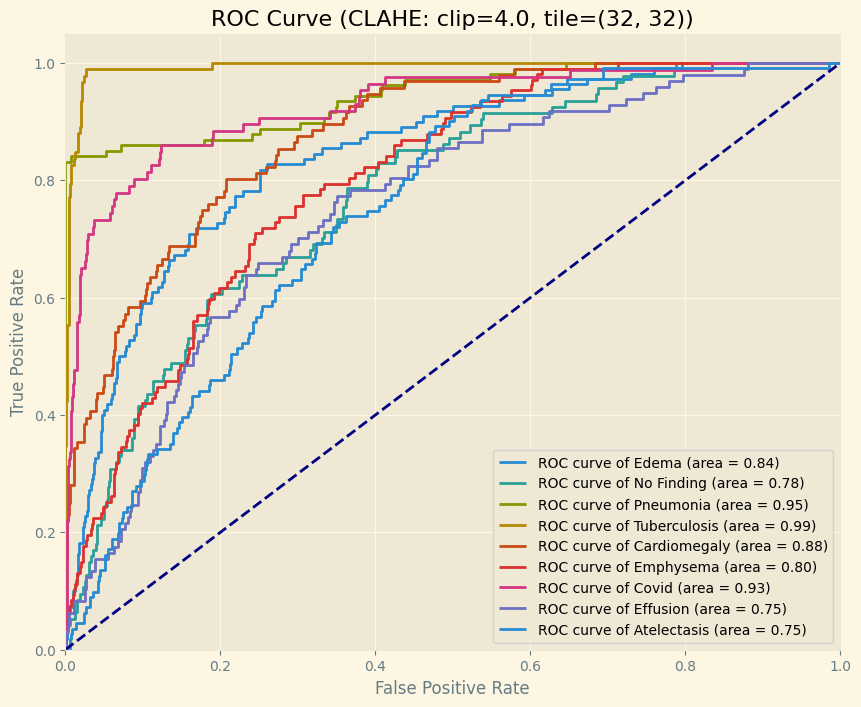

In [31]:
for result in results:
    clip_limit = result['clip_limit']
    tile_grid_size = result['tile_grid_size']
    
    print(f"\nProcessing result with CLAHE: clip={clip_limit}, tile={tile_grid_size}")
    
    preds = []
    model = build_model()
    
    ## No TTA
    test_gen = DataGenerator(df_test, shuffle=False, batch_size=64, preprocess=preprocess_input)
    for i in range(1):
        print(f'Fold {i+1}') 
        if LOAD_MODELS_FROM:
            model.load_weights(f'{LOAD_MODELS_FROM}ResNet_f{i}_clip{clip_limit}_tile{tile_grid_size[0]}.weights.h5')
        else: 
            model.load_weights(f'ResNet_f{i}_clip{clip_limit}_tile{tile_grid_size[0]}.weights.h5')
    
        pred = model.predict(test_gen, verbose=1) 
        
        preds.append(pred)
    
    pred_res = np.mean(preds, axis=0)
    
    # Accuracy
    accuracy = accuracy_score(np.argmax(df_test[TARGET].values, axis=1), np.argmax(pred_res, axis=1))
    print('Accuracy for Test Set =', accuracy)
    
    # F1 Score
    f1 = f1_score(np.argmax(df_test[TARGET].values, axis=1), np.argmax(pred_res, axis=1), average='macro')
    print('F1 Score for Test Set =', f1)
    
    # Confusion Matrix
    cm = confusion_matrix(np.argmax(pred_res, axis=1),
                          np.argmax(df_test[TARGET].values, axis=1),
                          labels=[x for x in range(len(TARGET))])
    display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[x for x in range(len(TARGET))])
    plt.figure(figsize=(10, 8))
    display.plot()
    plt.title(f'Confusion Matrix (CLAHE: clip={clip_limit}, tile={tile_grid_size})')
    plt.show()

    # ROC Curve
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i, target in enumerate(TARGET):
        fpr[i], tpr[i], _ = roc_curve(df_test[target], pred_res[:,i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # ROC 곡선 그리기
    plt.figure(figsize=(10, 8))
    for i, target in enumerate(TARGET):
        plt.plot(fpr[i], tpr[i], lw=2,
                 label=f'ROC curve of {target} (area = {roc_auc[i]:0.2f})')
    
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve (CLAHE: clip={clip_limit}, tile={tile_grid_size})')
    plt.legend(loc="lower right")
    plt.show()

#### TTA
___

In [32]:
"""## No TTA
test_gen = DataGenerator(df_test, shuffle=False, augment1=True, batch_size=64, preprocess=preprocess_input)

for i in range(1):
    print(f'Fold {i+1}') 
    if LOAD_MODELS_FROM:
        model.load_weights(f'{LOAD_MODELS_FROM}ResNet_f{i}.weights.h5')
    else: 
        model.load_weights(f'ResNet_f{i}.weights.h5')
    
    pred = model.predict(test_gen, verbose=1) 
    
preds.append(pred)
pred_res = np.mean(preds,axis=0)
    
# Accuracy 
accuracy = accuracy_score(np.argmax(df_test[TARGET].values, axis=1), np.argmax(pred_res, axis=1))
print('Accuracy for Test Set =', accuracy)

# F1 Score 
f1 = f1_score(np.argmax(df_test[TARGET].values, axis=1), np.argmax(pred_res, axis=1), average='macro') 
print('F1 Score for Test Set =', f1)"""

"## No TTA\ntest_gen = DataGenerator(df_test, shuffle=False, augment1=True, batch_size=64, preprocess=preprocess_input)\n\nfor i in range(1):\n    print(f'Fold {i+1}') \n    if LOAD_MODELS_FROM:\n        model.load_weights(f'{LOAD_MODELS_FROM}ResNet_f{i}.weights.h5')\n    else: \n        model.load_weights(f'ResNet_f{i}.weights.h5')\n    \n    pred = model.predict(test_gen, verbose=1) \n    \npreds.append(pred)\npred_res = np.mean(preds,axis=0)\n    \n# Accuracy \naccuracy = accuracy_score(np.argmax(df_test[TARGET].values, axis=1), np.argmax(pred_res, axis=1))\nprint('Accuracy for Test Set =', accuracy)\n\n# F1 Score \nf1 = f1_score(np.argmax(df_test[TARGET].values, axis=1), np.argmax(pred_res, axis=1), average='macro') \nprint('F1 Score for Test Set =', f1)"